# Topic Modeling and Magic: The Gathering

This notebook is to be read with this blog post. Here I have used [all the Legacy decks registered in 2020 on mtgtop8](https://www.mtgtop8.com/format?f=LE&meta=199). I obtained this file from a companion project: [spider_mtg](https://github.com/pfr974/spider_mtg) and have done the same for other years here: https://github.com/pfr974/mtg-legacy-data. Please, feel free to use them and also point out mistakes if you see some (シ_ _)シ 

## Prerequisites:

You will need the following libraries:
- [NumPy](https://numpy.org/doc/stable/user/quickstart.html) 
- [six](https://six.readthedocs.io/) 
- [gensim](https://radimrehurek.com/gensim/)
- [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html#installation)

## Acknowledgments ೕ(･ㅂ･ ):

The starting point for this project was reading a while ago [this article](https://towardsdatascience.com/finding-magic-the-gathering-archetypes-with-latent-dirichlet-allocation-729112d324a6) by [hlynurd](https://github.com/hlynurd). Please give it a read and check [his notebook](https://github.com/hlynurd/lda-for-magic)!

Both [hlynurd](https://github.com/hlynurd) and I pretty much followed [this tutorial](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html) which explains the core concepts needed to understand and use [gensim](https://radimrehurek.com/gensim/).

## Disclaimer (`Д´)ゞ:

The information presented here about Magic: The Gathering is copyrighted by Wizards of the Coast. This project is not produced, endorsed, supported, or affiliated with Wizards of the Coast.

https://www.mtgtop8.com/ is the source of my data. This project would not have been possible without their amazing work!

**I by no means claim to be a data science expert. Feel free to criticize if you don't agree with something**.

In [2]:
# Adapted from: https://github.com/hlynurd/lda-for-magic/blob/master/lda-mtg-notebook.ipynb

#import pandas as pd
#import itertools as it

import gensim 
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.nmf import Nmf
from gensim.models.hdpmodel import HdpModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import json
import numpy as np
import re 
from six import iteritems

import logging
try:
    import pyLDAvis.gensim
except ImportError:
    ValueError("SKIP: please install pyLDAvis")
    
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


## Importing and processing the data

The documents (decklists) are stored in a single file, one document per line. We have 75 cards in a deck: 60 cards mainboard, 15 cards sideboard.

In [4]:
with open('single_legacy_2020.txt', 'r') as f:
    print(f.readline())

"3  Bayou 1  Dryad Arbor 2  Marsh Flats 3  Misty Rainforest 3  Polluted Delta 1  Snow-Covered Swamp 3  Underground Sea 4  Verdant Catacombs 4  Bloodghast 4  Gravecrawler 4  Hedron Crab 4  Hogaak, Arisen Necropolis 2  Putrid Imp 4  Stitcher\\'s Supplier 4  Vengevine 4  Cabal Therapy 2  Careful Study 4  Altar of Dementia 4  Bridge from Below 3  Chain of Vapor 4  Force of Vigor 4  Leyline of the Void 1  Oko, Thief of Crowns 3  Thoughtseize "



We need to know the set of all words that will be used in the corpus, i.e. the **vocabulary**. Here, it corresponds to the card names. Fortunately, gensim has a class than can do that: **gensim.corpora.Dictionary**. We construct a memory friendly dictionary without loading all the decklists into memory; see [core concepts of gensim](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html). Note that we also remove the card names that only appear once.

In [5]:
dictionary = gensim.corpora.Dictionary([x.strip() for x in re.split(r"[\d]+", line.replace("\"", ""))] for line in open('single_legacy_2020.txt'))
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
dictionary.filter_tokens(once_ids)  # remove cards that appear only once
dictionary.compactify()  # remove gaps in id sequence after words that were removed
print(dictionary)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(1639 unique tokens: ['', 'Altar of Dementia', 'Bayou', 'Bloodghast', 'Bridge from Below']...) from 3718 documents (total 124854 corpus positions)
DEBUG:gensim.corpora.dictionary:rebuilding dictionary, shrinking gaps
DEBUG:gensim.corpora.dictionary:rebuilding dictionary, shrinking gaps


Dictionary(1206 unique tokens: ['', 'Altar of Dementia', 'Bayou', 'Bloodghast', 'Bridge from Below']...)


We obtain a vocabulary of 1206 unique card names.

Now, in terms of preprocessing steps, we do not have as much to do as for, let's say, a collection of newspaper articles. No stop words here! Looking at what we have above for a line, we need to remove:
- the **\"** character at the start and end of the line;
- the number of cards.

Similarly to the vocabulary dictionary, we want a **memory friendly corpus**. Following [the core concepts of gensim](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html) and [hlynurd's original notebook](https://github.com/hlynurd/lda-for-magic), we define a class **MyCorpus** that yield documents and also preprocess them.

In [6]:
class MyCorpus(object):
    
    def __iter__(self):
        for line in open('single_legacy_2020.txt'):
            decklist = line.replace("\"", "") # remove start and end tokens
            decklist = re.split(r"([\d]+)", decklist) # split by numbers and card names
            decklist = [x.strip() for x in decklist] # remove whitespace
            decklist = list(filter(None, decklist)) # remove empty words
            cleaned_decklist = [] 
            for i in range(int(len(list(decklist))/2)):
                for j in range(int(len(list(decklist[i*2])))):
                    cleaned_decklist.append(decklist[i*2+1])
            yield dictionary.doc2bow(cleaned_decklist)
    
corpus_memory_friendly = MyCorpus()

A gensim corpus contains the word id and its frequency. With the line <code> <i>yield dictionary.doc2bow(cleaned_decklist)</i> </code> we convert a list of tokenized words via a dictionary to their ids and yield the resulting bag of words (bow) corpus. To simplify, here we are counting how many times a card name, via its **id**, appears in a decklist. 

# Analysis

We can now proceed and search for different archetypes using LDA. We have below a function called <code><i>compute_models_coherence</i></code> to do so. It returns a list of models and u_mass coherence values for various number of topics. **The coherence score allows to quantitatively evaluate how good a model is**, how it can find patterns in the corpus. Sure, we could simply read all the weighted card names associated with a topic to see if they make sense but I don't think you would like to go through hundreds of topics. Moreover, human interpretation is subjective. To compare our different models, we will therefore investigate their coherence score.

In [9]:
def compute_model_coherence(dictionary, corpus_memory_friendly, model, limit, start=2, step=3):
    """
    Return topic modeling models and u_mass coherence values for various number of topics.
    For more info about coherence, see:
    - https://radimrehurek.com/gensim/models/coherencemodel.html
    - https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    model : the topic modeling model (lda or nmf)
    start: Starting number of topics
    limit : Max number of topics
    step: increment

    Returns:
    -------
    model_list : List of LDA or NMF topic models
    coherence_values : u_mass Coherence values corresponding to the LDA or NMF model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    
    # We set iterations and passes to the same number
    iterations = 50
    # See https://groups.google.com/g/gensim/c/z0wG3cojywM to read about the difference between passes and iterations 
    
    np.random.seed(1) # For reproductivity
    unique_cards = len(dictionary.keys())
    
    if model == 'nmf':
        
        for archetypes in range(start, limit, step):
        
            model= Nmf(corpus=corpus_memory_friendly, num_topics=archetypes,id2word=dictionary,chunksize=2000,
                                     passes=iterations,kappa=.1,minimum_probability=0.01,w_max_iter=300,
                                     w_stop_condition=0.0001,h_max_iter=100,
                                     h_stop_condition=0.001,eval_every=10,
                                     normalize=True,random_state=np.random.seed(1))
        
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, corpus=corpus_memory_friendly, dictionary=dictionary, coherence='u_mass')
            coherence_values.append(coherencemodel.get_coherence())

    if model == 'lda':
        
        for archetypes in range(start, limit, step):
        
            alpha_prior = [1.0 / archetypes] * archetypes
            beta_prior = [1.0 / archetypes] * unique_cards
        
            model=gensim.models.ldamodel.LdaModel(corpus=corpus_memory_friendly, id2word=dictionary, 
                                                  num_topics=archetypes, passes=iterations, 
                                                  alpha = alpha_prior, eta = beta_prior)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, corpus=corpus_memory_friendly, dictionary=dictionary, coherence='u_mass')
            coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

We train the LDA model:

In [10]:
model_list_lda, coherence_values_lda = compute_model_coherence(dictionary=dictionary,
                                                                corpus_memory_friendly = corpus_memory_friendly, 
                                                                model='lda', start=2, limit=90, step=6)

INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 3718 documents, updating model once every 2000 documents, evaluating perplexity every 3718 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:7/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.019*"Brainstorm" + 0.018*"Force of Will" + 0.018*"Surgical Extraction" + 0.016*"Ponder" + 0.015*"Wasteland" + 0.015*"Polluted Delta" + 0.015*"Force of Negation" + 0.014*"Misty Rainforest" + 0.012*"Pyroblast" + 0.012*"Flooded Strand"
INFO:gensim.m

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1717/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.024*"Force of Will" + 0.024*"Brainstorm" + 0.022*"Ponder" + 0.020*"Surgical Extraction" + 0.018*"Misty Rainforest" + 0.018*"Force of Negation" + 0.017*"Polluted Delta" + 0.016*"Tropical Island" + 0.015*"Flooded Strand" + 0.015*"Wasteland"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.015*"Karakas" + 0.015*"Lotus Petal" + 0.014*"Leyline of the Void" + 0.013*"Thoughtseize" + 0.013*"Ancient Tomb" + 0.013*"Chalice of the Void" + 0.013*"Bayou" + 0.012*"Abrupt Decay" + 0.012*"Verdant Catacombs" + 0.011*"Ensnaring Bridge"
INFO:gensim.models.ldamodel:topic diff=0.157456, rho=0.413131
INFO:gensim.models.ldamodel:PROGRESS: pass 4, at document #2000/3718

INFO:gensim.models.ldamodel:topic diff=0.080758, rho=0.318481
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.604 per-word bound, 48.6 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 7, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1718/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.025*"Force of Will" + 0.025*"Brainstorm" + 0.023*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.017*"Tropical Island" + 0.017*"Polluted Delta" + 0.015*"Veil of Summer" + 0.015*"Flooded Strand"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.015*"Lotus Petal" + 0.015*"Karakas" + 0.0

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.025*"Brainstorm" + 0.025*"Force of Will" + 0.023*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.017*"Polluted Delta" + 0.015*"Veil of Summer" + 0.015*"Volcanic Island"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.016*"Lotus Petal" + 0.015*"Karakas" + 0.014*"Leyline of the Void" + 0.014*"Thoughtseize" + 0.014*"Chalice of the Void" + 0.013*"Ancient Tomb" + 0.013*"Bayou" + 0.012*"Abrupt Decay" + 0.012*"Verdant Catacombs" + 0.011*"Ensnaring Bridge"
INFO:gensim.models.ldamodel:topic diff=0.061408, rho=0.268617
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.602 per-word bound, 48.6 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 11, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.lda

INFO:gensim.models.ldamodel:topic diff=0.052919, rho=0.243548
INFO:gensim.models.ldamodel:PROGRESS: pass 15, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.025*"Brainstorm" + 0.025*"Force of Will" + 0.023*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.017*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.016*"Lotus Petal" + 0.015*"Karakas" + 0.015*"Leyline of the Void" + 0.014*"Thoughtseize" + 0.014*"Chalice of the Void" + 0.013*"Ancient Tomb" + 0.013*"Bayou" + 0.013*"Abrupt Decay" + 0.012*"Verdant Catacombs" + 0.011*"Ensnaring 

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.025*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.017*"Polluted Delta" + 0.016*"Veil of Summer" + 0.016*"Volcanic Island"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.015*"Lotus Petal" + 0.015*"Karakas" + 0.015*"Leyline of the Void" + 0.014*"Chalice of the Void" + 0.014*"Thoughtseize" + 0.014*"Bayou" + 0.013*"Ancient Tomb" + 0.013*"Verdant Catacombs" + 0.013*"Abrupt Decay" + 0.011*"Ensnaring Bridge"
INFO:gensim.models.ldamodel:topic diff=0.046317, rho=0.218954
INFO:gensim.models.ldamodel:PROGRESS: pass 19, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 do

INFO:gensim.models.ldamodel:topic diff=0.042162, rho=0.200566
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.600 per-word bound, 48.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 22, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1718/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.025*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.017*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.015*"Karakas" + 0.015*"Lotus Petal" + 0

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.025*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.018*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.016*"Lotus Petal" + 0.015*"Karakas" + 0.015*"Leyline of the Void" + 0.014*"Thoughtseize" + 0.014*"Chalice of the Void" + 0.014*"Bayou" + 0.013*"Ancient Tomb" + 0.013*"Verdant Catacombs" + 0.013*"Abrupt Decay" + 0.011*"Ensnaring Bridge"
INFO:gensim.models.ldamodel:topic diff=0.038526, rho=0.186148
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.600 per-word bound, 48.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 26, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.lda

INFO:gensim.models.ldamodel:topic diff=0.036015, rho=0.177167
INFO:gensim.models.ldamodel:PROGRESS: pass 30, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.026*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.018*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.016*"Lotus Petal" + 0.015*"Karakas" + 0.015*"Leyline of the Void" + 0.014*"Thoughtseize" + 0.014*"Chalice of the Void" + 0.014*"Bayou" + 0.013*"Ancient Tomb" + 0.013*"Verdant Catacombs" + 0.013*"Abrupt Decay" + 0.011*"Ensnaring 

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.025*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.018*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.016*"Karakas" + 0.015*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.014*"Thoughtseize" + 0.014*"Chalice of the Void" + 0.014*"Bayou" + 0.013*"Ancient Tomb" + 0.013*"Verdant Catacombs" + 0.013*"Abrupt Decay" + 0.011*"Ensnaring Bridge"
INFO:gensim.models.ldamodel:topic diff=0.033689, rho=0.166994
INFO:gensim.models.ldamodel:PROGRESS: pass 34, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 do

INFO:gensim.models.ldamodel:topic diff=0.031963, rho=0.158393
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.600 per-word bound, 48.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 37, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1718/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.026*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.018*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.016*"Karakas" + 0.015*"Lotus Petal" + 0

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.026*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.018*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.015*"Karakas" + 0.015*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.014*"Thoughtseize" + 0.014*"Chalice of the Void" + 0.014*"Bayou" + 0.013*"Ancient Tomb" + 0.013*"Verdant Catacombs" + 0.013*"Abrupt Decay" + 0.011*"Ensnaring Bridge"
INFO:gensim.models.ldamodel:topic diff=0.030291, rho=0.150998
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.600 per-word bound, 48.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 41, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.lda

INFO:gensim.models.ldamodel:topic diff=0.029093, rho=0.146084
INFO:gensim.models.ldamodel:PROGRESS: pass 45, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.026*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Force of Negation" + 0.018*"Tropical Island" + 0.018*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.015*"Karakas" + 0.015*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.014*"Thoughtseize" + 0.014*"Chalice of the Void" + 0.014*"Bayou" + 0.013*"Ancient Tomb" + 0.013*"Verdant Catacombs" + 0.013*"Abrupt Decay" + 0.011*"Ensnaring 

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.026*"Brainstorm" + 0.025*"Force of Will" + 0.024*"Ponder" + 0.020*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Tropical Island" + 0.018*"Force of Negation" + 0.018*"Polluted Delta" + 0.016*"Volcanic Island" + 0.016*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.016*"Karakas" + 0.015*"Leyline of the Void" + 0.015*"Lotus Petal" + 0.014*"Thoughtseize" + 0.014*"Bayou" + 0.014*"Chalice of the Void" + 0.013*"Ancient Tomb" + 0.013*"Verdant Catacombs" + 0.013*"Abrupt Decay" + 0.011*"Ensnaring Bridge"
INFO:gensim.models.ldamodel:topic diff=0.027834, rho=0.140222
INFO:gensim.models.ldamodel:PROGRESS: pass 49, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 do

INFO:gensim.models.ldamodel:topic #4 (0.125): 0.027*"Pyroblast" + 0.025*"Force of Will" + 0.025*"Brainstorm" + 0.024*"Ponder" + 0.023*"Surgical Extraction" + 0.022*"Volcanic Island" + 0.021*"Force of Negation" + 0.021*"Scalding Tarn" + 0.019*"Wasteland" + 0.018*"Flooded Strand"
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.028*"Brainstorm" + 0.027*"Ponder" + 0.026*"Force of Will" + 0.023*"Polluted Delta" + 0.022*"Misty Rainforest" + 0.022*"Tropical Island" + 0.020*"Surgical Extraction" + 0.020*"Force of Negation" + 0.019*"Daze" + 0.019*"Wasteland"
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.016*"Griselbrand" + 0.016*"Emrakul, the Aeons Torn" + 0.016*"Veil of Summer" + 0.016*"City of Traitors" + 0.016*"Ancient Tomb" + 0.016*"Brainstorm" + 0.015*"Force of Will" + 0.015*"Ponder" + 0.014*"Show and Tell" + 0.013*"Lotus Petal"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.017*"Cabal Therapy" + 0.017*"Mountain" + 0.015*"Dread Return" + 0.014*"Narcomoeba" + 0.012*"Lotus Petal" + 0.011*

INFO:gensim.models.ldamodel:topic #7 (0.125): 0.022*"Cabal Therapy" + 0.018*"Dread Return" + 0.018*"Narcomoeba" + 0.016*"Mountain" + 0.015*"Thassa\\'s Oracle" + 0.015*"Lotus Petal" + 0.013*"Leyline of the Void" + 0.012*"Bridge from Below" + 0.012*"Cavern of Souls" + 0.011*"Aether Vial"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.027*"Abrupt Decay" + 0.024*"Sylvan Library" + 0.024*"Karakas" + 0.022*"Plague Engineer" + 0.019*"Verdant Catacombs" + 0.019*"Snow-Covered Forest" + 0.019*"Veil of Summer" + 0.018*"Bayou" + 0.017*"Misty Rainforest" + 0.017*"Tropical Island"
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.040*"Swords to Plowshares" + 0.025*"Tundra" + 0.024*"Snow-Covered Plains" + 0.021*"Flooded Strand" + 0.021*"Plains" + 0.020*"Rest in Peace" + 0.019*"Containment Priest" + 0.019*"Karakas" + 0.019*"Force of Will" + 0.019*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic diff=0.331211, rho=0.413131
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldam

INFO:gensim.models.ldamodel:topic #3 (0.125): 0.033*"Brainstorm" + 0.032*"Ponder" + 0.029*"Force of Will" + 0.028*"Polluted Delta" + 0.024*"Tropical Island" + 0.023*"Daze" + 0.022*"Misty Rainforest" + 0.022*"Surgical Extraction" + 0.022*"Volcanic Island" + 0.022*"Force of Negation"
INFO:gensim.models.ldamodel:topic diff=0.184133, rho=0.356711
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.178 per-word bound, 36.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1689/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.038*"Bayou" + 0.035*"Cabal Therapy" + 0.035*"Verda

INFO:gensim.models.ldamodel:-5.171 per-word bound, 36.0 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 7, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1692/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.028*"Abrupt Decay" + 0.026*"Sylvan Library" + 0.025*"Karakas" + 0.022*"Plague Engineer" + 0.021*"Verdant Catacombs" + 0.019*"Bojuka Bog" + 0.019*"Bayou" + 0.018*"Forest" + 0.018*"Snow-Covered Forest" + 0.017*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.043*"Ensnaring Bridge" + 0.034*"Ancient Tomb" + 0.034*"Walking Ballista" + 0.033*"Sorcerous Spyglass" + 0.030*"Karn, the Great Creator" + 0.029*"Chalice of the Void" + 0.029

INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.024*"Lightning Bolt" + 0.024*"Volcanic Island" + 0.024*"Surgical Extraction" + 0.023*"Wasteland" + 0.022*"Force of Will" + 0.022*"Brainstorm" + 0.021*"Abrade" + 0.021*"Ponder"
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.042*"Swords to Plowshares" + 0.029*"Tundra" + 0.026*"Snow-Covered Plains" + 0.022*"Flooded Strand" + 0.021*"Force of Will" + 0.021*"Brainstorm" + 0.020*"Plains" + 0.020*"Force of Negation" + 0.019*"Karakas" + 0.019*"Teferi, Time Raveler"
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.034*"Brainstorm" + 0.033*"Ponder" + 0.030*"Force of Will" + 0.029*"Polluted Delta" + 0.025*"Tropical Island" + 0.023*"Daze" + 0.022*"Misty Rainforest" + 0.022*"Surgical Extraction" + 0.022*"Force of Negation" + 0.022*"Volcanic Island"
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.039*"Bayou" + 0.037*"Cabal Therapy" + 0.036*"Thoughtseize" + 0.036*"Verdant Catacombs" + 0.031*"Abrupt Decay" + 0.0

INFO:gensim.models.ldamodel:topic #6 (0.125): 0.042*"Ensnaring Bridge" + 0.036*"Walking Ballista" + 0.035*"Ancient Tomb" + 0.033*"Sorcerous Spyglass" + 0.031*"Chalice of the Void" + 0.029*"City of Traitors" + 0.028*"Karn, the Great Creator" + 0.028*"Mycosynth Lattice" + 0.025*"Tormod\\'s Crypt" + 0.024*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.039*"Bayou" + 0.037*"Cabal Therapy" + 0.036*"Thoughtseize" + 0.036*"Verdant Catacombs" + 0.031*"Abrupt Decay" + 0.030*"Dryad Arbor" + 0.025*"Leyline of the Void" + 0.023*"Assassin\\'s Trophy" + 0.023*"Misty Rainforest" + 0.019*"Swamp"
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.034*"Pyroblast" + 0.028*"Scalding Tarn" + 0.025*"Lightning Bolt" + 0.024*"Volcanic Island" + 0.024*"Surgical Extraction" + 0.023*"Wasteland" + 0.022*"Force of Will" + 0.022*"Abrade" + 0.021*"Brainstorm" + 0.021*"Ponder"
INFO:gensim.models.ldamodel:topic diff=0.045368, rho=0.268617
INFO:gensim.models.ldamodel:PROGRESS: pass 12, at document #20

INFO:gensim.models.ldamodel:topic #6 (0.125): 0.040*"Ensnaring Bridge" + 0.037*"Walking Ballista" + 0.035*"Ancient Tomb" + 0.034*"Sorcerous Spyglass" + 0.031*"Chalice of the Void" + 0.029*"City of Traitors" + 0.028*"Karn, the Great Creator" + 0.027*"Mycosynth Lattice" + 0.025*"Tormod\\'s Crypt" + 0.024*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic diff=0.037151, rho=0.251109
INFO:gensim.models.ldamodel:PROGRESS: pass 14, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1980/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.039*"Bayou" + 0.037*"Cabal Therapy" + 0.037*"Thoughtseize" + 0.036*"Verdant Catacombs" + 0.031*"Abrupt Decay" + 0.030*"Dryad Arbor" + 0.025*"Leyline of the Void" + 0.023*"Misty Rainforest" + 0.023

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1971/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.042*"Swords to Plowshares" + 0.028*"Tundra" + 0.026*"Snow-Covered Plains" + 0.022*"Force of Will" + 0.022*"Brainstorm" + 0.021*"Flooded Strand" + 0.020*"Force of Negation" + 0.020*"Snow-Covered Island" + 0.019*"Karakas" + 0.019*"Plains"
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.026*"Lightning Bolt" + 0.024*"Surgical Extraction" + 0.024*"Wasteland" + 0.024*"Volcanic Island" + 0.022*"Abrade" + 0.022*"Force of Will" + 0.021*"Brainstorm" + 0.021*"Preordain"
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.030*"Emrakul, the Aeons Torn" + 0.027*"Griselbrand" + 0.023*"Show and Tell" + 0.021*"Lotus Petal"

INFO:gensim.models.ldamodel:topic #6 (0.125): 0.038*"Ensnaring Bridge" + 0.036*"Ancient Tomb" + 0.036*"Walking Ballista" + 0.034*"Sorcerous Spyglass" + 0.033*"Chalice of the Void" + 0.029*"City of Traitors" + 0.026*"Karn, the Great Creator" + 0.025*"Mycosynth Lattice" + 0.023*"Tormod\\'s Crypt" + 0.022*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.027*"Cabal Therapy" + 0.020*"Dread Return" + 0.019*"Narcomoeba" + 0.018*"Thassa\\'s Oracle" + 0.016*"Cavern of Souls" + 0.016*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.014*"Mountain" + 0.013*"Aether Vial" + 0.013*"Bridge from Below"
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.034*"Brainstorm" + 0.034*"Ponder" + 0.031*"Force of Will" + 0.030*"Polluted Delta" + 0.025*"Tropical Island" + 0.023*"Daze" + 0.023*"Misty Rainforest" + 0.022*"Underground Sea" + 0.022*"Force of Negation" + 0.022*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.031*"Emrakul, the Aeons Torn" + 0.028*"Griselbrand" + 0.0

INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.027*"Lightning Bolt" + 0.024*"Wasteland" + 0.024*"Surgical Extraction" + 0.024*"Volcanic Island" + 0.022*"Abrade" + 0.021*"Force of Will" + 0.021*"Brainstorm" + 0.020*"Preordain"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.027*"Cabal Therapy" + 0.020*"Dread Return" + 0.019*"Narcomoeba" + 0.018*"Thassa\\'s Oracle" + 0.016*"Cavern of Souls" + 0.016*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.014*"Mountain" + 0.013*"Aether Vial" + 0.013*"Bridge from Below"
INFO:gensim.models.ldamodel:topic diff=0.024500, rho=0.209157
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.153 per-word bound, 35.6 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 20, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1694/1718 doc

INFO:gensim.models.ldamodel:topic diff=0.022711, rho=0.200566
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.151 per-word bound, 35.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 22, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1703/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.027*"Lightning Bolt" + 0.025*"Wasteland" + 0.024*"Surgical Extraction" + 0.023*"Volcanic Island" + 0.022*"Abrade" + 0.021*"Force of Will" + 0.021*"Brainstorm" + 0.020*"Preordain"
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.032*"Emrakul, the Aeons Torn" + 0.029*"Griselbrand" + 0.025*"

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.041*"Swords to Plowshares" + 0.027*"Tundra" + 0.025*"Snow-Covered Plains" + 0.022*"Force of Will" + 0.022*"Brainstorm" + 0.020*"Flooded Strand" + 0.020*"Snow-Covered Island" + 0.020*"Force of Negation" + 0.020*"Karakas" + 0.019*"Arcum\\'s Astrolabe"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.027*"Cabal Therapy" + 0.020*"Dread Return" + 0.020*"Narcomoeba" + 0.018*"Thassa\\'s Oracle" + 0.016*"Cavern of Souls" + 0.015*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.014*"Mountain" + 0.013*"Bridge from Below" + 0.013*"Aether Vial"
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.035*"Brainstorm" + 0.033*"Ponder" + 0.031*"Force of Will" + 0.030*"Polluted Delta" + 0.026*"Tropical Island" + 0.023*"Misty Rainforest" + 0.023*"Underground Sea" + 0.022*"Daze" + 0.022*"Force of Negation" + 0.022*"Surgical Extr

INFO:gensim.models.ldamodel:topic #3 (0.125): 0.035*"Brainstorm" + 0.033*"Ponder" + 0.031*"Force of Will" + 0.031*"Polluted Delta" + 0.026*"Tropical Island" + 0.023*"Misty Rainforest" + 0.023*"Underground Sea" + 0.022*"Daze" + 0.022*"Force of Negation" + 0.022*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.029*"Abrupt Decay" + 0.026*"Karakas" + 0.026*"Sylvan Library" + 0.024*"Verdant Catacombs" + 0.023*"Forest" + 0.022*"Bojuka Bog" + 0.021*"Crop Rotation" + 0.021*"Bayou" + 0.019*"Wasteland" + 0.019*"Force of Vigor"
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.027*"Lightning Bolt" + 0.025*"Wasteland" + 0.024*"Surgical Extraction" + 0.023*"Volcanic Island" + 0.022*"Abrade" + 0.021*"Force of Will" + 0.020*"Brainstorm" + 0.020*"Preordain"
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.037*"Ancient Tomb" + 0.036*"Ensnaring Bridge" + 0.035*"Walking Ballista" + 0.034*"Sorcerous Spyglass" + 0.032*"Chalice of the Void" + 0.0

INFO:gensim.models.ldamodel:topic #0 (0.125): 0.033*"Emrakul, the Aeons Torn" + 0.029*"Griselbrand" + 0.025*"Show and Tell" + 0.022*"Intuition" + 0.022*"Ponder" + 0.022*"Brainstorm" + 0.022*"Force of Will" + 0.022*"Lotus Petal" + 0.022*"Omniscience" + 0.021*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.028*"Abrupt Decay" + 0.026*"Karakas" + 0.026*"Sylvan Library" + 0.024*"Verdant Catacombs" + 0.023*"Forest" + 0.022*"Bojuka Bog" + 0.021*"Crop Rotation" + 0.021*"Bayou" + 0.020*"Wasteland" + 0.019*"Force of Vigor"
INFO:gensim.models.ldamodel:topic diff=0.019195, rho=0.180015
INFO:gensim.models.ldamodel:PROGRESS: pass 29, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1972/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic

INFO:gensim.models.ldamodel:topic diff=0.018549, rho=0.174451
INFO:gensim.models.ldamodel:PROGRESS: pass 31, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1969/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.027*"Cabal Therapy" + 0.020*"Dread Return" + 0.020*"Narcomoeba" + 0.018*"Thassa\\'s Oracle" + 0.017*"Cavern of Souls" + 0.016*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.015*"Mountain" + 0.013*"Bridge from Below" + 0.013*"Aether Vial"
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.035*"Brainstorm" + 0.033*"Ponder" + 0.031*"Polluted Delta" + 0.031*"Force of Will" + 0.026*"Tropical Island" + 0.024*"Underground Sea" + 0.023*"Misty Rainforest" + 0.022*"Daze" + 0.022*"Force of Negation" + 0.022*"Surgical Extraction"

INFO:gensim.models.ldamodel:topic #0 (0.125): 0.032*"Emrakul, the Aeons Torn" + 0.029*"Griselbrand" + 0.025*"Show and Tell" + 0.022*"Intuition" + 0.022*"Brainstorm" + 0.022*"Ponder" + 0.022*"Force of Will" + 0.022*"Lotus Petal" + 0.021*"Omniscience" + 0.021*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.027*"Cabal Therapy" + 0.020*"Dread Return" + 0.020*"Narcomoeba" + 0.018*"Thassa\\'s Oracle" + 0.017*"Cavern of Souls" + 0.016*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.015*"Mountain" + 0.013*"Bridge from Below" + 0.013*"Aether Vial"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.027*"Abrupt Decay" + 0.026*"Karakas" + 0.026*"Sylvan Library" + 0.024*"Verdant Catacombs" + 0.023*"Forest" + 0.022*"Bojuka Bog" + 0.021*"Crop Rotation" + 0.021*"Bayou" + 0.020*"Wasteland" + 0.020*"Force of Vigor"
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.028*"Lightning Bolt" + 0.025*"Wasteland" + 0.024*"Surgical Extraction" + 0.023*"Volca

INFO:gensim.models.ldamodel:topic #6 (0.125): 0.037*"Ancient Tomb" + 0.036*"Ensnaring Bridge" + 0.035*"Walking Ballista" + 0.033*"Sorcerous Spyglass" + 0.032*"Chalice of the Void" + 0.028*"City of Traitors" + 0.024*"Karn, the Great Creator" + 0.024*"Mycosynth Lattice" + 0.022*"Tormod\\'s Crypt" + 0.021*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.035*"Brainstorm" + 0.033*"Ponder" + 0.031*"Polluted Delta" + 0.031*"Force of Will" + 0.026*"Tropical Island" + 0.024*"Underground Sea" + 0.023*"Misty Rainforest" + 0.022*"Force of Negation" + 0.022*"Daze" + 0.021*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic diff=0.017212, rho=0.162523
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.148 per-word bound, 35.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 35, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 do

INFO:gensim.models.ldamodel:topic diff=0.016590, rho=0.158393
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.148 per-word bound, 35.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 37, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1697/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.035*"Brainstorm" + 0.033*"Ponder" + 0.031*"Polluted Delta" + 0.031*"Force of Will" + 0.027*"Tropical Island" + 0.024*"Underground Sea" + 0.024*"Misty Rainforest" + 0.022*"Force of Negation" + 0.021*"Surgical Extraction" + 0.021*"Daze"
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.033*"Emrakul, the Aeons Torn" + 0.029*"Griselbran

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1698/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.028*"Lightning Bolt" + 0.025*"Wasteland" + 0.024*"Surgical Extraction" + 0.023*"Volcanic Island" + 0.022*"Abrade" + 0.021*"Force of Will" + 0.021*"Preordain" + 0.020*"Brainstorm"
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.037*"Ancient Tomb" + 0.036*"Ensnaring Bridge" + 0.035*"Walking Ballista" + 0.034*"Sorcerous Spyglass" + 0.032*"Chalice of the Void" + 0.029*"City of Traitors" + 0.025*"Karn, the Great Creator" + 0.024*"Mycosynth Lattice" + 0.022*"Tormod\\'s Crypt" + 0.021*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic #7 (0.125): 0.027*"Cabal Therapy" + 0.020*"Dread Return" + 0.020*"Narco

INFO:gensim.models.ldamodel:topic #7 (0.125): 0.027*"Cabal Therapy" + 0.020*"Dread Return" + 0.020*"Narcomoeba" + 0.018*"Thassa\\'s Oracle" + 0.017*"Cavern of Souls" + 0.016*"Lotus Petal" + 0.015*"Leyline of the Void" + 0.015*"Mountain" + 0.014*"Bridge from Below" + 0.013*"Aether Vial"
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.028*"Lightning Bolt" + 0.025*"Wasteland" + 0.024*"Surgical Extraction" + 0.024*"Volcanic Island" + 0.022*"Abrade" + 0.021*"Force of Will" + 0.021*"Preordain" + 0.021*"Daze"
INFO:gensim.models.ldamodel:topic #5 (0.125): 0.027*"Karakas" + 0.026*"Abrupt Decay" + 0.026*"Sylvan Library" + 0.025*"Verdant Catacombs" + 0.024*"Forest" + 0.023*"Bojuka Bog" + 0.022*"Crop Rotation" + 0.021*"Bayou" + 0.020*"Wasteland" + 0.020*"Force of Vigor"
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.039*"Bayou" + 0.037*"Cabal Therapy" + 0.037*"Thoughtseize" + 0.036*"Verdant Catacombs" + 0.032*"Abrupt Decay" + 0.030*"Dryad Arbor" + 0.025

INFO:gensim.models.ldamodel:topic #6 (0.125): 0.037*"Ancient Tomb" + 0.036*"Ensnaring Bridge" + 0.035*"Walking Ballista" + 0.034*"Sorcerous Spyglass" + 0.032*"Chalice of the Void" + 0.029*"City of Traitors" + 0.025*"Karn, the Great Creator" + 0.024*"Mycosynth Lattice" + 0.022*"Tormod\\'s Crypt" + 0.021*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic #2 (0.125): 0.039*"Bayou" + 0.037*"Cabal Therapy" + 0.037*"Thoughtseize" + 0.036*"Verdant Catacombs" + 0.032*"Abrupt Decay" + 0.030*"Dryad Arbor" + 0.025*"Leyline of the Void" + 0.023*"Misty Rainforest" + 0.023*"Assassin\\'s Trophy" + 0.019*"Swamp"
INFO:gensim.models.ldamodel:topic #4 (0.125): 0.033*"Pyroblast" + 0.028*"Scalding Tarn" + 0.028*"Lightning Bolt" + 0.025*"Wasteland" + 0.024*"Surgical Extraction" + 0.024*"Volcanic Island" + 0.022*"Abrade" + 0.021*"Force of Will" + 0.021*"Preordain" + 0.021*"Daze"
INFO:gensim.models.ldamodel:topic diff=0.014506, rho=0.147668
INFO:gensim.models.ldamodel:PROGRESS: pass 44, at document #2000/

INFO:gensim.models.ldamodel:topic #1 (0.125): 0.041*"Swords to Plowshares" + 0.027*"Tundra" + 0.025*"Snow-Covered Plains" + 0.021*"Force of Will" + 0.021*"Snow-Covered Island" + 0.020*"Arcum\\'s Astrolabe" + 0.020*"Brainstorm" + 0.020*"Karakas" + 0.020*"Flooded Strand" + 0.019*"Plains"
INFO:gensim.models.ldamodel:topic diff=0.014047, rho=0.144550
INFO:gensim.models.ldamodel:PROGRESS: pass 46, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1974/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.037*"Ancient Tomb" + 0.036*"Ensnaring Bridge" + 0.035*"Walking Ballista" + 0.033*"Sorcerous Spyglass" + 0.033*"Chalice of the Void" + 0.028*"City of Traitors" + 0.024*"Karn, the Great Creator" + 0.024*"Mycosynth Lattice" + 0.022*"Torm

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1975/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.032*"Emrakul, the Aeons Torn" + 0.029*"Griselbrand" + 0.025*"Show and Tell" + 0.022*"Intuition" + 0.022*"Brainstorm" + 0.022*"Ponder" + 0.022*"Force of Will" + 0.022*"Lotus Petal" + 0.021*"Omniscience" + 0.021*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #6 (0.125): 0.037*"Ancient Tomb" + 0.036*"Ensnaring Bridge" + 0.035*"Walking Ballista" + 0.033*"Sorcerous Spyglass" + 0.033*"Chalice of the Void" + 0.028*"City of Traitors" + 0.025*"Karn, the Great Creator" + 0.024*"Mycosynth Lattice" + 0.022*"Tormod\\'s Crypt" + 0.021*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic #3 (0.125): 0.035*"Brainstorm" + 0.034*"Ponder" + 0.032*"Polluted D

INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 14 topics, 50 passes over the supplied corpus of 3718 documents, updating model once every 2000 documents, evaluating perplexity every 3718 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:578/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #13 (0.071): 0.025*"Brainstorm" + 0.024*"Force of Will" + 0.024*"Veil of Summer" + 0.022*"Ponder" + 0.020*"Tropical Island" + 0.019*"Surgical Extraction" + 0.019*"Misty Rainforest" + 0.018*"Snow-Covered Island" + 0.018*"Polluted Delta" + 0.017*"Snow-Covered Forest"
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.016*"Forc

INFO:gensim.models.ldamodel:PROGRESS: pass 2, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1925/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #1 (0.071): 0.032*"Walking Ballista" + 0.030*"Chalice of the Void" + 0.030*"Ancient Tomb" + 0.026*"Karakas" + 0.025*"Sorcerous Spyglass" + 0.023*"City of Traitors" + 0.021*"Lion\\'s Eye Diamond" + 0.020*"Wasteland" + 0.020*"Cavern of Souls" + 0.017*"Ensnaring Bridge"
INFO:gensim.models.ldamodel:topic #2 (0.071): 0.027*"Sylvan Library" + 0.027*"Wasteland" + 0.025*"Karakas" + 0.024*"Forest" + 0.022*"Verdant Catacombs" + 0.021*"Windswept Heath" + 0.020*"Dryad Arbor" + 0.019*"Bojuka Bog" + 0.019*"Green Sun\\'s Zenith" + 0.018*"Bayou"
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.034*"Ancient T

INFO:gensim.models.ldamodel:topic #4 (0.071): 0.035*"Ancient Tomb" + 0.035*"City of Traitors" + 0.027*"Ensnaring Bridge" + 0.025*"Emrakul, the Aeons Torn" + 0.023*"Sorcerous Spyglass" + 0.021*"Show and Tell" + 0.020*"Trinisphere" + 0.019*"Omniscience" + 0.019*"Intuition" + 0.018*"Griselbrand"
INFO:gensim.models.ldamodel:topic #2 (0.071): 0.028*"Wasteland" + 0.027*"Sylvan Library" + 0.026*"Karakas" + 0.025*"Forest" + 0.022*"Verdant Catacombs" + 0.022*"Windswept Heath" + 0.021*"Green Sun\\'s Zenith" + 0.020*"Bojuka Bog" + 0.020*"Dryad Arbor" + 0.018*"Mox Diamond"
INFO:gensim.models.ldamodel:topic #5 (0.071): 0.029*"Badlands" + 0.027*"Goblin Trashmaster" + 0.027*"Cavern of Souls" + 0.026*"Goblin Cratermaker" + 0.026*"Mountain" + 0.026*"Wasteland" + 0.026*"Bloodstained Mire" + 0.024*"Goblin Ringleader" + 0.024*"Goblin Chainwhirler" + 0.024*"Pyrokinesis"
INFO:gensim.models.ldamodel:topic #0 (0.071): 0.042*"Plains" + 0.035*"Umezawa\\'s Jitte" + 0.035*"Swords to Plowshares" + 0.033*"Sanctum P

INFO:gensim.models.ldamodel:topic #9 (0.071): 0.048*"Tundra" + 0.041*"Swords to Plowshares" + 0.040*"Flooded Strand" + 0.033*"Monastery Mentor" + 0.033*"Teferi, Time Raveler" + 0.031*"Scalding Tarn" + 0.031*"Brainstorm" + 0.029*"Ponder" + 0.028*"Force of Will" + 0.026*"Volcanic Island"
INFO:gensim.models.ldamodel:topic #11 (0.071): 0.043*"Chrome Mox" + 0.043*"Empty the Warrens" + 0.041*"Seething Song" + 0.039*"Elvish Spirit Guide" + 0.036*"Echo of Eons" + 0.036*"Simian Spirit Guide" + 0.034*"Lotus Petal" + 0.034*"Goblin Charbelcher" + 0.030*"Gamble" + 0.026*"Taiga"
INFO:gensim.models.ldamodel:topic #12 (0.071): 0.035*"Daze" + 0.034*"Wasteland" + 0.033*"Force of Will" + 0.033*"Ponder" + 0.033*"Brainstorm" + 0.032*"Volcanic Island" + 0.032*"Pyroblast" + 0.031*"Force of Negation" + 0.031*"Delver of Secrets" + 0.031*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic diff=0.194572, rho=0.335976
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.002 per-wo

INFO:gensim.models.ldamodel:topic #13 (0.071): 0.032*"Brainstorm" + 0.032*"Force of Will" + 0.029*"Veil of Summer" + 0.029*"Snow-Covered Island" + 0.027*"Ponder" + 0.027*"Force of Negation" + 0.026*"Misty Rainforest" + 0.026*"Tropical Island" + 0.023*"Snow-Covered Forest" + 0.023*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic diff=0.105279, rho=0.303463
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.993 per-word bound, 31.8 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 8, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1690/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #2 (0.071): 0.027*"Wasteland" + 0.026*"Kara

DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.988 per-word bound, 31.7 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 10, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1689/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #13 (0.071): 0.032*"Brainstorm" + 0.032*"Force of Will" + 0.030*"Veil of Summer" + 0.029*"Snow-Covered Island" + 0.027*"Force of Negation" + 0.027*"Ponder" + 0.027*"Misty Rainforest" + 0.027*"Tropical Island" + 0.024*"Snow-Covered Forest" + 0.024*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic #6 (0.071): 0.032*"Lotus Petal" + 0.028*"Dark Ritual" + 0.026*"Tendrils of Agony" + 0.025*"Badlands" + 0

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #8 (0.071): 0.033*"Veil of Summer" + 0.032*"Brainstorm" + 0.030*"Ponder" + 0.027*"Tropical Island" + 0.027*"Flusterstorm" + 0.023*"Misty Rainforest" + 0.023*"Force of Will" + 0.023*"Underground Sea" + 0.021*"Polluted Delta" + 0.021*"Daze"
INFO:gensim.models.ldamodel:topic #9 (0.071): 0.061*"Tundra" + 0.055*"Flooded Strand" + 0.047*"Swords to Plowshares" + 0.040*"Teferi, Time Raveler" + 0.037*"Brainstorm" + 0.035*"Force of Will" + 0.030*"Ponder" + 0.030*"Scalding Tarn" + 0.028*"Monastery Mentor" + 0.025*"Spell Pierce"
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.036*"City of Traitors" + 0.035*"Ancient Tomb" + 0.031*"Emrakul, the Aeons Torn" + 0.026*"Ensnaring Bridge" + 0.023*"Show and Tell" + 0.021*"Omniscience" + 0.021*"Sorcerous Spyglass" + 0.020*"Trinisphere" + 0.019*"Intuition" + 0.019*"Griselbrand"
INFO:gens

INFO:gensim.models.ldamodel:topic #0 (0.071): 0.042*"Plains" + 0.034*"Umezawa\\'s Jitte" + 0.034*"Karakas" + 0.034*"Wasteland" + 0.033*"Aether Vial" + 0.032*"Sanctum Prelate" + 0.032*"Swords to Plowshares" + 0.032*"Stoneforge Mystic" + 0.032*"Batterskull" + 0.030*"Rest in Peace"
INFO:gensim.models.ldamodel:topic #11 (0.071): 0.066*"Chrome Mox" + 0.055*"Simian Spirit Guide" + 0.054*"Elvish Spirit Guide" + 0.054*"Lotus Petal" + 0.040*"Empty the Warrens" + 0.040*"Seething Song" + 0.034*"Echo of Eons" + 0.033*"Goblin Charbelcher" + 0.029*"Gamble" + 0.027*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #8 (0.071): 0.033*"Veil of Summer" + 0.032*"Brainstorm" + 0.031*"Ponder" + 0.027*"Tropical Island" + 0.027*"Flusterstorm" + 0.023*"Force of Will" + 0.023*"Misty Rainforest" + 0.023*"Underground Sea" + 0.021*"Daze" + 0.021*"Polluted Delta"
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.036*"City of Traitors" + 0.035*"Ancient Tomb" + 0.031*"Emrakul, the Aeons Torn" + 0.026*"Ensnaring Bridge

INFO:gensim.models.ldamodel:topic #0 (0.071): 0.041*"Plains" + 0.035*"Umezawa\\'s Jitte" + 0.034*"Karakas" + 0.034*"Wasteland" + 0.033*"Aether Vial" + 0.033*"Sanctum Prelate" + 0.032*"Swords to Plowshares" + 0.032*"Stoneforge Mystic" + 0.032*"Batterskull" + 0.030*"Rest in Peace"
INFO:gensim.models.ldamodel:topic #10 (0.071): 0.062*"Cabal Therapy" + 0.035*"Force of Vigor" + 0.035*"Bridge from Below" + 0.034*"Hogaak, Arisen Necropolis" + 0.031*"Thoughtseize" + 0.031*"Stitcher\\'s Supplier" + 0.030*"Polluted Delta" + 0.029*"Bayou" + 0.029*"Bloodghast" + 0.029*"Leyline of the Void"
INFO:gensim.models.ldamodel:topic diff=0.033177, rho=0.230272
INFO:gensim.models.ldamodel:PROGRESS: pass 17, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1973/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of

INFO:gensim.models.ldamodel:topic diff=0.029545, rho=0.218954
INFO:gensim.models.ldamodel:PROGRESS: pass 19, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1977/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.037*"City of Traitors" + 0.036*"Ancient Tomb" + 0.032*"Emrakul, the Aeons Torn" + 0.025*"Ensnaring Bridge" + 0.024*"Show and Tell" + 0.022*"Omniscience" + 0.021*"Intuition" + 0.020*"Trinisphere" + 0.020*"Griselbrand" + 0.019*"Sorcerous Spyglass"
INFO:gensim.models.ldamodel:topic #5 (0.071): 0.031*"Cavern of Souls" + 0.030*"Goblin Trashmaster" + 0.029*"Goblin Cratermaker" + 0.029*"Mountain" + 0.027*"Aether Vial" + 0.027*"Goblin Ringleader" + 0.027*"Pyrokinesis" + 0.027*"Goblin Chainwhirler" + 0.027*"Goblin Matron" + 

INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.037*"City of Traitors" + 0.036*"Ancient Tomb" + 0.032*"Emrakul, the Aeons Torn" + 0.025*"Ensnaring Bridge" + 0.024*"Show and Tell" + 0.022*"Omniscience" + 0.021*"Intuition" + 0.020*"Trinisphere" + 0.020*"Griselbrand" + 0.019*"Sorcerous Spyglass"
INFO:gensim.models.ldamodel:topic #10 (0.071): 0.062*"Cabal Therapy" + 0.035*"Force of Vigor" + 0.035*"Bridge from Below" + 0.033*"Hogaak, Arisen Necropolis" + 0.031*"Thoughtseize" + 0.030*"Stitcher\\'s Supplier" + 0.030*"Polluted Delta" + 0.029*"Bayou" + 0.029*"Bloodghast" + 0.029*"Leyline of the Void"
INFO:gensim.models.ldamodel:topic #6 (0.071): 0.035*"Lotus Petal" + 0.034*"Dark Ritual" + 0.030*"Badlands" + 0.027*"Bloodstained Mire" + 0.026*"Tendrils of Agony" + 0.025*"Polluted Delta" + 0.023*"Lion\\'s Eye Diamond" + 0.023*"Faithless Looting" + 0.022*"Echo of Eons" + 0.021*"Ashen Rider"
INFO:gensim.mo

INFO:gensim.models.ldamodel:topic #2 (0.071): 0.027*"Karakas" + 0.026*"Wasteland" + 0.025*"Forest" + 0.025*"Sylvan Library" + 0.022*"Windswept Heath" + 0.022*"Bojuka Bog" + 0.022*"Green Sun\\'s Zenith" + 0.021*"Verdant Catacombs" + 0.020*"Dryad Arbor" + 0.018*"Scavenging Ooze"
INFO:gensim.models.ldamodel:topic #12 (0.071): 0.036*"Force of Will" + 0.036*"Ponder" + 0.036*"Brainstorm" + 0.036*"Volcanic Island" + 0.033*"Pyroblast" + 0.033*"Daze" + 0.031*"Scalding Tarn" + 0.031*"Surgical Extraction" + 0.030*"Tropical Island" + 0.030*"Wasteland"
INFO:gensim.models.ldamodel:topic #6 (0.071): 0.035*"Lotus Petal" + 0.034*"Dark Ritual" + 0.030*"Badlands" + 0.027*"Bloodstained Mire" + 0.026*"Tendrils of Agony" + 0.026*"Polluted Delta" + 0.023*"Faithless Looting" + 0.023*"Lion\\'s Eye Diamond" + 0.022*"Echo of Eons" + 0.021*"Ashen Rider"
INFO:gensim.models.ldamodel:topic #0 (0.071): 0.040*"Plains" + 0.036*"Umezawa\\'s Jitte" + 0.034*"Karakas" + 0.034*"Wasteland" + 0.033*"Aether Vial" + 0.032*"Sanc

INFO:gensim.models.ldamodel:topic #7 (0.071): 0.033*"Thoughtseize" + 0.033*"Bayou" + 0.030*"Abrupt Decay" + 0.030*"Verdant Catacombs" + 0.019*"Forest" + 0.019*"Bojuka Bog" + 0.019*"Surgical Extraction" + 0.018*"Karakas" + 0.018*"Crop Rotation" + 0.018*"Elvish Reclaimer"
INFO:gensim.models.ldamodel:topic #9 (0.071): 0.061*"Tundra" + 0.059*"Flooded Strand" + 0.049*"Swords to Plowshares" + 0.040*"Teferi, Time Raveler" + 0.037*"Brainstorm" + 0.036*"Force of Will" + 0.029*"Ponder" + 0.029*"Scalding Tarn" + 0.028*"Monastery Mentor" + 0.026*"Spell Pierce"
INFO:gensim.models.ldamodel:topic diff=0.022559, rho=0.189460
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.975 per-word bound, 31.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 25, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1695/1718 docume

INFO:gensim.models.ldamodel:topic diff=0.021439, rho=0.183005
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.975 per-word bound, 31.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 27, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1697/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #9 (0.071): 0.061*"Tundra" + 0.059*"Flooded Strand" + 0.049*"Swords to Plowshares" + 0.040*"Teferi, Time Raveler" + 0.037*"Brainstorm" + 0.036*"Force of Will" + 0.030*"Ponder" + 0.028*"Scalding Tarn" + 0.028*"Monastery Mentor" + 0.026*"Spell Pierce"
INFO:gensim.models.ldamodel:topic #7 (0.071): 0.033*"Thoughtseize" + 0.033*"Bayou" + 0.030*"Abru

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.037*"City of Traitors" + 0.035*"Ancient Tomb" + 0.033*"Emrakul, the Aeons Torn" + 0.025*"Ensnaring Bridge" + 0.025*"Show and Tell" + 0.023*"Omniscience" + 0.021*"Intuition" + 0.020*"Griselbrand" + 0.020*"Trinisphere" + 0.020*"Mountain"
INFO:gensim.models.ldamodel:topic #2 (0.071): 0.027*"Karakas" + 0.026*"Wasteland" + 0.025*"Forest" + 0.025*"Sylvan Library" + 0.022*"Windswept Heath" + 0.022*"Green Sun\\'s Zenith" + 0.021*"Bojuka Bog" + 0.021*"Verdant Catacombs" + 0.020*"Dryad Arbor" + 0.018*"Scavenging Ooze"
INFO:gensim.models.ldamodel:topic #5 (0.071): 0.031*"Cavern of Souls" + 0.030*"Goblin Cratermaker" + 0.030*"Goblin Trashmaster" + 0.029*"Mountain" + 0.027*"Pyrokinesis" + 0.027*"Goblin Ringleader" + 0.027*"Goblin Matron" + 0.027*"Aether Vial" + 0.027*"Goblin Chainwhirler" + 0.027*"Goblin Lackey"
I

INFO:gensim.models.ldamodel:topic #0 (0.071): 0.041*"Plains" + 0.035*"Umezawa\\'s Jitte" + 0.034*"Karakas" + 0.034*"Wasteland" + 0.033*"Aether Vial" + 0.033*"Sanctum Prelate" + 0.032*"Stoneforge Mystic" + 0.032*"Batterskull" + 0.032*"Swords to Plowshares" + 0.030*"Rest in Peace"
INFO:gensim.models.ldamodel:topic #7 (0.071): 0.033*"Thoughtseize" + 0.033*"Bayou" + 0.030*"Abrupt Decay" + 0.030*"Verdant Catacombs" + 0.019*"Bojuka Bog" + 0.019*"Forest" + 0.019*"Surgical Extraction" + 0.019*"Karakas" + 0.018*"Crop Rotation" + 0.018*"Elvish Reclaimer"
INFO:gensim.models.ldamodel:topic #1 (0.071): 0.042*"Walking Ballista" + 0.038*"Chalice of the Void" + 0.036*"Sorcerous Spyglass" + 0.033*"Ancient Tomb" + 0.032*"Karakas" + 0.026*"City of Traitors" + 0.025*"Ensnaring Bridge" + 0.022*"Karn, the Great Creator" + 0.022*"Cavern of Souls" + 0.022*"Lion\\'s Eye Diamond"
INFO:gensim.models.ldamodel:topic #13 (0.071): 0.031*"Brainstorm" + 0.031*"Force of Will" + 0.031*"Veil of Summer" + 0.030*"Snow-Cove

INFO:gensim.models.ldamodel:topic #12 (0.071): 0.037*"Force of Will" + 0.037*"Ponder" + 0.037*"Volcanic Island" + 0.036*"Brainstorm" + 0.033*"Pyroblast" + 0.032*"Scalding Tarn" + 0.032*"Daze" + 0.031*"Surgical Extraction" + 0.030*"Tropical Island" + 0.030*"Misty Rainforest"
INFO:gensim.models.ldamodel:topic #9 (0.071): 0.060*"Tundra" + 0.060*"Flooded Strand" + 0.049*"Swords to Plowshares" + 0.039*"Teferi, Time Raveler" + 0.037*"Brainstorm" + 0.036*"Force of Will" + 0.030*"Ponder" + 0.028*"Scalding Tarn" + 0.028*"Monastery Mentor" + 0.027*"Spell Pierce"
INFO:gensim.models.ldamodel:topic diff=0.018486, rho=0.166994
INFO:gensim.models.ldamodel:PROGRESS: pass 34, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1981/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensi

INFO:gensim.models.ldamodel:topic diff=0.017716, rho=0.162523
INFO:gensim.models.ldamodel:PROGRESS: pass 36, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1981/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #9 (0.071): 0.061*"Tundra" + 0.060*"Flooded Strand" + 0.049*"Swords to Plowshares" + 0.039*"Teferi, Time Raveler" + 0.037*"Brainstorm" + 0.036*"Force of Will" + 0.030*"Ponder" + 0.028*"Scalding Tarn" + 0.028*"Monastery Mentor" + 0.026*"Spell Pierce"
INFO:gensim.models.ldamodel:topic #5 (0.071): 0.031*"Cavern of Souls" + 0.030*"Goblin Cratermaker" + 0.030*"Goblin Trashmaster" + 0.029*"Mountain" + 0.027*"Aether Vial" + 0.027*"Goblin Ringleader" + 0.027*"Pyrokinesis" + 0.027*"Goblin Chainwhirler" + 0.027*"Goblin Matron" + 0.026*"Gob

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #7 (0.071): 0.033*"Thoughtseize" + 0.033*"Bayou" + 0.030*"Abrupt Decay" + 0.030*"Verdant Catacombs" + 0.019*"Bojuka Bog" + 0.019*"Forest" + 0.019*"Surgical Extraction" + 0.018*"Karakas" + 0.018*"Crop Rotation" + 0.018*"Elvish Reclaimer"
INFO:gensim.models.ldamodel:topic #2 (0.071): 0.027*"Karakas" + 0.026*"Wasteland" + 0.025*"Forest" + 0.025*"Sylvan Library" + 0.023*"Windswept Heath" + 0.022*"Green Sun\\'s Zenith" + 0.021*"Bojuka Bog" + 0.021*"Verdant Catacombs" + 0.020*"Dryad Arbor" + 0.018*"Scavenging Ooze"
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.037*"City of Traitors" + 0.036*"Ancient Tomb" + 0.033*"Emrakul, the Aeons Torn" + 0.025*"Show and Tell" + 0.025*"Ensnaring Bridge" + 0.023*"Omniscience" + 0.021*"Intuition" + 0.021*"Griselbrand" + 0.020*"Mountain" + 0.020*"Trinisphere"
INFO:gensim.models.ldamodel

INFO:gensim.models.ldamodel:topic #10 (0.071): 0.065*"Cabal Therapy" + 0.035*"Force of Vigor" + 0.035*"Bridge from Below" + 0.034*"Hogaak, Arisen Necropolis" + 0.033*"Thoughtseize" + 0.030*"Stitcher\\'s Supplier" + 0.030*"Polluted Delta" + 0.030*"Bayou" + 0.029*"Leyline of the Void" + 0.029*"Bloodghast"
INFO:gensim.models.ldamodel:topic #12 (0.071): 0.037*"Force of Will" + 0.037*"Ponder" + 0.037*"Volcanic Island" + 0.037*"Brainstorm" + 0.033*"Pyroblast" + 0.032*"Daze" + 0.032*"Scalding Tarn" + 0.031*"Surgical Extraction" + 0.030*"Tropical Island" + 0.030*"Misty Rainforest"
INFO:gensim.models.ldamodel:topic #9 (0.071): 0.060*"Tundra" + 0.060*"Flooded Strand" + 0.049*"Swords to Plowshares" + 0.039*"Teferi, Time Raveler" + 0.037*"Brainstorm" + 0.036*"Force of Will" + 0.030*"Ponder" + 0.028*"Monastery Mentor" + 0.028*"Scalding Tarn" + 0.026*"Spell Pierce"
INFO:gensim.models.ldamodel:topic #0 (0.071): 0.040*"Plains" + 0.036*"Umezawa\\'s Jitte" + 0.034*"Karakas" + 0.034*"Wasteland" + 0.033*"

INFO:gensim.models.ldamodel:topic #0 (0.071): 0.040*"Plains" + 0.036*"Umezawa\\'s Jitte" + 0.034*"Karakas" + 0.034*"Wasteland" + 0.033*"Aether Vial" + 0.032*"Sanctum Prelate" + 0.032*"Stoneforge Mystic" + 0.032*"Batterskull" + 0.032*"Swords to Plowshares" + 0.030*"Rest in Peace"
INFO:gensim.models.ldamodel:topic #1 (0.071): 0.042*"Walking Ballista" + 0.038*"Chalice of the Void" + 0.036*"Sorcerous Spyglass" + 0.034*"Ancient Tomb" + 0.032*"Karakas" + 0.026*"Ensnaring Bridge" + 0.025*"City of Traitors" + 0.022*"Karn, the Great Creator" + 0.022*"Thought-Knot Seer" + 0.022*"Cavern of Souls"
INFO:gensim.models.ldamodel:topic diff=0.016070, rho=0.149305
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.974 per-word bound, 31.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 42, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:g

INFO:gensim.models.ldamodel:topic diff=0.015675, rho=0.146084
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.973 per-word bound, 31.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 44, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1705/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #5 (0.071): 0.031*"Cavern of Souls" + 0.030*"Goblin Cratermaker" + 0.030*"Goblin Trashmaster" + 0.029*"Mountain" + 0.027*"Pyrokinesis" + 0.027*"Goblin Ringleader" + 0.027*"Goblin Matron" + 0.027*"Aether Vial" + 0.027*"Goblin Chainwhirler" + 0.027*"Goblin Lackey"
INFO:gensim.models.ldamodel:topic #10 (0.071): 0.066*"Cabal Therapy" + 0.035*"Force

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1703/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #11 (0.071): 0.071*"Chrome Mox" + 0.055*"Simian Spirit Guide" + 0.055*"Lotus Petal" + 0.054*"Elvish Spirit Guide" + 0.040*"Empty the Warrens" + 0.039*"Seething Song" + 0.034*"Echo of Eons" + 0.032*"Goblin Charbelcher" + 0.028*"Gamble" + 0.028*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #6 (0.071): 0.036*"Lotus Petal" + 0.034*"Dark Ritual" + 0.030*"Badlands" + 0.027*"Bloodstained Mire" + 0.026*"Polluted Delta" + 0.025*"Ashen Rider" + 0.025*"Tendrils of Agony" + 0.023*"Faithless Looting" + 0.022*"Lion\\'s Eye Diamond" + 0.022*"Echo of Eons"
INFO:gensim.models.ldamodel:topic #4 (0.071): 0.037*"City of Traitors" + 0.036*"Ancient Tomb" + 0.033*"Emrakul, the

INFO:gensim.models.ldamodel:topic #0 (0.071): 0.041*"Plains" + 0.035*"Umezawa\\'s Jitte" + 0.034*"Karakas" + 0.034*"Wasteland" + 0.033*"Aether Vial" + 0.032*"Sanctum Prelate" + 0.032*"Stoneforge Mystic" + 0.032*"Batterskull" + 0.031*"Swords to Plowshares" + 0.030*"Rest in Peace"
INFO:gensim.models.ldamodel:topic #6 (0.071): 0.036*"Lotus Petal" + 0.033*"Dark Ritual" + 0.030*"Badlands" + 0.027*"Bloodstained Mire" + 0.026*"Polluted Delta" + 0.025*"Ashen Rider" + 0.025*"Tendrils of Agony" + 0.023*"Faithless Looting" + 0.022*"Lion\\'s Eye Diamond" + 0.021*"Echo of Eons"
INFO:gensim.models.ldamodel:topic #9 (0.071): 0.060*"Tundra" + 0.059*"Flooded Strand" + 0.049*"Swords to Plowshares" + 0.039*"Teferi, Time Raveler" + 0.037*"Brainstorm" + 0.036*"Force of Will" + 0.030*"Ponder" + 0.028*"Monastery Mentor" + 0.027*"Scalding Tarn" + 0.027*"Spell Pierce"
INFO:gensim.models.ldamodel:topic #7 (0.071): 0.033*"Thoughtseize" + 0.033*"Bayou" + 0.030*"Abrupt Decay" + 0.030*"Verdant Catacombs" + 0.020*"B

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #11 (0.050): 0.024*"Lotus Petal" + 0.023*"Dark Ritual" + 0.020*"Ensnaring Bridge" + 0.019*"Chrome Mox" + 0.017*"Cabal Therapy" + 0.015*"Thoughtseize" + 0.014*"Pact of Negation" + 0.014*"Balustrade Spy" + 0.014*"Chancellor of the Annex" + 0.014*"Dread Return"
INFO:gensim.models.ldamodel:topic #12 (0.050): 0.026*"Veil of Summer" + 0.020*"Tropical Island" + 0.019*"Oko, Thief of Crowns" + 0.019*"Force of Will" + 0.019*"Misty Rainforest" + 0.019*"Swords to Plowshares" + 0.018*"Snow-Covered Forest" + 0.018*"Brainstorm" + 0.017*"Snow-Covered Island" + 0.016*"Sylvan Library"
INFO:gensim.models.ldamodel:topic #8 (0.050): 0.025*"Wasteland" + 0.021*"Windswept Heath" + 0.020*"Karakas" + 0.019*"Forest" + 0.017*"Savannah" + 0.016*"Sylvan Library" + 0.016*"Noble Hierarch" + 0.016*"Green Sun\\'s Zenith" + 0.016*"Swords to Plowshar

INFO:gensim.models.ldamodel:topic #6 (0.050): 0.049*"Grindstone" + 0.040*"Painter\\'s Servant" + 0.027*"Veil of Summer" + 0.026*"Soul-Guide Lantern" + 0.025*"Goblin Engineer" + 0.022*"Arcum\\'s Astrolabe" + 0.022*"Goblin Welder" + 0.020*"Pyroblast" + 0.017*"Snow-Covered Mountain" + 0.016*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic #5 (0.050): 0.045*"Chalice of the Void" + 0.042*"Ancient Tomb" + 0.038*"Sorcerous Spyglass" + 0.038*"Karakas" + 0.037*"Cavern of Souls" + 0.037*"Thought-Knot Seer" + 0.036*"Eldrazi Temple" + 0.035*"Reality Smasher" + 0.033*"Thorn of Amethyst" + 0.033*"Leyline of the Void"
INFO:gensim.models.ldamodel:topic #11 (0.050): 0.029*"Cabal Therapy" + 0.029*"Thassa\\'s Oracle" + 0.028*"Dark Ritual" + 0.028*"Narcomoeba" + 0.027*"Dread Return" + 0.024*"Thoughtseize" + 0.023*"Chrome Mox" + 0.019*"Ensnaring Bridge" + 0.019*"Pact of Negation" + 0.019*"Balustrade Spy"
INFO:gensim.models.ldamodel:topic #19 (0.050): 0.040*"Thoughtseize" + 0.039*"Underground Sea" + 0.034*

INFO:gensim.models.ldamodel:topic #12 (0.050): 0.030*"Tropical Island" + 0.028*"Misty Rainforest" + 0.028*"Snow-Covered Forest" + 0.027*"Oko, Thief of Crowns" + 0.027*"Veil of Summer" + 0.026*"Brainstorm" + 0.026*"Snow-Covered Island" + 0.026*"Plague Engineer" + 0.025*"Force of Will" + 0.024*"Abrupt Decay"
INFO:gensim.models.ldamodel:topic #18 (0.050): 0.034*"Daze" + 0.033*"Force of Will" + 0.033*"Force of Negation" + 0.033*"Brainstorm" + 0.033*"Ponder" + 0.032*"Wasteland" + 0.032*"Pyroblast" + 0.032*"Lightning Bolt" + 0.030*"Delver of Secrets" + 0.030*"Volcanic Island"
INFO:gensim.models.ldamodel:topic diff=0.458793, rho=0.381830
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1971/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 doc

INFO:gensim.models.ldamodel:topic diff=0.227244, rho=0.335976
INFO:gensim.models.ldamodel:PROGRESS: pass 7, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1965/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #15 (0.050): 0.032*"Thoughtseize" + 0.032*"Abrupt Decay" + 0.031*"Bayou" + 0.029*"Verdant Catacombs" + 0.024*"Forest" + 0.024*"Bojuka Bog" + 0.023*"Crop Rotation" + 0.023*"Karakas" + 0.022*"Surgical Extraction" + 0.022*"Elvish Reclaimer"
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.037*"Plains" + 0.034*"Swords to Plowshares" + 0.033*"Aether Vial" + 0.032*"Karakas" + 0.032*"Umezawa\\'s Jitte" + 0.030*"Wasteland" + 0.029*"Sanctum Prelate" + 0.029*"Stoneforge Mystic" + 0.029*"Batterskull" + 0.026*"Recruiter of the Guard"
INFO:gen

INFO:gensim.models.ldamodel:topic #14 (0.050): 0.037*"Plains" + 0.033*"Aether Vial" + 0.033*"Swords to Plowshares" + 0.033*"Karakas" + 0.032*"Umezawa\\'s Jitte" + 0.031*"Wasteland" + 0.030*"Sanctum Prelate" + 0.029*"Stoneforge Mystic" + 0.029*"Batterskull" + 0.026*"Recruiter of the Guard"
INFO:gensim.models.ldamodel:topic #19 (0.050): 0.051*"Underground Sea" + 0.048*"Thoughtseize" + 0.039*"Polluted Delta" + 0.036*"Brainstorm" + 0.036*"Fatal Push" + 0.034*"Ponder" + 0.032*"Plague Engineer" + 0.024*"Abrupt Decay" + 0.022*"Veil of Summer" + 0.022*"Swamp"
INFO:gensim.models.ldamodel:topic #16 (0.050): 0.056*"Entomb" + 0.045*"Animate Dead" + 0.045*"Griselbrand" + 0.042*"Reanimate" + 0.038*"Exhume" + 0.034*"Lotus Petal" + 0.032*"Dark Ritual" + 0.032*"Faithless Looting" + 0.032*"Thoughtseize" + 0.030*"Unmask"
INFO:gensim.models.ldamodel:topic #5 (0.050): 0.052*"Chalice of the Void" + 0.048*"Ancient Tomb" + 0.048*"Sorcerous Spyglass" + 0.043*"Thought-Knot Seer" + 0.043*"Walking Ballista" + 0.0

INFO:gensim.models.ldamodel:topic #14 (0.050): 0.037*"Plains" + 0.034*"Aether Vial" + 0.033*"Swords to Plowshares" + 0.033*"Karakas" + 0.032*"Umezawa\\'s Jitte" + 0.031*"Wasteland" + 0.030*"Sanctum Prelate" + 0.029*"Stoneforge Mystic" + 0.029*"Batterskull" + 0.027*"Recruiter of the Guard"
INFO:gensim.models.ldamodel:topic #13 (0.050): 0.068*"Lion\\'s Eye Diamond" + 0.045*"Echo of Eons" + 0.044*"Lotus Petal" + 0.041*"Mox Opal" + 0.030*"Walking Ballista" + 0.025*"Ancient Tomb" + 0.024*"Tormod\\'s Crypt" + 0.024*"Ensnaring Bridge" + 0.023*"Karn, the Great Creator" + 0.023*"Defense Grid"
INFO:gensim.models.ldamodel:topic #17 (0.050): 0.023*"Goblin Trashmaster" + 0.023*"Cavern of Souls" + 0.021*"Goblin Ringleader" + 0.021*"Pyrokinesis" + 0.021*"Goblin Chainwhirler" + 0.020*"Goblin Matron" + 0.020*"Goblin Cratermaker" + 0.020*"Goblin Lackey" + 0.020*"Mountain" + 0.020*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic diff=0.057173, rho=0.268617
DEBUG:gensim.models.ldamodel:bound: at docume

INFO:gensim.models.ldamodel:topic #0 (0.050): 0.039*"Plague Engineer" + 0.031*"Abrupt Decay" + 0.031*"Bayou" + 0.029*"Sylvan Library" + 0.029*"Wasteland" + 0.026*"Verdant Catacombs" + 0.025*"Dark Confidant" + 0.024*"Mox Diamond" + 0.023*"Life from the Loam" + 0.023*"Karakas"
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.037*"Plains" + 0.034*"Aether Vial" + 0.033*"Swords to Plowshares" + 0.033*"Karakas" + 0.033*"Umezawa\\'s Jitte" + 0.031*"Wasteland" + 0.030*"Sanctum Prelate" + 0.030*"Stoneforge Mystic" + 0.029*"Batterskull" + 0.027*"Recruiter of the Guard"
INFO:gensim.models.ldamodel:topic diff=0.040510, rho=0.251109
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.898 per-word bound, 29.8 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 13, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1701/

INFO:gensim.models.ldamodel:topic #3 (0.050): 0.035*"Show and Tell" + 0.034*"Emrakul, the Aeons Torn" + 0.033*"Force of Will" + 0.029*"Omniscience" + 0.029*"Intuition" + 0.029*"Ponder" + 0.029*"Brainstorm" + 0.027*"Preordain" + 0.027*"Griselbrand" + 0.026*"Veil of Summer"
INFO:gensim.models.ldamodel:topic diff=0.032690, rho=0.236631
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.897 per-word bound, 29.8 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 15, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1704/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #11 (0.050): 0.035*"Cabal Therapy" + 0.033*"Narcomoeba" + 0.032*"Dread Re

INFO:gensim.models.ldamodel:topic diff=0.028003, rho=0.224399
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.896 per-word bound, 29.8 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 17, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1708/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #5 (0.050): 0.050*"Sorcerous Spyglass" + 0.048*"Chalice of the Void" + 0.047*"Walking Ballista" + 0.046*"Ancient Tomb" + 0.043*"Karakas" + 0.041*"Thought-Knot Seer" + 0.037*"Eldrazi Temple" + 0.033*"City of Traitors" + 0.032*"Eye of Ugin" + 0.031*"Cavern of Souls"
INFO:gensim.models.ldamodel:topic #12 (0.050): 0.034*"Tropical Island" + 0.033*"O

INFO:gensim.models.ldamodel:PROGRESS: pass 19, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1706/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #15 (0.050): 0.032*"Thoughtseize" + 0.032*"Abrupt Decay" + 0.031*"Bayou" + 0.029*"Verdant Catacombs" + 0.024*"Bojuka Bog" + 0.023*"Forest" + 0.023*"Crop Rotation" + 0.023*"Elvish Reclaimer" + 0.023*"Karakas" + 0.022*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #18 (0.050): 0.035*"Daze" + 0.034*"Lightning Bolt" + 0.034*"Wasteland" + 0.034*"Pyroblast" + 0.034*"Force of Will" + 0.034*"Force of Negation" + 0.032*"Delver of Secrets" + 0.032*"Brainstorm" + 0.032*"Ponder" + 0.031*"Volcanic Island"
INFO:gensim.models.ldamodel:topic #1 (0.050): 0.040*"Bojuka Bog" + 0.035*"Crop Rotation" +

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #15 (0.050): 0.032*"Thoughtseize" + 0.032*"Abrupt Decay" + 0.031*"Bayou" + 0.029*"Verdant Catacombs" + 0.023*"Bojuka Bog" + 0.023*"Forest" + 0.023*"Elvish Reclaimer" + 0.023*"Crop Rotation" + 0.023*"Karakas" + 0.022*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #6 (0.050): 0.062*"Ensnaring Bridge" + 0.051*"Grindstone" + 0.044*"Karn, the Great Creator" + 0.042*"Tormod\\'s Crypt" + 0.041*"Painter\\'s Servant" + 0.039*"Mycosynth Lattice" + 0.035*"Liquimetal Coating" + 0.034*"Soul-Guide Lantern" + 0.032*"Snow-Covered Mountain" + 0.029*"Pyroblast"
INFO:gensim.models.ldamodel:topic #19 (0.050): 0.052*"Underground Sea" + 0.047*"Thoughtseize" + 0.039*"Polluted Delta" + 0.037*"Fatal Push" + 0.036*"Brainstorm" + 0.035*"Plague Engineer" + 0.034*"Ponder" + 0.021*"Abrupt Decay" + 0.021*"Veil of Summer" + 0.020*"Swamp"

INFO:gensim.models.ldamodel:topic #6 (0.050): 0.063*"Ensnaring Bridge" + 0.051*"Grindstone" + 0.045*"Karn, the Great Creator" + 0.042*"Tormod\\'s Crypt" + 0.041*"Mycosynth Lattice" + 0.040*"Painter\\'s Servant" + 0.037*"Liquimetal Coating" + 0.034*"Soul-Guide Lantern" + 0.031*"Snow-Covered Mountain" + 0.029*"Pyroblast"
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.038*"Plains" + 0.034*"Aether Vial" + 0.033*"Karakas" + 0.033*"Swords to Plowshares" + 0.033*"Umezawa\\'s Jitte" + 0.032*"Wasteland" + 0.030*"Sanctum Prelate" + 0.030*"Stoneforge Mystic" + 0.029*"Batterskull" + 0.027*"Recruiter of the Guard"
INFO:gensim.models.ldamodel:topic #19 (0.050): 0.052*"Underground Sea" + 0.047*"Thoughtseize" + 0.039*"Polluted Delta" + 0.037*"Fatal Push" + 0.036*"Brainstorm" + 0.035*"Plague Engineer" + 0.034*"Ponder" + 0.021*"Abrupt Decay" + 0.021*"Veil of Summer" + 0.020*"Swamp"
INFO:gensim.models.ldamodel:topic #7 (0.050): 0.060*"Mountain" + 0.041*"Lightning Bolt" + 0.037*"Smash to Smithereens" + 

INFO:gensim.models.ldamodel:topic #15 (0.050): 0.032*"Abrupt Decay" + 0.032*"Thoughtseize" + 0.031*"Bayou" + 0.029*"Verdant Catacombs" + 0.023*"Bojuka Bog" + 0.023*"Forest" + 0.023*"Elvish Reclaimer" + 0.023*"Crop Rotation" + 0.023*"Karakas" + 0.022*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #3 (0.050): 0.035*"Show and Tell" + 0.034*"Emrakul, the Aeons Torn" + 0.033*"Force of Will" + 0.030*"Omniscience" + 0.029*"Intuition" + 0.029*"Ponder" + 0.029*"Brainstorm" + 0.027*"Preordain" + 0.027*"Griselbrand" + 0.025*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #10 (0.050): 0.053*"Mountain" + 0.047*"Ensnaring Bridge" + 0.047*"Sorcerous Spyglass" + 0.041*"Trinisphere" + 0.041*"Ancient Tomb" + 0.039*"Simian Spirit Guide" + 0.038*"City of Traitors" + 0.034*"Chrome Mox" + 0.033*"Chalice of the Void" + 0.029*"Blood Moon"
INFO:gensim.models.ldamodel:topic diff=0.019467, rho=0.189460
INFO:gensim.models.ldamodel:PROGRESS: pass 26, at document #2000/3718
DEBUG:gensim.models.ldamodel:

INFO:gensim.models.ldamodel:topic #4 (0.050): 0.036*"Swords to Plowshares" + 0.035*"Tundra" + 0.032*"Force of Will" + 0.031*"Brainstorm" + 0.030*"Flooded Strand" + 0.030*"Force of Negation" + 0.028*"Ponder" + 0.028*"Snow-Covered Island" + 0.027*"Arcum\\'s Astrolabe" + 0.026*"Snow-Covered Plains"
INFO:gensim.models.ldamodel:topic diff=0.018567, rho=0.183005
INFO:gensim.models.ldamodel:PROGRESS: pass 28, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1989/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.038*"Plains" + 0.034*"Aether Vial" + 0.033*"Umezawa\\'s Jitte" + 0.033*"Karakas" + 0.033*"Swords to Plowshares" + 0.032*"Wasteland" + 0.030*"Sanctum Prelate" + 0.030*"Stoneforge Mystic" + 0.029*"Batterskull" + 0.027*"Recrui

INFO:gensim.models.ldamodel:topic diff=0.017593, rho=0.177167
INFO:gensim.models.ldamodel:PROGRESS: pass 30, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #2 (0.050): 0.042*"Thassa\\'s Oracle" + 0.037*"Preordain" + 0.035*"Lotus Petal" + 0.034*"Brainstorm" + 0.034*"Ponder" + 0.034*"Force of Will" + 0.032*"Underground Sea" + 0.031*"Lion\\'s Eye Diamond" + 0.029*"Polluted Delta" + 0.029*"Daze"
INFO:gensim.models.ldamodel:topic #15 (0.050): 0.032*"Abrupt Decay" + 0.032*"Thoughtseize" + 0.031*"Bayou" + 0.029*"Verdant Catacombs" + 0.024*"Forest" + 0.023*"Bojuka Bog" + 0.023*"Elvish Reclaimer" + 0.023*"Crop Rotation" + 0.022*"Karakas" + 0.022*"Surgical Extraction"
INFO:gensim.models.ldamo

INFO:gensim.models.ldamodel:topic #7 (0.050): 0.061*"Mountain" + 0.042*"Lightning Bolt" + 0.038*"Smash to Smithereens" + 0.034*"Price of Progress" + 0.033*"Monastery Swiftspear" + 0.031*"Chain Lightning" + 0.030*"Fireblast" + 0.030*"Sulfuric Vortex" + 0.028*"Watery Grave" + 0.028*"Eidolon of the Great Revel"
INFO:gensim.models.ldamodel:topic #13 (0.050): 0.067*"Lion\\'s Eye Diamond" + 0.048*"Echo of Eons" + 0.043*"Mox Opal" + 0.042*"Lotus Petal" + 0.032*"Walking Ballista" + 0.026*"Ancient Tomb" + 0.025*"Ensnaring Bridge" + 0.024*"Mishra\\'s Bauble" + 0.024*"Karn, the Great Creator" + 0.024*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #0 (0.050): 0.040*"Plague Engineer" + 0.031*"Bayou" + 0.030*"Abrupt Decay" + 0.028*"Wasteland" + 0.028*"Sylvan Library" + 0.027*"Verdant Catacombs" + 0.026*"Forest" + 0.026*"Dark Confidant" + 0.025*"Scrubland" + 0.022*"Karakas"
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.038*"Plains" + 0.034*"Aether Vial" + 0.033*"Umezawa\\'s Jitte" + 0.033*"K

INFO:gensim.models.ldamodel:topic #19 (0.050): 0.051*"Underground Sea" + 0.047*"Thoughtseize" + 0.039*"Polluted Delta" + 0.038*"Fatal Push" + 0.036*"Plague Engineer" + 0.035*"Brainstorm" + 0.033*"Ponder" + 0.020*"Volcanic Island" + 0.020*"Veil of Summer" + 0.020*"Swamp"
INFO:gensim.models.ldamodel:topic #7 (0.050): 0.061*"Mountain" + 0.042*"Lightning Bolt" + 0.038*"Smash to Smithereens" + 0.034*"Price of Progress" + 0.033*"Monastery Swiftspear" + 0.031*"Chain Lightning" + 0.030*"Fireblast" + 0.030*"Sulfuric Vortex" + 0.028*"Watery Grave" + 0.028*"Eidolon of the Great Revel"
INFO:gensim.models.ldamodel:topic diff=0.016107, rho=0.164713
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.892 per-word bound, 29.7 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 34, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models

INFO:gensim.models.ldamodel:topic diff=0.015462, rho=0.160418
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.892 per-word bound, 29.7 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 36, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1709/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.050): 0.040*"Plague Engineer" + 0.031*"Bayou" + 0.030*"Abrupt Decay" + 0.028*"Wasteland" + 0.028*"Sylvan Library" + 0.027*"Verdant Catacombs" + 0.026*"Forest" + 0.026*"Dark Confidant" + 0.025*"Scrubland" + 0.023*"Swamp"
INFO:gensim.models.ldamodel:topic #18 (0.050): 0.035*"Daze" + 0.034*"Lightning Bolt" + 0.034*"Wasteland" + 0.034*"Pyrobl

DEBUG:gensim.models.ldamodel:1711/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #19 (0.050): 0.051*"Underground Sea" + 0.046*"Thoughtseize" + 0.039*"Polluted Delta" + 0.037*"Fatal Push" + 0.035*"Plague Engineer" + 0.035*"Brainstorm" + 0.033*"Ponder" + 0.020*"Volcanic Island" + 0.020*"Veil of Summer" + 0.020*"Abrupt Decay"
INFO:gensim.models.ldamodel:topic #12 (0.050): 0.041*"Abrupt Decay" + 0.040*"Plague Engineer" + 0.036*"Oko, Thief of Crowns" + 0.036*"Tropical Island" + 0.033*"Leovold, Emissary of Trest" + 0.033*"Snow-Covered Forest" + 0.033*"Snow-Covered Swamp" + 0.032*"Misty Rainforest" + 0.032*"Uro, Titan of Nature\\'s Wrath" + 0.032*"Underground Sea"
INFO:gensim.models.ldamodel:topic #2 (0.050): 0.041*"Thassa\\'s Oracle" + 0.037*"Preordain" + 0.035*"Lotus Petal" + 0.035*"Brainstorm" + 0.034*"Ponder" + 0.034*"

INFO:gensim.models.ldamodel:topic #8 (0.050): 0.031*"Noble Hierarch" + 0.030*"Windswept Heath" + 0.026*"Savannah" + 0.025*"Sylvan Library" + 0.024*"Wasteland" + 0.023*"Swords to Plowshares" + 0.022*"Forest" + 0.020*"Veil of Summer" + 0.020*"Tropical Island" + 0.020*"Green Sun\\'s Zenith"
INFO:gensim.models.ldamodel:topic #2 (0.050): 0.041*"Thassa\\'s Oracle" + 0.037*"Preordain" + 0.035*"Lotus Petal" + 0.035*"Brainstorm" + 0.034*"Ponder" + 0.034*"Force of Will" + 0.032*"Underground Sea" + 0.031*"Lion\\'s Eye Diamond" + 0.029*"Polluted Delta" + 0.029*"Daze"
INFO:gensim.models.ldamodel:topic #19 (0.050): 0.051*"Underground Sea" + 0.046*"Thoughtseize" + 0.039*"Polluted Delta" + 0.037*"Fatal Push" + 0.036*"Plague Engineer" + 0.035*"Brainstorm" + 0.033*"Ponder" + 0.020*"Volcanic Island" + 0.020*"Veil of Summer" + 0.020*"Abrupt Decay"
INFO:gensim.models.ldamodel:topic #17 (0.050): 0.023*"Goblin Trashmaster" + 0.023*"Cavern of Souls" + 0.021*"Pyrokinesis" + 0.021*"Goblin Ringleader" + 0.021*"G

INFO:gensim.models.ldamodel:topic #15 (0.050): 0.032*"Abrupt Decay" + 0.032*"Thoughtseize" + 0.031*"Bayou" + 0.029*"Verdant Catacombs" + 0.023*"Bojuka Bog" + 0.023*"Forest" + 0.023*"Karakas" + 0.023*"Elvish Reclaimer" + 0.023*"Crop Rotation" + 0.022*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #5 (0.050): 0.050*"Sorcerous Spyglass" + 0.049*"Walking Ballista" + 0.047*"Chalice of the Void" + 0.045*"Ancient Tomb" + 0.042*"Karakas" + 0.040*"Thought-Knot Seer" + 0.036*"Eldrazi Temple" + 0.032*"Eye of Ugin" + 0.031*"City of Traitors" + 0.030*"Cavern of Souls"
INFO:gensim.models.ldamodel:topic #8 (0.050): 0.031*"Noble Hierarch" + 0.030*"Windswept Heath" + 0.026*"Savannah" + 0.025*"Sylvan Library" + 0.024*"Wasteland" + 0.023*"Swords to Plowshares" + 0.022*"Forest" + 0.020*"Tropical Island" + 0.020*"Veil of Summer" + 0.020*"Green Sun\\'s Zenith"
INFO:gensim.models.ldamodel:topic diff=0.013250, rho=0.149305
INFO:gensim.models.ldamodel:PROGRESS: pass 43, at document #2000/3718
DEBUG:ge

INFO:gensim.models.ldamodel:topic #9 (0.050): 0.044*"Cabal Therapy" + 0.030*"Leyline of the Void" + 0.028*"Force of Vigor" + 0.028*"Hogaak, Arisen Necropolis" + 0.027*"Bayou" + 0.027*"Stitcher\\'s Supplier" + 0.026*"Verdant Catacombs" + 0.026*"Bloodghast" + 0.026*"Gravecrawler" + 0.025*"Assassin\\'s Trophy"
INFO:gensim.models.ldamodel:topic diff=0.012852, rho=0.146084
INFO:gensim.models.ldamodel:PROGRESS: pass 45, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1988/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #7 (0.050): 0.061*"Mountain" + 0.042*"Lightning Bolt" + 0.038*"Smash to Smithereens" + 0.034*"Price of Progress" + 0.033*"Monastery Swiftspear" + 0.031*"Chain Lightning" + 0.030*"Fireblast" + 0.030*"Sulfuric Vortex" + 0.029*"W

INFO:gensim.models.ldamodel:topic diff=0.012547, rho=0.143063
INFO:gensim.models.ldamodel:PROGRESS: pass 47, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1993/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #8 (0.050): 0.031*"Noble Hierarch" + 0.030*"Windswept Heath" + 0.026*"Savannah" + 0.025*"Sylvan Library" + 0.024*"Wasteland" + 0.023*"Swords to Plowshares" + 0.021*"Forest" + 0.021*"Green Sun\\'s Zenith" + 0.021*"Tropical Island" + 0.020*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #16 (0.050): 0.056*"Entomb" + 0.045*"Animate Dead" + 0.045*"Griselbrand" + 0.042*"Reanimate" + 0.038*"Exhume" + 0.033*"Lotus Petal" + 0.032*"Dark Ritual" + 0.032*"Thoughtseize" + 0.032*"Faithless Looting" + 0.030*"Unmask"
INFO:gensim.models.ldamo

INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #3 (0.050): 0.035*"Show and Tell" + 0.034*"Emrakul, the Aeons Torn" + 0.033*"Force of Will" + 0.030*"Omniscience" + 0.030*"Intuition" + 0.029*"Ponder" + 0.029*"Brainstorm" + 0.027*"Preordain" + 0.027*"Griselbrand" + 0.025*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.038*"Plains" + 0.034*"Aether Vial" + 0.033*"Umezawa\\'s Jitte" + 0.033*"Karakas" + 0.033*"Swords to Plowshares" + 0.032*"Wasteland" + 0.030*"Sanctum Prelate" + 0.030*"Stoneforge Mystic" + 0.030*"Batterskull" + 0.027*"Recruiter of the Guard"
INFO:gensim.models.ldamodel:topic #5 (0.050): 0.049*"Sorcerous Spyglass" + 0.049*"Walking Ballista" + 0.048*"Chalice of the Void" + 0.045*"Ancient Tomb" + 0.041*"Karakas" + 0.040*"Thought-Knot Seer" + 0.035*"Eldrazi Temple" + 0.032*"Eye of Ugin" + 0.031*"City of Traitors" + 0.030*"Cavern of Souls"
INFO:gensim.models.ldamodel:topic #17 (0.05

INFO:gensim.models.ldamodel:topic diff=1.082789, rho=0.707107
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1852/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #13 (0.038): 0.025*"Abrupt Decay" + 0.022*"Veil of Summer" + 0.021*"Misty Rainforest" + 0.021*"Force of Will" + 0.020*"Polluted Delta" + 0.020*"Plague Engineer" + 0.020*"Brainstorm" + 0.020*"Ponder" + 0.019*"Snow-Covered Swamp" + 0.019*"Underground Sea"
INFO:gensim.models.ldamodel:topic #3 (0.038): 0.025*"Wooded Foothills" + 0.024*"Natural Order" + 0.024*"Green Sun\\'s Zenith" + 0.024*"Heritage Druid" + 0.024*"Glimpse of Nature" + 0.024*"Wirewood Symbiote" + 0.024*"Elvish Visionary" + 0.024*"Quirion Ranger" + 0.023*"Birchlore Rang

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #14 (0.038): 0.050*"Island" + 0.035*"Chalice of the Void" + 0.035*"Force of Will" + 0.032*"Cavern of Souls" + 0.032*"Mutavault" + 0.031*"True-Name Nemesis" + 0.031*"Aether Vial" + 0.030*"Master of the Pearl Trident" + 0.030*"Silvergill Adept" + 0.029*"Umezawa\\'s Jitte"
INFO:gensim.models.ldamodel:topic #11 (0.038): 0.037*"Tendrils of Agony" + 0.032*"Veil of Summer" + 0.031*"Empty the Warrens" + 0.030*"Lion\\'s Eye Diamond" + 0.029*"Thoughtseize" + 0.029*"Chain of Vapor" + 0.028*"Echo of Eons" + 0.027*"Volcanic Island" + 0.027*"Lotus Petal" + 0.026*"Underground Sea"
INFO:gensim.models.ldamodel:topic #9 (0.038): 0.033*"Lightning Bolt" + 0.033*"Pyroblast" + 0.032*"Volcanic Island" + 0.032*"Wasteland" + 0.032*"Daze" + 0.032*"Force of Negation" + 0.031*"Brainstorm" + 0.031*"Force of Will" + 0.031*"Ponder" + 0.030*"Trop

INFO:gensim.models.ldamodel:topic #13 (0.038): 0.041*"Abrupt Decay" + 0.038*"Plague Engineer" + 0.032*"Snow-Covered Swamp" + 0.032*"Tropical Island" + 0.031*"Leovold, Emissary of Trest" + 0.031*"Veil of Summer" + 0.030*"Misty Rainforest" + 0.030*"Snow-Covered Forest" + 0.030*"Underground Sea" + 0.029*"Bayou"
INFO:gensim.models.ldamodel:topic #14 (0.038): 0.055*"Island" + 0.037*"Force of Will" + 0.037*"Chalice of the Void" + 0.033*"Cavern of Souls" + 0.033*"True-Name Nemesis" + 0.033*"Mutavault" + 0.032*"Dismember" + 0.031*"Aether Vial" + 0.031*"Master of the Pearl Trident" + 0.031*"Silvergill Adept"
INFO:gensim.models.ldamodel:topic #7 (0.038): 0.057*"Cabal Therapy" + 0.038*"Bridge from Below" + 0.035*"Hogaak, Arisen Necropolis" + 0.032*"Leyline of the Void" + 0.030*"Force of Vigor" + 0.026*"Stitcher\\'s Supplier" + 0.026*"Careful Study" + 0.025*"Bloodghast" + 0.025*"Gravecrawler" + 0.025*"Thoughtseize"
INFO:gensim.models.ldamodel:topic #1 (0.038): 0.045*"Assassin\\'s Trophy" + 0.042*"

INFO:gensim.models.ldamodel:topic #19 (0.038): 0.032*"Windswept Heath" + 0.032*"Savannah" + 0.027*"Dryad Arbor" + 0.027*"Green Sun\\'s Zenith" + 0.027*"Karakas" + 0.027*"Sylvan Library" + 0.026*"Wasteland" + 0.025*"Forest" + 0.024*"Swords to Plowshares" + 0.023*"Scavenging Ooze"
INFO:gensim.models.ldamodel:topic #13 (0.038): 0.039*"Abrupt Decay" + 0.036*"Plague Engineer" + 0.032*"Tropical Island" + 0.032*"Snow-Covered Forest" + 0.031*"Veil of Summer" + 0.031*"Misty Rainforest" + 0.030*"Snow-Covered Swamp" + 0.030*"Uro, Titan of Nature\\'s Wrath" + 0.029*"Leovold, Emissary of Trest" + 0.029*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic #24 (0.038): 0.032*"Goblin Trashmaster" + 0.030*"Cavern of Souls" + 0.030*"Mountain" + 0.029*"Goblin Ringleader" + 0.029*"Goblin Cratermaker" + 0.029*"Goblin Chainwhirler" + 0.029*"Pyrokinesis" + 0.029*"Goblin Matron" + 0.029*"Goblin Lackey" + 0.028*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic diff=0.243776, rho=0.318481
DEBUG:gensim.mod

INFO:gensim.models.ldamodel:topic #6 (0.038): 0.033*"Thoughtseize" + 0.031*"Fatal Push" + 0.029*"Surgical Extraction" + 0.029*"Force of Will" + 0.029*"Ponder" + 0.028*"Polluted Delta" + 0.028*"Wasteland" + 0.028*"Brainstorm" + 0.028*"Underground Sea" + 0.028*"Plague Engineer"
INFO:gensim.models.ldamodel:topic #15 (0.038): 0.042*"Entomb" + 0.040*"Griselbrand" + 0.035*"Reanimate" + 0.034*"Animate Dead" + 0.032*"Exhume" + 0.031*"Lotus Petal" + 0.029*"Dark Ritual" + 0.029*"Thoughtseize" + 0.026*"Ashen Rider" + 0.026*"Unmask"
INFO:gensim.models.ldamodel:topic diff=0.121011, rho=0.290386
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.823 per-word bound, 28.3 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 9, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1691/1718 documents converged within 50 itera

INFO:gensim.models.ldamodel:topic diff=0.067929, rho=0.268617
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.820 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 11, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1697/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #12 (0.038): 0.060*"Swords to Plowshares" + 0.056*"Plague Engineer" + 0.044*"Tundra" + 0.039*"Scrubland" + 0.033*"Meddling Mage" + 0.032*"Flooded Strand" + 0.031*"Teferi, Time Raveler" + 0.030*"Wasteland" + 0.028*"Marsh Flats" + 0.027*"Recruiter of the Guard"
INFO:gensim.models.ldamodel:topic #13 (0.038): 0.035*"Abrupt Decay" + 0.033*"Plague En

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1703/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #24 (0.038): 0.033*"Goblin Trashmaster" + 0.030*"Mountain" + 0.030*"Cavern of Souls" + 0.030*"Pyrokinesis" + 0.030*"Goblin Ringleader" + 0.030*"Goblin Cratermaker" + 0.029*"Goblin Matron" + 0.029*"Goblin Lackey" + 0.029*"Goblin Chainwhirler" + 0.028*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic #13 (0.038): 0.034*"Abrupt Decay" + 0.033*"Plague Engineer" + 0.032*"Tropical Island" + 0.032*"Veil of Summer" + 0.032*"Snow-Covered Forest" + 0.031*"Misty Rainforest" + 0.031*"Uro, Titan of Nature\\'s Wrath" + 0.028*"Brainstorm" + 0.028*"Snow-Covered Island" + 0.028*"Verdant Catacombs"
INFO:gensim.models.ldamodel:topic #8 (0.038): 0.065*"Ensnaring Bridge" + 0.04

INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #3 (0.038): 0.036*"Natural Order" + 0.032*"Wooded Foothills" + 0.032*"Green Sun\\'s Zenith" + 0.032*"Dryad Arbor" + 0.031*"Gaea\\'s Cradle" + 0.030*"Craterhoof Behemoth" + 0.030*"Windswept Heath" + 0.030*"Glimpse of Nature" + 0.030*"Quirion Ranger" + 0.030*"Wirewood Symbiote"
INFO:gensim.models.ldamodel:topic #23 (0.038): 0.038*"Emrakul, the Aeons Torn" + 0.030*"Karakas" + 0.028*"Bojuka Bog" + 0.028*"Vesuva" + 0.027*"Crop Rotation" + 0.026*"Pithing Needle" + 0.025*"Ulamog, the Ceaseless Hunger" + 0.025*"Cloudpost" + 0.025*"Glimmerpost" + 0.024*"Glacial Chasm"
INFO:gensim.models.ldamodel:topic #10 (0.038): 0.049*"Unclaimed Territory" + 0.048*"Cavern of Souls" + 0.041*"Ancient Ziggurat" + 0.039*"Unsettled Mariner" + 0.037*"Aether Vial" + 0.036*"Karakas" + 0.035*"Dismember" + 0.033*"Leyline of the Void" + 0.031*"Chalice of the Void" + 0.030*"Muscle Sliver"
INFO:

INFO:gensim.models.ldamodel:topic #11 (0.038): 0.036*"Tendrils of Agony" + 0.034*"Veil of Summer" + 0.030*"Empty the Warrens" + 0.030*"Lion\\'s Eye Diamond" + 0.030*"Thoughtseize" + 0.029*"Lotus Petal" + 0.028*"Chain of Vapor" + 0.027*"Volcanic Island" + 0.027*"Dark Ritual" + 0.027*"Underground Sea"
INFO:gensim.models.ldamodel:topic #6 (0.038): 0.034*"Thoughtseize" + 0.030*"Fatal Push" + 0.028*"Ponder" + 0.028*"Polluted Delta" + 0.028*"Surgical Extraction" + 0.028*"Plague Engineer" + 0.028*"Force of Will" + 0.028*"Wasteland" + 0.027*"Underground Sea" + 0.027*"Brainstorm"
INFO:gensim.models.ldamodel:topic #3 (0.038): 0.036*"Natural Order" + 0.032*"Wooded Foothills" + 0.032*"Green Sun\\'s Zenith" + 0.032*"Dryad Arbor" + 0.031*"Gaea\\'s Cradle" + 0.030*"Craterhoof Behemoth" + 0.030*"Windswept Heath" + 0.030*"Glimpse of Nature" + 0.030*"Quirion Ranger" + 0.030*"Wirewood Symbiote"
INFO:gensim.models.ldamodel:topic #13 (0.038): 0.033*"Abrupt Decay" + 0.033*"Plague Engineer" + 0.032*"Tropical

INFO:gensim.models.ldamodel:topic #6 (0.038): 0.035*"Thoughtseize" + 0.030*"Fatal Push" + 0.028*"Plague Engineer" + 0.028*"Ponder" + 0.028*"Surgical Extraction" + 0.028*"Polluted Delta" + 0.028*"Force of Will" + 0.028*"Wasteland" + 0.028*"Underground Sea" + 0.027*"Brainstorm"
INFO:gensim.models.ldamodel:topic #19 (0.038): 0.036*"Savannah" + 0.033*"Windswept Heath" + 0.028*"Sylvan Library" + 0.027*"Swords to Plowshares" + 0.027*"Dryad Arbor" + 0.027*"Green Sun\\'s Zenith" + 0.026*"Karakas" + 0.026*"Forest" + 0.026*"Wasteland" + 0.022*"Scavenging Ooze"
INFO:gensim.models.ldamodel:topic #17 (0.038): 0.042*"Swords to Plowshares" + 0.041*"Tundra" + 0.033*"Snow-Covered Plains" + 0.033*"Flooded Strand" + 0.030*"Brainstorm" + 0.030*"Force of Will" + 0.028*"Veil of Summer" + 0.028*"Force of Negation" + 0.028*"Snow-Covered Island" + 0.027*"Ponder"
INFO:gensim.models.ldamodel:topic diff=0.023990, rho=0.213887
INFO:gensim.models.ldamodel:PROGRESS: pass 20, at document #2000/3718
DEBUG:gensim.model

INFO:gensim.models.ldamodel:topic #13 (0.038): 0.033*"Plague Engineer" + 0.033*"Abrupt Decay" + 0.032*"Tropical Island" + 0.032*"Veil of Summer" + 0.032*"Snow-Covered Forest" + 0.031*"Misty Rainforest" + 0.031*"Uro, Titan of Nature\\'s Wrath" + 0.028*"Verdant Catacombs" + 0.028*"Bayou" + 0.028*"Snow-Covered Island"
INFO:gensim.models.ldamodel:topic #2 (0.038): 0.032*"Emrakul, the Aeons Torn" + 0.031*"Show and Tell" + 0.030*"Preordain" + 0.030*"Ponder" + 0.029*"Force of Will" + 0.029*"Intuition" + 0.029*"Brainstorm" + 0.028*"Omniscience" + 0.025*"Griselbrand" + 0.024*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic diff=0.022104, rho=0.204726
INFO:gensim.models.ldamodel:PROGRESS: pass 22, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1983/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a mode

INFO:gensim.models.ldamodel:topic #4 (0.038): 0.049*"Plains" + 0.041*"Sanctum Prelate" + 0.040*"Umezawa\\'s Jitte" + 0.040*"Stoneforge Mystic" + 0.039*"Batterskull" + 0.034*"Thalia, Guardian of Thraben" + 0.033*"Sword of Fire and Ice" + 0.033*"Karakas" + 0.032*"Swords to Plowshares" + 0.032*"Mother of Runes"
INFO:gensim.models.ldamodel:topic diff=0.020528, rho=0.196650
INFO:gensim.models.ldamodel:PROGRESS: pass 24, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #18 (0.038): 0.044*"Walking Ballista" + 0.037*"Ancient Tomb" + 0.037*"Sorcerous Spyglass" + 0.035*"Chalice of the Void" + 0.029*"City of Traitors" + 0.027*"Ensnaring Bridge" + 0.026*"Karakas" + 0.024*"Karn, the Great Creator"

INFO:gensim.models.ldamodel:PROGRESS: pass 26, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1994/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #5 (0.038): 0.036*"Force of Will" + 0.035*"Fatal Push" + 0.035*"Underground Sea" + 0.034*"Retrofitter Foundry" + 0.032*"Yuriko, the Tiger\\'s Shadow" + 0.032*"Plague Engineer" + 0.031*"Polluted Delta" + 0.031*"Brainstorm" + 0.031*"Prismatic Vista" + 0.030*"Ingenious Infiltrator"
INFO:gensim.models.ldamodel:topic #9 (0.038): 0.033*"Wasteland" + 0.033*"Lightning Bolt" + 0.032*"Volcanic Island" + 0.032*"Tropical Island" + 0.032*"Daze" + 0.032*"Oko, Thief of Crowns" + 0.032*"Pyroblast" + 0.031*"Brainstorm" + 0.031*"Force of Negation" + 0.031*"Force of Will"
INFO:gensim.models.ldamodel:topic #20

INFO:gensim.models.ldamodel:topic #17 (0.038): 0.042*"Swords to Plowshares" + 0.041*"Tundra" + 0.034*"Snow-Covered Plains" + 0.034*"Flooded Strand" + 0.029*"Brainstorm" + 0.029*"Force of Will" + 0.028*"Force of Negation" + 0.028*"Veil of Summer" + 0.028*"Snow-Covered Island" + 0.027*"Teferi, Time Raveler"
INFO:gensim.models.ldamodel:topic #25 (0.038): 0.097*"Mountain" + 0.062*"Smash to Smithereens" + 0.059*"Price of Progress" + 0.057*"Lightning Bolt" + 0.056*"Chain Lightning" + 0.054*"Monastery Swiftspear" + 0.049*"Fireblast" + 0.047*"Sulfuric Vortex" + 0.046*"Eidolon of the Great Revel" + 0.027*"Pyroblast"
INFO:gensim.models.ldamodel:topic #18 (0.038): 0.044*"Walking Ballista" + 0.037*"Ancient Tomb" + 0.037*"Sorcerous Spyglass" + 0.035*"Chalice of the Void" + 0.029*"City of Traitors" + 0.027*"Ensnaring Bridge" + 0.026*"Karakas" + 0.024*"Karn, the Great Creator" + 0.023*"Mycosynth Lattice" + 0.023*"Thought-Knot Seer"
INFO:gensim.models.ldamodel:topic #15 (0.038): 0.043*"Entomb" + 0.041

INFO:gensim.models.ldamodel:topic #11 (0.038): 0.036*"Tendrils of Agony" + 0.033*"Veil of Summer" + 0.031*"Lion\\'s Eye Diamond" + 0.031*"Empty the Warrens" + 0.030*"Thoughtseize" + 0.029*"Lotus Petal" + 0.028*"Chain of Vapor" + 0.027*"Volcanic Island" + 0.027*"Dark Ritual" + 0.027*"Underground Sea"
INFO:gensim.models.ldamodel:topic #22 (0.038): 0.036*"Bojuka Bog" + 0.035*"Life from the Loam" + 0.033*"Crop Rotation" + 0.033*"Maze of Ith" + 0.030*"Mox Diamond" + 0.030*"Field of the Dead" + 0.029*"Wasteland" + 0.029*"Taiga" + 0.029*"Wooded Foothills" + 0.029*"Blast Zone"
INFO:gensim.models.ldamodel:topic #10 (0.038): 0.049*"Unclaimed Territory" + 0.048*"Cavern of Souls" + 0.041*"Ancient Ziggurat" + 0.040*"Unsettled Mariner" + 0.037*"Aether Vial" + 0.036*"Karakas" + 0.035*"Dismember" + 0.034*"Leyline of the Void" + 0.031*"Chalice of the Void" + 0.030*"Galerider Sliver"
INFO:gensim.models.ldamodel:topic #18 (0.038): 0.044*"Walking Ballista" + 0.037*"Ancient Tomb" + 0.037*"Sorcerous Spyglas

INFO:gensim.models.ldamodel:topic #18 (0.038): 0.044*"Walking Ballista" + 0.037*"Ancient Tomb" + 0.037*"Sorcerous Spyglass" + 0.035*"Chalice of the Void" + 0.029*"City of Traitors" + 0.027*"Ensnaring Bridge" + 0.026*"Karakas" + 0.024*"Karn, the Great Creator" + 0.023*"Mycosynth Lattice" + 0.023*"Thought-Knot Seer"
INFO:gensim.models.ldamodel:topic #10 (0.038): 0.049*"Unclaimed Territory" + 0.048*"Cavern of Souls" + 0.041*"Ancient Ziggurat" + 0.040*"Unsettled Mariner" + 0.037*"Aether Vial" + 0.036*"Karakas" + 0.035*"Dismember" + 0.034*"Leyline of the Void" + 0.031*"Chalice of the Void" + 0.030*"Harmonic Sliver"
INFO:gensim.models.ldamodel:topic #0 (0.038): 0.042*"Thassa\\'s Oracle" + 0.034*"Force of Will" + 0.034*"Brainstorm" + 0.033*"Ponder" + 0.032*"Underground Sea" + 0.030*"Polluted Delta" + 0.029*"Daze" + 0.028*"Dark Ritual" + 0.027*"Preordain" + 0.026*"Lotus Petal"
INFO:gensim.models.ldamodel:topic diff=0.016486, rho=0.169372
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:

INFO:gensim.models.ldamodel:topic #2 (0.038): 0.032*"Emrakul, the Aeons Torn" + 0.031*"Show and Tell" + 0.030*"Preordain" + 0.030*"Ponder" + 0.029*"Intuition" + 0.029*"Force of Will" + 0.029*"Brainstorm" + 0.028*"Omniscience" + 0.025*"Griselbrand" + 0.024*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic #13 (0.038): 0.034*"Plague Engineer" + 0.033*"Abrupt Decay" + 0.033*"Tropical Island" + 0.032*"Veil of Summer" + 0.032*"Snow-Covered Forest" + 0.031*"Misty Rainforest" + 0.030*"Uro, Titan of Nature\\'s Wrath" + 0.029*"Bayou" + 0.029*"Verdant Catacombs" + 0.028*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic diff=0.015778, rho=0.164713
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.813 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 34, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gens

INFO:gensim.models.ldamodel:topic #5 (0.038): 0.036*"Force of Will" + 0.036*"Fatal Push" + 0.035*"Underground Sea" + 0.034*"Retrofitter Foundry" + 0.032*"Plague Engineer" + 0.032*"Yuriko, the Tiger\\'s Shadow" + 0.032*"Polluted Delta" + 0.031*"Brainstorm" + 0.031*"Ingenious Infiltrator" + 0.030*"Thoughtseize"
INFO:gensim.models.ldamodel:topic diff=0.015027, rho=0.160418
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.813 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 36, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1704/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #9 (0.038): 0.033*"Wasteland" + 0.0

DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.813 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 38, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1707/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #6 (0.038): 0.036*"Thoughtseize" + 0.031*"Fatal Push" + 0.028*"Ponder" + 0.028*"Surgical Extraction" + 0.028*"Polluted Delta" + 0.028*"Plague Engineer" + 0.028*"Wasteland" + 0.028*"Force of Will" + 0.028*"Underground Sea" + 0.027*"Brainstorm"
INFO:gensim.models.ldamodel:topic #22 (0.038): 0.035*"Bojuka Bog" + 0.035*"Life from the Loam" + 0.033*"Crop Rotation" + 0.032*"Maze of Ith" + 0.031*"Mox Diamond" + 

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1707/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #5 (0.038): 0.037*"Force of Will" + 0.036*"Fatal Push" + 0.035*"Underground Sea" + 0.035*"Retrofitter Foundry" + 0.032*"Yuriko, the Tiger\\'s Shadow" + 0.032*"Plague Engineer" + 0.032*"Brainstorm" + 0.032*"Polluted Delta" + 0.031*"Ingenious Infiltrator" + 0.031*"Ornithopter"
INFO:gensim.models.ldamodel:topic #21 (0.038): 0.035*"Force of Will" + 0.034*"Daze" + 0.033*"Brainstorm" + 0.032*"Ponder" + 0.029*"Surgical Extraction" + 0.029*"Wasteland" + 0.028*"Spell Pierce" + 0.025*"Force of Negation" + 0.025*"Pyroblast" + 0.024*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic #24 (0.038): 0.033*"Goblin Trashmaster" + 0.030*"Mountain" + 0.030*"Cavern of Souls" + 0.0

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #5 (0.038): 0.037*"Force of Will" + 0.037*"Fatal Push" + 0.035*"Underground Sea" + 0.035*"Retrofitter Foundry" + 0.032*"Yuriko, the Tiger\\'s Shadow" + 0.032*"Plague Engineer" + 0.032*"Brainstorm" + 0.032*"Polluted Delta" + 0.031*"Ingenious Infiltrator" + 0.031*"Ornithopter"
INFO:gensim.models.ldamodel:topic #11 (0.038): 0.036*"Tendrils of Agony" + 0.034*"Veil of Summer" + 0.031*"Lion\\'s Eye Diamond" + 0.030*"Empty the Warrens" + 0.030*"Thoughtseize" + 0.029*"Lotus Petal" + 0.028*"Chain of Vapor" + 0.027*"Volcanic Island" + 0.027*"Dark Ritual" + 0.026*"Underground Sea"
INFO:gensim.models.ldamodel:topic #12 (0.038): 0.060*"Swords to Plowshares" + 0.058*"Plague Engineer" + 0.045*"Tundra" + 0.039*"Scrubland" + 0.034*"Flooded Strand" + 0.031*"Meddling Mage" + 0.030*"Wasteland" + 0.030*"Teferi, Time Raveler" + 0.028*"B

INFO:gensim.models.ldamodel:topic #23 (0.038): 0.037*"Emrakul, the Aeons Torn" + 0.029*"Karakas" + 0.029*"Vesuva" + 0.028*"Bojuka Bog" + 0.027*"Crop Rotation" + 0.027*"Pithing Needle" + 0.026*"Ulamog, the Ceaseless Hunger" + 0.025*"Cloudpost" + 0.025*"Glimmerpost" + 0.024*"Glacial Chasm"
INFO:gensim.models.ldamodel:topic #22 (0.038): 0.035*"Bojuka Bog" + 0.035*"Life from the Loam" + 0.034*"Crop Rotation" + 0.032*"Maze of Ith" + 0.031*"Mox Diamond" + 0.030*"Field of the Dead" + 0.029*"Wasteland" + 0.029*"Blast Zone" + 0.029*"Wooded Foothills" + 0.028*"Dark Depths"
INFO:gensim.models.ldamodel:topic #18 (0.038): 0.044*"Walking Ballista" + 0.037*"Ancient Tomb" + 0.037*"Sorcerous Spyglass" + 0.035*"Chalice of the Void" + 0.029*"City of Traitors" + 0.027*"Ensnaring Bridge" + 0.027*"Karakas" + 0.024*"Karn, the Great Creator" + 0.023*"Mycosynth Lattice" + 0.023*"Thought-Knot Seer"
INFO:gensim.models.ldamodel:topic #1 (0.038): 0.047*"Abrupt Decay" + 0.043*"Underground Sea" + 0.041*"Snow-Covered

INFO:gensim.models.ldamodel:topic #21 (0.038): 0.035*"Force of Will" + 0.034*"Daze" + 0.033*"Brainstorm" + 0.033*"Ponder" + 0.030*"Surgical Extraction" + 0.029*"Wasteland" + 0.028*"Spell Pierce" + 0.025*"Force of Negation" + 0.025*"Pyroblast" + 0.024*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic #22 (0.038): 0.035*"Bojuka Bog" + 0.035*"Life from the Loam" + 0.034*"Crop Rotation" + 0.032*"Maze of Ith" + 0.031*"Mox Diamond" + 0.030*"Field of the Dead" + 0.029*"Wasteland" + 0.029*"Blast Zone" + 0.029*"Wooded Foothills" + 0.028*"Dark Depths"
INFO:gensim.models.ldamodel:topic #6 (0.038): 0.036*"Thoughtseize" + 0.031*"Fatal Push" + 0.028*"Ponder" + 0.028*"Plague Engineer" + 0.028*"Surgical Extraction" + 0.028*"Polluted Delta" + 0.028*"Wasteland" + 0.028*"Force of Will" + 0.028*"Underground Sea" + 0.027*"Brainstorm"
INFO:gensim.models.ldamodel:topic diff=0.012975, rho=0.143063
INFO:gensim.models.ldamodel:PROGRESS: pass 47, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inf

INFO:gensim.models.ldamodel:topic #2 (0.038): 0.032*"Emrakul, the Aeons Torn" + 0.031*"Show and Tell" + 0.030*"Preordain" + 0.030*"Ponder" + 0.029*"Intuition" + 0.029*"Force of Will" + 0.029*"Brainstorm" + 0.028*"Omniscience" + 0.025*"Griselbrand" + 0.024*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic #1 (0.038): 0.047*"Abrupt Decay" + 0.043*"Underground Sea" + 0.041*"Snow-Covered Swamp" + 0.038*"Oko, Thief of Crowns" + 0.038*"Dead of Winter" + 0.037*"Tropical Island" + 0.037*"Plague Engineer" + 0.035*"Polluted Delta" + 0.032*"Misty Rainforest" + 0.032*"Uro, Titan of Nature\\'s Wrath"
INFO:gensim.models.ldamodel:topic diff=0.012638, rho=0.140222
INFO:gensim.models.ldamodel:PROGRESS: pass 49, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into 

INFO:gensim.models.ldamodel:topic #1 (0.031): 0.023*"Misty Rainforest" + 0.023*"Wirewood Symbiote" + 0.023*"Natural Order" + 0.022*"Thoughtseize" + 0.022*"Quirion Ranger" + 0.022*"Glimpse of Nature" + 0.022*"Gaea\\'s Cradle" + 0.022*"Elvish Visionary" + 0.022*"Craterhoof Behemoth" + 0.022*"Heritage Druid"
INFO:gensim.models.ldamodel:topic #24 (0.031): 0.029*"Crop Rotation" + 0.024*"Forest" + 0.023*"Surgical Extraction" + 0.022*"Veil of Summer" + 0.021*"Sylvan Library" + 0.020*"Force of Vigor" + 0.020*"Bojuka Bog" + 0.019*"Karakas" + 0.018*"Wasteland" + 0.018*"Windswept Heath"
INFO:gensim.models.ldamodel:topic #15 (0.031): 0.024*"Windswept Heath" + 0.021*"Karakas" + 0.020*"Sylvan Library" + 0.019*"Swords to Plowshares" + 0.018*"Forest" + 0.018*"Scavenging Ooze" + 0.018*"Green Sun\\'s Zenith" + 0.018*"Dryad Arbor" + 0.016*"Verdant Catacombs" + 0.016*"Savannah"
INFO:gensim.models.ldamodel:topic diff=1.013186, rho=0.707107
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #2000/371

INFO:gensim.models.ldamodel:topic #10 (0.031): 0.044*"Plains" + 0.040*"Sanctum Prelate" + 0.033*"Karakas" + 0.033*"Thalia, Guardian of Thraben" + 0.032*"Wasteland" + 0.032*"Aether Vial" + 0.031*"Mother of Runes" + 0.031*"Umezawa\\'s Jitte" + 0.029*"Swords to Plowshares" + 0.029*"Rishadan Port"
INFO:gensim.models.ldamodel:topic diff=0.956112, rho=0.453656
INFO:gensim.models.ldamodel:PROGRESS: pass 3, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1967/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #30 (0.031): 0.078*"Mountain" + 0.050*"Chain Lightning" + 0.050*"Monastery Swiftspear" + 0.049*"Lightning Bolt" + 0.048*"Fireblast" + 0.048*"Smash to Smithereens" + 0.048*"Price of Progress" + 0.045*"Eidolon of the Great Revel" + 0.042*"Sulf

INFO:gensim.models.ldamodel:topic diff=0.669614, rho=0.381830
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1976/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #28 (0.031): 0.036*"Abrupt Decay" + 0.034*"Bojuka Bog" + 0.033*"Crop Rotation" + 0.033*"Thespian\\'s Stage" + 0.033*"Dark Depths" + 0.032*"Pithing Needle" + 0.031*"Sylvan Safekeeper" + 0.031*"Karakas" + 0.030*"Vampire Hexmage" + 0.030*"Urborg, Tomb of Yawgmoth"
INFO:gensim.models.ldamodel:topic #0 (0.031): 0.031*"Swamp" + 0.025*"Verdant Catacombs" + 0.024*"Tidespout Tyrant" + 0.024*"Polluted Delta" + 0.021*"Underground Sea" + 0.021*"Elesh Norn, Grand Cenobite" + 0.020*"Island" + 0.020*"Reanimate" + 0.020*"Inkwell Leviathan" + 0.02

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #2 (0.031): 0.036*"Phyrexian Tower" + 0.034*"Veteran Explorer" + 0.028*"Savannah" + 0.027*"Academy Rector" + 0.027*"Forest" + 0.026*"Cabal Therapy" + 0.024*"Arena Rector" + 0.023*"Pernicious Deed" + 0.022*"Windswept Heath" + 0.018*"Thoughtseize"
INFO:gensim.models.ldamodel:topic #29 (0.031): 0.056*"Ensnaring Bridge" + 0.044*"Mountain" + 0.039*"Trinisphere" + 0.039*"Ancient Tomb" + 0.038*"City of Traitors" + 0.032*"Sorcerous Spyglass" + 0.031*"Blood Moon" + 0.031*"Simian Spirit Guide" + 0.030*"Chrome Mox" + 0.030*"Pyroblast"
INFO:gensim.models.ldamodel:topic #7 (0.031): 0.044*"Reality Smasher" + 0.043*"Dismember" + 0.041*"Wasteland" + 0.039*"Eldrazi Temple" + 0.038*"Matter Reshaper" + 0.038*"Leyline of the Void" + 0.038*"Chalice of the Void" + 0.037*"City of Traitors" + 0.037*"Karakas" + 0.037*"Ratchet Bomb"
INFO:ge

INFO:gensim.models.ldamodel:topic #22 (0.031): 0.031*"Arcum\\'s Astrolabe" + 0.029*"Abrupt Decay" + 0.029*"Oko, Thief of Crowns" + 0.028*"Tropical Island" + 0.028*"Swords to Plowshares" + 0.028*"Dead of Winter" + 0.028*"Underground Sea" + 0.028*"Force of Negation" + 0.028*"Snow-Covered Island" + 0.028*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #15 (0.031): 0.046*"Green Sun\\'s Zenith" + 0.046*"Dryad Arbor" + 0.035*"Collector Ouphe" + 0.035*"Scavenging Ooze" + 0.031*"Savannah" + 0.031*"Windswept Heath" + 0.029*"Noble Hierarch" + 0.028*"Wasteland" + 0.026*"Karakas" + 0.026*"Sylvan Library"
INFO:gensim.models.ldamodel:topic #31 (0.031): 0.038*"Abrupt Decay" + 0.035*"Bayou" + 0.034*"Tropical Island" + 0.033*"Plague Engineer" + 0.030*"Verdant Catacombs" + 0.030*"Misty Rainforest" + 0.030*"Brainstorm" + 0.029*"Underground Sea" + 0.028*"Force of Will" + 0.028*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic #2 (0.031): 0.043*"Phyrexian Tower" + 0.042*"Veteran Explorer" + 0.035

INFO:gensim.models.ldamodel:topic #16 (0.031): 0.046*"Veil of Summer" + 0.040*"Arcum\\'s Astrolabe" + 0.039*"Snow-Covered Forest" + 0.039*"Snow-Covered Island" + 0.034*"Misty Rainforest" + 0.034*"Tropical Island" + 0.033*"Ice-Fang Coatl" + 0.033*"Oko, Thief of Crowns" + 0.033*"Terminus" + 0.032*"Brainstorm"
INFO:gensim.models.ldamodel:topic #25 (0.031): 0.036*"Field of the Dead" + 0.033*"Mox Diamond" + 0.032*"Bojuka Bog" + 0.030*"Life from the Loam" + 0.030*"Wasteland" + 0.028*"Karakas" + 0.028*"Crop Rotation" + 0.028*"Forest" + 0.027*"The Tabernacle at Pendrell Vale" + 0.027*"Wooded Foothills"
INFO:gensim.models.ldamodel:topic diff=0.074336, rho=0.268617
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.766 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 11, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 document

INFO:gensim.models.ldamodel:topic #12 (0.031): 0.039*"Pyroblast" + 0.037*"Lightning Bolt" + 0.037*"Volcanic Island" + 0.034*"Dreadhorde Arcanist" + 0.034*"Abrade" + 0.034*"Scalding Tarn" + 0.032*"Delver of Secrets" + 0.032*"Daze" + 0.032*"Force of Negation" + 0.031*"Brainstorm"
INFO:gensim.models.ldamodel:topic diff=0.049443, rho=0.251109
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.764 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 13, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1703/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #18 (0.031): 0.048*"Walking Ballista" + 0.039*"Ensnaring Bridge" + 

INFO:gensim.models.ldamodel:topic diff=0.038383, rho=0.236631
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.763 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 15, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1712/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #3 (0.031): 0.064*"Cabal Therapy" + 0.043*"Hogaak, Arisen Necropolis" + 0.041*"Force of Vigor" + 0.040*"Stitcher\\'s Supplier" + 0.039*"Bridge from Below" + 0.038*"Bloodghast" + 0.038*"Bayou" + 0.038*"Gravecrawler" + 0.037*"Vengevine" + 0.037*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic #19 (0.031): 0.033*"Goblin Trashmaster" + 0.031*"

DEBUG:gensim.models.ldamodel:1710/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #27 (0.031): 0.043*"Swords to Plowshares" + 0.043*"Tundra" + 0.039*"Flooded Strand" + 0.033*"Monastery Mentor" + 0.030*"Force of Will" + 0.029*"Spell Pierce" + 0.028*"Ponder" + 0.028*"Brainstorm" + 0.028*"Teferi, Time Raveler" + 0.024*"Supreme Verdict"
INFO:gensim.models.ldamodel:topic #21 (0.031): 0.082*"Entomb" + 0.069*"Animate Dead" + 0.063*"Snow-Covered Swamp" + 0.051*"Courser of Kruphix" + 0.051*"Tumble Magnet" + 0.050*"Worldgorger Dragon" + 0.046*"Cling to Dust" + 0.036*"Duress" + 0.031*"Griselbrand" + 0.030*"Pack Rat"
INFO:gensim.models.ldamodel:topic #26 (0.031): 0.036*"Tropical Island" + 0.036*"Oko, Thief of Crowns" + 0.034*"Wasteland" + 0.032*"Daze" + 0.032*"Sylvan Library" + 0.032*"Lightning Bolt" + 0.031*"Force of Will" + 0.

INFO:gensim.models.ldamodel:topic #30 (0.031): 0.090*"Mountain" + 0.056*"Monastery Swiftspear" + 0.052*"Chain Lightning" + 0.051*"Price of Progress" + 0.050*"Fireblast" + 0.049*"Smash to Smithereens" + 0.049*"Lightning Bolt" + 0.046*"Eidolon of the Great Revel" + 0.043*"Sulfuric Vortex" + 0.040*"Goblin Guide"
INFO:gensim.models.ldamodel:topic #5 (0.031): 0.032*"Plague Engineer" + 0.027*"Dark Confidant" + 0.025*"Leyline of the Void" + 0.025*"Scrubland" + 0.024*"Wasteland" + 0.023*"Bayou" + 0.022*"Abrupt Decay" + 0.022*"Blast Zone" + 0.022*"Maze of Ith" + 0.022*"Liliana of the Veil"
INFO:gensim.models.ldamodel:topic #23 (0.031): 0.047*"Fatal Push" + 0.045*"Underground Sea" + 0.045*"Thoughtseize" + 0.043*"Plague Engineer" + 0.035*"Polluted Delta" + 0.033*"Force of Will" + 0.033*"Brainstorm" + 0.031*"Ponder" + 0.025*"Daze" + 0.024*"Brazen Borrower"
INFO:gensim.models.ldamodel:topic #28 (0.031): 0.035*"Abrupt Decay" + 0.034*"Bojuka Bog" + 0.034*"Dark Depths" + 0.034*"Crop Rotation" + 0.034*

INFO:gensim.models.ldamodel:topic #4 (0.031): 0.037*"Lotus Petal" + 0.032*"Faithless Looting" + 0.032*"Cabal Therapy" + 0.030*"Ashen Rider" + 0.027*"Chancellor of the Annex" + 0.025*"Dread Return" + 0.024*"Narcomoeba" + 0.021*"Dark Ritual" + 0.020*"Unmask" + 0.020*"Bridge from Below"
INFO:gensim.models.ldamodel:topic #8 (0.031): 0.065*"Lion\\'s Eye Diamond" + 0.045*"Walking Ballista" + 0.040*"Mox Opal" + 0.039*"Ensnaring Bridge" + 0.039*"Lotus Petal" + 0.037*"Ancient Tomb" + 0.035*"Karn, the Great Creator" + 0.034*"Mycosynth Lattice" + 0.033*"Chalice of the Void" + 0.032*"Mishra\\'s Bauble"
INFO:gensim.models.ldamodel:topic #7 (0.031): 0.047*"Reality Smasher" + 0.041*"Eldrazi Temple" + 0.040*"Matter Reshaper" + 0.040*"City of Traitors" + 0.039*"Wasteland" + 0.039*"Dismember" + 0.038*"Karakas" + 0.038*"Leyline of the Void" + 0.038*"Thought-Knot Seer" + 0.037*"Chalice of the Void"
INFO:gensim.models.ldamodel:topic diff=0.024279, rho=0.204726
INFO:gensim.models.ldamodel:PROGRESS: pass 22,

INFO:gensim.models.ldamodel:topic #12 (0.031): 0.040*"Pyroblast" + 0.038*"Volcanic Island" + 0.038*"Lightning Bolt" + 0.034*"Scalding Tarn" + 0.034*"Dreadhorde Arcanist" + 0.034*"Abrade" + 0.032*"Force of Negation" + 0.032*"Daze" + 0.032*"Delver of Secrets" + 0.031*"Brainstorm"
INFO:gensim.models.ldamodel:topic #7 (0.031): 0.047*"Reality Smasher" + 0.041*"Eldrazi Temple" + 0.040*"City of Traitors" + 0.040*"Matter Reshaper" + 0.039*"Wasteland" + 0.039*"Dismember" + 0.038*"Karakas" + 0.038*"Leyline of the Void" + 0.038*"Thought-Knot Seer" + 0.037*"Walking Ballista"
INFO:gensim.models.ldamodel:topic diff=0.022061, rho=0.196650
INFO:gensim.models.ldamodel:PROGRESS: pass 24, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1994/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents

INFO:gensim.models.ldamodel:topic diff=0.020462, rho=0.189460
INFO:gensim.models.ldamodel:PROGRESS: pass 26, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #9 (0.031): 0.132*"Taiga" + 0.126*"Wooded Foothills" + 0.114*"Lightning Bolt" + 0.096*"Badlands" + 0.061*"Arclight Phoenix" + 0.041*"Dystopia" + 0.040*"Bedlam Reveler" + 0.033*"Veil of Summer" + 0.031*"Buried Alive" + 0.028*"Abrade"
INFO:gensim.models.ldamodel:topic #11 (0.031): 0.046*"Thassa\\'s Oracle" + 0.034*"Underground Sea" + 0.033*"Force of Will" + 0.032*"Polluted Delta" + 0.030*"Brainstorm" + 0.030*"Ponder" + 0.030*"Daze" + 0.029*"Cavern of Souls" + 0.029*"Doomsday" + 0.028*"Street Wraith"
INFO:gensim.models.ldamodel:topi

INFO:gensim.models.ldamodel:topic #21 (0.031): 0.085*"Entomb" + 0.071*"Animate Dead" + 0.064*"Snow-Covered Swamp" + 0.051*"Worldgorger Dragon" + 0.050*"Courser of Kruphix" + 0.049*"Tumble Magnet" + 0.048*"Cling to Dust" + 0.037*"Duress" + 0.033*"Griselbrand" + 0.029*"Pack Rat"
INFO:gensim.models.ldamodel:topic #6 (0.031): 0.036*"Emrakul, the Aeons Torn" + 0.035*"Show and Tell" + 0.034*"Intuition" + 0.031*"Omniscience" + 0.030*"Force of Will" + 0.030*"Ponder" + 0.030*"Brainstorm" + 0.029*"Preordain" + 0.029*"Griselbrand" + 0.027*"City of Traitors"
INFO:gensim.models.ldamodel:topic #18 (0.031): 0.048*"Walking Ballista" + 0.039*"Ensnaring Bridge" + 0.036*"Sorcerous Spyglass" + 0.033*"Karn, the Great Creator" + 0.033*"Mycosynth Lattice" + 0.030*"Grim Monolith" + 0.029*"Liquimetal Coating" + 0.028*"Tormod\\'s Crypt" + 0.028*"Trinisphere" + 0.027*"Ancient Tomb"
INFO:gensim.models.ldamodel:topic #26 (0.031): 0.036*"Tropical Island" + 0.036*"Oko, Thief of Crowns" + 0.034*"Wasteland" + 0.032*"D

INFO:gensim.models.ldamodel:topic #2 (0.031): 0.059*"Veteran Explorer" + 0.059*"Phyrexian Tower" + 0.057*"Pernicious Deed" + 0.052*"Cabal Therapy" + 0.051*"Academy Rector" + 0.039*"Forest" + 0.038*"Arena Rector" + 0.037*"Savannah" + 0.034*"Thoughtseize" + 0.032*"Swamp"
INFO:gensim.models.ldamodel:topic #22 (0.031): 0.031*"Arcum\\'s Astrolabe" + 0.030*"Abrupt Decay" + 0.029*"Dead of Winter" + 0.029*"Oko, Thief of Crowns" + 0.028*"Swords to Plowshares" + 0.028*"Underground Sea" + 0.028*"Tropical Island" + 0.028*"Force of Negation" + 0.028*"Snow-Covered Island" + 0.028*"Force of Will"
INFO:gensim.models.ldamodel:topic diff=0.017846, rho=0.174451
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.761 per-word bound, 27.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 30, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensi

INFO:gensim.models.ldamodel:topic diff=0.016875, rho=0.169372
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.761 per-word bound, 27.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 32, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1714/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #3 (0.031): 0.064*"Cabal Therapy" + 0.043*"Hogaak, Arisen Necropolis" + 0.041*"Force of Vigor" + 0.040*"Stitcher\\'s Supplier" + 0.039*"Bridge from Below" + 0.038*"Bloodghast" + 0.038*"Bayou" + 0.038*"Gravecrawler" + 0.037*"Vengevine" + 0.037*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic #26 (0.031): 0.036*"Tropical Island" + 0.036*"Oko

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1715/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #8 (0.031): 0.065*"Lion\\'s Eye Diamond" + 0.045*"Walking Ballista" + 0.040*"Mox Opal" + 0.039*"Ensnaring Bridge" + 0.039*"Lotus Petal" + 0.037*"Ancient Tomb" + 0.035*"Karn, the Great Creator" + 0.034*"Mycosynth Lattice" + 0.033*"Chalice of the Void" + 0.033*"Mishra\\'s Bauble"
INFO:gensim.models.ldamodel:topic #26 (0.031): 0.036*"Tropical Island" + 0.036*"Oko, Thief of Crowns" + 0.034*"Wasteland" + 0.032*"Daze" + 0.032*"Sylvan Library" + 0.031*"Force of Will" + 0.031*"Ponder" + 0.031*"Force of Negation" + 0.031*"Lightning Bolt" + 0.031*"Brainstorm"
INFO:gensim.models.ldamodel:topic #28 (0.031): 0.035*"Abrupt Decay" + 0.034*"Bojuka Bog" + 0.034*"Dark Depths" 

INFO:gensim.models.ldamodel:topic #10 (0.031): 0.046*"Plains" + 0.042*"Sanctum Prelate" + 0.035*"Umezawa\\'s Jitte" + 0.035*"Thalia, Guardian of Thraben" + 0.033*"Stoneforge Mystic" + 0.033*"Wasteland" + 0.032*"Aether Vial" + 0.032*"Mother of Runes" + 0.032*"Karakas" + 0.032*"Batterskull"
INFO:gensim.models.ldamodel:topic #19 (0.031): 0.033*"Goblin Trashmaster" + 0.031*"Mountain" + 0.031*"Pyrokinesis" + 0.030*"Goblin Ringleader" + 0.030*"Goblin Cratermaker" + 0.030*"Goblin Matron" + 0.030*"Cavern of Souls" + 0.030*"Goblin Chainwhirler" + 0.030*"Goblin Lackey" + 0.029*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic #2 (0.031): 0.059*"Veteran Explorer" + 0.059*"Phyrexian Tower" + 0.058*"Pernicious Deed" + 0.053*"Cabal Therapy" + 0.052*"Academy Rector" + 0.040*"Forest" + 0.038*"Arena Rector" + 0.038*"Savannah" + 0.034*"Thoughtseize" + 0.033*"Swamp"
INFO:gensim.models.ldamodel:topic #14 (0.031): 0.054*"Plague Engineer" + 0.046*"Swords to Plowshares" + 0.034*"Scrubland" + 0.033*"Recruit

INFO:gensim.models.ldamodel:topic #9 (0.031): 0.148*"Taiga" + 0.126*"Wooded Foothills" + 0.117*"Lightning Bolt" + 0.093*"Badlands" + 0.060*"Arclight Phoenix" + 0.040*"Dystopia" + 0.039*"Bedlam Reveler" + 0.033*"Veil of Summer" + 0.029*"Buried Alive" + 0.023*"Abrade"
INFO:gensim.models.ldamodel:topic #13 (0.031): 0.036*"Lotus Petal" + 0.033*"Tendrils of Agony" + 0.033*"Veil of Summer" + 0.033*"Lion\\'s Eye Diamond" + 0.029*"Chain of Vapor" + 0.028*"Empty the Warrens" + 0.028*"Dark Ritual" + 0.027*"Volcanic Island" + 0.027*"Thoughtseize" + 0.025*"Ponder"
INFO:gensim.models.ldamodel:topic diff=0.015033, rho=0.156443
INFO:gensim.models.ldamodel:PROGRESS: pass 39, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1990/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensi

INFO:gensim.models.ldamodel:topic diff=0.014606, rho=0.152749
INFO:gensim.models.ldamodel:PROGRESS: pass 41, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1988/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #20 (0.031): 0.043*"Force of Will" + 0.036*"Chalice of the Void" + 0.036*"Island" + 0.032*"Aether Vial" + 0.031*"Mutavault" + 0.031*"Karakas" + 0.030*"Force of Negation" + 0.030*"Dismember" + 0.027*"Cavern of Souls" + 0.023*"Walking Ballista"
INFO:gensim.models.ldamodel:topic #1 (0.031): 0.034*"Natural Order" + 0.032*"Gaea\\'s Cradle" + 0.032*"Craterhoof Behemoth" + 0.031*"Quirion Ranger" + 0.031*"Glimpse of Nature" + 0.031*"Green Sun\\'s Zenith" + 0.031*"Heritage Druid" + 0.031*"Wirewood Symbiote" + 0.031*"Elvish Visionary" + 0.

INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #26 (0.031): 0.036*"Tropical Island" + 0.036*"Oko, Thief of Crowns" + 0.034*"Wasteland" + 0.032*"Daze" + 0.032*"Sylvan Library" + 0.032*"Force of Will" + 0.031*"Force of Negation" + 0.031*"Ponder" + 0.031*"Brainstorm" + 0.031*"Lightning Bolt"
INFO:gensim.models.ldamodel:topic #11 (0.031): 0.046*"Thassa\\'s Oracle" + 0.034*"Underground Sea" + 0.033*"Force of Will" + 0.032*"Polluted Delta" + 0.030*"Brainstorm" + 0.030*"Ponder" + 0.030*"Daze" + 0.029*"Cavern of Souls" + 0.028*"Doomsday" + 0.028*"Preordain"
INFO:gensim.models.ldamodel:topic #16 (0.031): 0.049*"Veil of Summer" + 0.043*"Snow-Covered Forest" + 0.040*"Snow-Covered Island" + 0.039*"Arcum\\'s Astrolabe" + 0.036*"Ice-Fang Coatl" + 0.036*"Misty Rainforest" + 0.036*"Tropical Island" + 0.034*"Oko, Thief of Crowns" + 0.033*"Brainstorm" + 0.031*"Terminus"
INFO:gensim.models.ldamodel:topic #28 (0.031): 0.035*

INFO:gensim.models.ldamodel:topic #19 (0.031): 0.033*"Goblin Trashmaster" + 0.031*"Mountain" + 0.030*"Goblin Cratermaker" + 0.030*"Pyrokinesis" + 0.030*"Goblin Ringleader" + 0.030*"Goblin Matron" + 0.030*"Goblin Chainwhirler" + 0.030*"Cavern of Souls" + 0.030*"Goblin Lackey" + 0.029*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic #1 (0.031): 0.034*"Natural Order" + 0.032*"Gaea\\'s Cradle" + 0.032*"Craterhoof Behemoth" + 0.031*"Glimpse of Nature" + 0.031*"Quirion Ranger" + 0.031*"Green Sun\\'s Zenith" + 0.031*"Elvish Visionary" + 0.031*"Heritage Druid" + 0.031*"Wirewood Symbiote" + 0.031*"Birchlore Rangers"
INFO:gensim.models.ldamodel:topic #6 (0.031): 0.036*"Emrakul, the Aeons Torn" + 0.036*"Show and Tell" + 0.034*"Intuition" + 0.032*"Omniscience" + 0.030*"Force of Will" + 0.030*"Ponder" + 0.030*"Preordain" + 0.030*"Brainstorm" + 0.029*"Griselbrand" + 0.027*"City of Traitors"
INFO:gensim.models.ldamodel:topic diff=0.013761, rho=0.144550
DEBUG:gensim.models.ldamodel:bound: at docume

INFO:gensim.models.ldamodel:topic #7 (0.031): 0.048*"Reality Smasher" + 0.041*"Eldrazi Temple" + 0.040*"City of Traitors" + 0.040*"Matter Reshaper" + 0.039*"Wasteland" + 0.039*"Dismember" + 0.038*"Walking Ballista" + 0.038*"Leyline of the Void" + 0.038*"Karakas" + 0.038*"Thought-Knot Seer"
INFO:gensim.models.ldamodel:topic #16 (0.031): 0.049*"Veil of Summer" + 0.043*"Snow-Covered Forest" + 0.040*"Snow-Covered Island" + 0.039*"Arcum\\'s Astrolabe" + 0.036*"Ice-Fang Coatl" + 0.036*"Misty Rainforest" + 0.036*"Tropical Island" + 0.034*"Oko, Thief of Crowns" + 0.033*"Brainstorm" + 0.031*"Terminus"
INFO:gensim.models.ldamodel:topic diff=0.013346, rho=0.141621
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.760 per-word bound, 27.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 47, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents


INFO:gensim.models.ldamodel:topic diff=0.013061, rho=0.138863
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.760 per-word bound, 27.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 49, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1715/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #7 (0.031): 0.048*"Reality Smasher" + 0.041*"Eldrazi Temple" + 0.040*"City of Traitors" + 0.040*"Matter Reshaper" + 0.039*"Wasteland" + 0.039*"Dismember" + 0.038*"Karakas" + 0.038*"Leyline of the Void" + 0.038*"Walking Ballista" + 0.038*"Thought-Knot Seer"
INFO:gensim.models.ldamodel:topic #29 (0.031): 0.056*"Ensnaring Bridge" + 0.045*"Mountain

INFO:gensim.models.ldamodel:topic #29 (0.026): 0.021*"Ensnaring Bridge" + 0.019*"Lotus Petal" + 0.018*"Grindstone" + 0.018*"Wasteland" + 0.016*"Ancient Tomb" + 0.015*"City of Traitors" + 0.014*"Karn, Scion of Urza" + 0.014*"Mox Opal" + 0.013*"Pyroblast" + 0.013*"Painter\\'s Servant"
INFO:gensim.models.ldamodel:topic diff=0.773488, rho=0.509053
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.128 per-word bound, 35.0 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1672/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #37 (0.026): 0.026*"Plains" + 0.023*"Faerie Macabre" + 0.020*"S

INFO:gensim.models.ldamodel:topic diff=1.010795, rho=0.413131
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.872 per-word bound, 29.3 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 3, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1693/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #4 (0.026): 0.042*"Badlands" + 0.040*"Pyroblast" + 0.033*"Nihil Spellbomb" + 0.033*"Kolaghan\\'s Command" + 0.032*"Underground Sea" + 0.032*"Fatal Push" + 0.031*"Lightning Bolt" + 0.030*"Thoughtseize" + 0.028*"Scalding Tarn" + 0.028*"Volcanic Island"
INFO:gensim.models.ldamodel:topic #3 (0.026): 0.029*"Polluted Delta" + 0.029*"Brainstorm" + 0.02

INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1691/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #37 (0.026): 0.034*"Phyrexian Tower" + 0.031*"Plateau" + 0.030*"Arena Rector" + 0.028*"Magus of the Moon" + 0.027*"Academy Rector" + 0.027*"Wear / Tear" + 0.024*"Savannah" + 0.024*"Faerie Macabre" + 0.024*"Cavern of Souls" + 0.023*"Sire of Insanity"
INFO:gensim.models.ldamodel:topic #30 (0.026): 0.037*"Green Sun\\'s Zenith" + 0.034*"Natural Order" + 0.034*"Dryad Arbor" + 0.033*"Gaea\\'s Cradle" + 0.033*"Craterhoof Behemoth" + 0.033*"Glimpse of Nature" + 0.033*"Quirion Ranger" + 0.032*"Wirewood Symbiote" + 0.032*"Heritage Druid" + 0.032*"Elvish Visionary"
INFO:gensim.models.ldamodel:topic #3 

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #16 (0.026): 0.037*"Mountain" + 0.029*"Dread Return" + 0.028*"Narcomoeba" + 0.028*"Cabal Therapy" + 0.023*"Monastery Swiftspear" + 0.023*"Fireblast" + 0.022*"Smash to Smithereens" + 0.022*"Faithless Looting" + 0.022*"Price of Progress" + 0.022*"Chain Lightning"
INFO:gensim.models.ldamodel:topic #3 (0.026): 0.038*"Plague Engineer" + 0.035*"Swords to Plowshares" + 0.030*"Wasteland" + 0.029*"Polluted Delta" + 0.029*"Flooded Strand" + 0.027*"Brainstorm" + 0.026*"Force of Will" + 0.024*"Peacekeeper" + 0.023*"Scrubland" + 0.023*"Meddling Mage"
INFO:gensim.models.ldamodel:topic #4 (0.026): 0.054*"Pyroblast" + 0.047*"Badlands" + 0.038*"Fatal Push" + 0.037*"Scalding Tarn" + 0.036*"Kolaghan\\'s Command" + 0.035*"Underground Sea" + 0.035*"Volcanic Island" + 0.034*"Lightning Bolt" + 0.033*"Thoughtseize" + 0.031*"Nihil Spellbom

INFO:gensim.models.ldamodel:topic #29 (0.026): 0.060*"Grindstone" + 0.048*"Ensnaring Bridge" + 0.048*"Painter\\'s Servant" + 0.033*"Goblin Engineer" + 0.032*"Snow-Covered Mountain" + 0.031*"Goblin Welder" + 0.031*"Lotus Petal" + 0.030*"Red Elemental Blast" + 0.029*"Pyroblast" + 0.026*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #35 (0.026): 0.064*"Cabal Therapy" + 0.042*"Hogaak, Arisen Necropolis" + 0.041*"Stitcher\\'s Supplier" + 0.039*"Bloodghast" + 0.039*"Bayou" + 0.039*"Gravecrawler" + 0.039*"Force of Vigor" + 0.039*"Bridge from Below" + 0.039*"Vengevine" + 0.038*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic #19 (0.026): 0.038*"Bayou" + 0.037*"Abrupt Decay" + 0.036*"Verdant Catacombs" + 0.036*"Plague Engineer" + 0.034*"Tropical Island" + 0.030*"Misty Rainforest" + 0.030*"Leovold, Emissary of Trest" + 0.028*"Underground Sea" + 0.028*"Veil of Summer" + 0.028*"Brainstorm"
INFO:gensim.models.ldamodel:topic #1 (0.026): 0.040*"Plague Engineer" + 0.037*"Retrofitter Foundry

INFO:gensim.models.ldamodel:topic #4 (0.026): 0.057*"Pyroblast" + 0.046*"Badlands" + 0.039*"Fatal Push" + 0.039*"Scalding Tarn" + 0.037*"Underground Sea" + 0.036*"Volcanic Island" + 0.036*"Kolaghan\\'s Command" + 0.033*"Plague Engineer" + 0.033*"Thoughtseize" + 0.033*"Lightning Bolt"
INFO:gensim.models.ldamodel:topic #23 (0.026): 0.039*"Karakas" + 0.039*"Reality Smasher" + 0.038*"Cavern of Souls" + 0.037*"Wasteland" + 0.037*"Chalice of the Void" + 0.037*"Ancient Tomb" + 0.036*"Eldrazi Temple" + 0.034*"Thought-Knot Seer" + 0.034*"Sorcerous Spyglass" + 0.034*"Leyline of the Void"
INFO:gensim.models.ldamodel:topic #21 (0.026): 0.048*"Plains" + 0.042*"Sanctum Prelate" + 0.037*"Umezawa\\'s Jitte" + 0.036*"Mother of Runes" + 0.035*"Thalia, Guardian of Thraben" + 0.034*"Stoneforge Mystic" + 0.034*"Batterskull" + 0.033*"Aether Vial" + 0.033*"Swords to Plowshares" + 0.033*"Karakas"
INFO:gensim.models.ldamodel:topic diff=0.077128, rho=0.268617
INFO:gensim.models.ldamodel:PROGRESS: pass 12, at do

INFO:gensim.models.ldamodel:topic #29 (0.026): 0.060*"Grindstone" + 0.051*"Ensnaring Bridge" + 0.048*"Painter\\'s Servant" + 0.034*"Snow-Covered Mountain" + 0.032*"Goblin Engineer" + 0.031*"Goblin Welder" + 0.031*"Lotus Petal" + 0.031*"Red Elemental Blast" + 0.029*"Pyroblast" + 0.028*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #6 (0.026): 0.044*"Veil of Summer" + 0.041*"Lotus Petal" + 0.039*"Lion\\'s Eye Diamond" + 0.038*"Dark Ritual" + 0.037*"Duress" + 0.035*"Preordain" + 0.034*"Flusterstorm" + 0.032*"Brainstorm" + 0.032*"Abrupt Decay" + 0.032*"Tropical Island"
INFO:gensim.models.ldamodel:topic diff=0.052668, rho=0.251109
INFO:gensim.models.ldamodel:PROGRESS: pass 14, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1994/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 d

INFO:gensim.models.ldamodel:topic #20 (0.026): 0.036*"Goblin Trashmaster" + 0.033*"Pyrokinesis" + 0.033*"Mountain" + 0.033*"Goblin Ringleader" + 0.032*"Goblin Matron" + 0.032*"Goblin Cratermaker" + 0.032*"Goblin Lackey" + 0.032*"Goblin Chainwhirler" + 0.031*"Goblin Warchief" + 0.031*"Cavern of Souls"
INFO:gensim.models.ldamodel:topic diff=0.040889, rho=0.236631
INFO:gensim.models.ldamodel:PROGRESS: pass 16, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1990/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #8 (0.026): 0.052*"Life from the Loam" + 0.048*"Mox Diamond" + 0.046*"Bojuka Bog" + 0.042*"Sylvan Library" + 0.041*"Crop Rotation" + 0.040*"Blast Zone" + 0.038*"Misty Rainforest" + 0.037*"Maze of Ith" + 0.035*"Wasteland" + 0.032*"For

INFO:gensim.models.ldamodel:topic diff=0.034569, rho=0.224399
INFO:gensim.models.ldamodel:PROGRESS: pass 18, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1984/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #37 (0.026): 0.040*"Magus of the Moon" + 0.038*"Phyrexian Tower" + 0.038*"Plateau" + 0.037*"Wear / Tear" + 0.033*"Arena Rector" + 0.030*"Academy Rector" + 0.030*"Sire of Insanity" + 0.026*"Cavern of Souls" + 0.025*"Faerie Macabre" + 0.025*"Veteran Explorer"
INFO:gensim.models.ldamodel:topic #1 (0.026): 0.039*"Plague Engineer" + 0.038*"Fatal Push" + 0.035*"Thoughtseize" + 0.033*"Underground Sea" + 0.033*"Polluted Delta" + 0.033*"Brainstorm" + 0.033*"Force of Will" + 0.033*"Retrofitter Foundry" + 0.032*"Yuriko, the Tiger\\'s Shadow

INFO:gensim.models.ldamodel:PROGRESS: pass 20, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1983/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #35 (0.026): 0.065*"Cabal Therapy" + 0.042*"Hogaak, Arisen Necropolis" + 0.041*"Stitcher\\'s Supplier" + 0.039*"Bloodghast" + 0.039*"Bayou" + 0.039*"Gravecrawler" + 0.039*"Force of Vigor" + 0.038*"Bridge from Below" + 0.038*"Vengevine" + 0.038*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic #0 (0.026): 0.119*"Echoing Truth" + 0.075*"Eladamri\\'s Call" + 0.049*"Minamo, School at Water\\'s Edge" + 0.044*"Ukkima, Stalking Shadow" + 0.042*"Mystical Dispute" + 0.042*"Niambi, Esteemed Speaker" + 0.037*"Yorion, Sky Nomad" + 0.035*"Noxious Revival" + 0.025*"Teferi, Master of Time" + 0.025*"Pr

DEBUG:gensim.models.ldamodel:1987/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #5 (0.026): 0.035*"Pithing Needle" + 0.034*"Thoughtseize" + 0.033*"Urborg, Tomb of Yawgmoth" + 0.033*"Abrupt Decay" + 0.032*"Bojuka Bog" + 0.031*"Sylvan Safekeeper" + 0.030*"Vampire Hexmage" + 0.030*"Surgical Extraction" + 0.030*"Crop Rotation" + 0.030*"Thespian\\'s Stage"
INFO:gensim.models.ldamodel:topic #22 (0.026): 0.034*"Tropical Island" + 0.034*"Oko, Thief of Crowns" + 0.033*"Wasteland" + 0.033*"Lightning Bolt" + 0.033*"Daze" + 0.032*"Pyroblast" + 0.032*"Volcanic Island" + 0.032*"Ponder" + 0.031*"Force of Negation" + 0.031*"Brainstorm"
INFO:gensim.models.ldamodel:topic #28 (0.026): 0.065*"Glass Casket" + 0.053*"Sword of the Meek" + 0.049*"Thopter Foundry" + 0.042*"Dack Fayden" + 0.042*"Roiling Vortex" + 0.032*"Academy Ruins" + 0.0

INFO:gensim.models.ldamodel:topic #17 (0.026): 0.044*"Island" + 0.042*"Tundra" + 0.036*"Flooded Strand" + 0.035*"Swords to Plowshares" + 0.034*"Force of Will" + 0.028*"Brainstorm" + 0.027*"Ponder" + 0.026*"Plains" + 0.025*"Spell Pierce" + 0.025*"Teferi, Time Raveler"
INFO:gensim.models.ldamodel:topic #27 (0.026): 0.030*"Swords to Plowshares" + 0.029*"Tundra" + 0.029*"Flooded Strand" + 0.028*"Veil of Summer" + 0.028*"Brainstorm" + 0.028*"Force of Will" + 0.028*"Snapcaster Mage" + 0.028*"Force of Negation" + 0.028*"Ponder" + 0.027*"Terminus"
INFO:gensim.models.ldamodel:topic #8 (0.026): 0.053*"Life from the Loam" + 0.047*"Mox Diamond" + 0.045*"Bojuka Bog" + 0.041*"Misty Rainforest" + 0.039*"Crop Rotation" + 0.039*"Blast Zone" + 0.037*"Sylvan Library" + 0.037*"Maze of Ith" + 0.034*"Wasteland" + 0.031*"Dark Confidant"
INFO:gensim.models.ldamodel:topic #20 (0.026): 0.035*"Goblin Trashmaster" + 0.032*"Mountain" + 0.032*"Goblin Ringleader" + 0.032*"Pyrokinesis" + 0.032*"Goblin Chainwhirler" +

INFO:gensim.models.ldamodel:topic #7 (0.026): 0.131*"Stifle" + 0.112*"Torpor Orb" + 0.066*"Phyrexian Dreadnought" + 0.058*"Agent of Treachery" + 0.051*"Rushing River" + 0.048*"Pithing Needle" + 0.034*"Standstill" + 0.031*"Scroll of Fate" + 0.030*"Lightning Bolt" + 0.030*"Wasteland"
INFO:gensim.models.ldamodel:topic #18 (0.026): 0.054*"Pact of Negation" + 0.044*"Lotus Petal" + 0.043*"Elvish Spirit Guide" + 0.043*"Chrome Mox" + 0.042*"Simian Spirit Guide" + 0.035*"Thassa\\'s Oracle" + 0.035*"Cabal Therapy" + 0.034*"Agadeem\\'s Awakening" + 0.032*"Balustrade Spy" + 0.032*"Dread Return"
INFO:gensim.models.ldamodel:topic #35 (0.026): 0.065*"Cabal Therapy" + 0.042*"Hogaak, Arisen Necropolis" + 0.041*"Stitcher\\'s Supplier" + 0.039*"Bloodghast" + 0.039*"Bayou" + 0.039*"Gravecrawler" + 0.039*"Force of Vigor" + 0.038*"Bridge from Below" + 0.038*"Vengevine" + 0.038*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic diff=0.021586, rho=0.186148
DEBUG:gensim.models.ldamodel:bound: at document #0

INFO:gensim.models.ldamodel:topic #14 (0.026): 0.081*"Fyndhorn Elves" + 0.070*"Elvish Mystic" + 0.050*"Humility" + 0.040*"Reclamation Sage" + 0.039*"Cabal Therapy" + 0.038*"Nissa, Vital Force" + 0.033*"Eternal Witness" + 0.031*"Veteran Explorer" + 0.030*"Phyrexian Tower" + 0.028*"Meren of Clan Nel Toth"
INFO:gensim.models.ldamodel:topic #28 (0.026): 0.066*"Glass Casket" + 0.054*"Sword of the Meek" + 0.050*"Thopter Foundry" + 0.043*"Dack Fayden" + 0.043*"Roiling Vortex" + 0.035*"Leyline of the Void" + 0.033*"Academy Ruins" + 0.032*"Mox Diamond" + 0.030*"Engineered Explosives" + 0.027*"Vendilion Clique"
INFO:gensim.models.ldamodel:topic diff=0.020051, rho=0.180015
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.754 per-word bound, 27.0 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 28, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 d

INFO:gensim.models.ldamodel:topic #27 (0.026): 0.030*"Swords to Plowshares" + 0.029*"Flooded Strand" + 0.029*"Tundra" + 0.029*"Snapcaster Mage" + 0.028*"Force of Negation" + 0.028*"Brainstorm" + 0.028*"Force of Will" + 0.028*"Veil of Summer" + 0.028*"Ponder" + 0.027*"Terminus"
INFO:gensim.models.ldamodel:topic diff=0.018783, rho=0.174451
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.754 per-word bound, 27.0 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 30, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1708/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #30 (0.026): 0.039*"Natural Order" + 0.036*"Green Sun\\'s Zenith" + 

INFO:gensim.models.ldamodel:topic diff=0.017920, rho=0.169372
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.754 per-word bound, 27.0 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 32, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1709/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #8 (0.026): 0.056*"Life from the Loam" + 0.049*"Mox Diamond" + 0.043*"Misty Rainforest" + 0.041*"Bojuka Bog" + 0.040*"Blast Zone" + 0.036*"Maze of Ith" + 0.035*"Sylvan Library" + 0.035*"Wasteland" + 0.034*"Crop Rotation" + 0.033*"Dark Confidant"
INFO:gensim.models.ldamodel:topic #5 (0.026): 0.034*"Pithing Needle" + 0.034*"Thoughtseize" + 0.033*

INFO:gensim.models.ldamodel:PROGRESS: pass 34, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1706/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #26 (0.026): 0.035*"Crop Rotation" + 0.034*"Field of the Dead" + 0.033*"Bojuka Bog" + 0.032*"Maze of Ith" + 0.032*"Forest" + 0.031*"Punishing Fire" + 0.029*"Karakas" + 0.028*"Taiga" + 0.028*"The Tabernacle at Pendrell Vale" + 0.028*"Wooded Foothills"
INFO:gensim.models.ldamodel:topic #31 (0.026): 0.053*"Ensnaring Bridge" + 0.052*"Mountain" + 0.047*"Simian Spirit Guide" + 0.046*"Trinisphere" + 0.044*"Sorcerous Spyglass" + 0.041*"Ancient Tomb" + 0.040*"City of Traitors" + 0.036*"Chrome Mox" + 0.034*"Chalice of the Void" + 0.032*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic #13 (0.026

INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #18 (0.026): 0.054*"Pact of Negation" + 0.044*"Lotus Petal" + 0.043*"Chrome Mox" + 0.042*"Elvish Spirit Guide" + 0.041*"Simian Spirit Guide" + 0.036*"Thassa\\'s Oracle" + 0.035*"Cabal Therapy" + 0.034*"Agadeem\\'s Awakening" + 0.033*"Balustrade Spy" + 0.033*"Dread Return"
INFO:gensim.models.ldamodel:topic #32 (0.026): 0.048*"Walking Ballista" + 0.033*"Sorcerous Spyglass" + 0.030*"Cloudpost" + 0.030*"Glimmerpost" + 0.030*"Vesuva" + 0.029*"Ensnaring Bridge" + 0.028*"Ulamog, the Ceaseless Hunger" + 0.028*"Grim Monolith" + 0.027*"Karn, the Great Creator" + 0.026*"Eye of Ugin"
INFO:gensim.models.ldamodel:topic #14 (0.026): 0.083*"Fyndhorn Elves" + 0.074*"Elvish Mystic" + 0.048*"Humility" + 0.041*"Cabal Therapy" + 0.040*"Reclamation Sage" + 0.035*"Nissa, Vital Force" + 0.033*"Eternal Witness" + 0.032*"Veteran Explorer" + 0.031*"Phyrexian Tower" + 0.029*"Elderscale 

INFO:gensim.models.ldamodel:topic #23 (0.026): 0.039*"Reality Smasher" + 0.039*"Karakas" + 0.038*"Cavern of Souls" + 0.037*"Wasteland" + 0.037*"Chalice of the Void" + 0.037*"Ancient Tomb" + 0.036*"Eldrazi Temple" + 0.034*"Sorcerous Spyglass" + 0.034*"Thought-Knot Seer" + 0.034*"Leyline of the Void"
INFO:gensim.models.ldamodel:topic #15 (0.026): 0.048*"Green Sun\\'s Zenith" + 0.043*"Dryad Arbor" + 0.033*"Scavenging Ooze" + 0.031*"Savannah" + 0.031*"Windswept Heath" + 0.030*"Collector Ouphe" + 0.029*"Wasteland" + 0.028*"Swords to Plowshares" + 0.028*"Knight of the Reliquary" + 0.027*"Karakas"
INFO:gensim.models.ldamodel:topic #19 (0.026): 0.042*"Abrupt Decay" + 0.040*"Bayou" + 0.037*"Plague Engineer" + 0.037*"Verdant Catacombs" + 0.037*"Tropical Island" + 0.033*"Oko, Thief of Crowns" + 0.031*"Misty Rainforest" + 0.031*"Veil of Summer" + 0.030*"Underground Sea" + 0.030*"Leovold, Emissary of Trest"
INFO:gensim.models.ldamodel:topic #3 (0.026): 0.052*"Plague Engineer" + 0.047*"Swords to Plo

INFO:gensim.models.ldamodel:topic #20 (0.026): 0.036*"Goblin Trashmaster" + 0.033*"Pyrokinesis" + 0.033*"Goblin Ringleader" + 0.033*"Mountain" + 0.032*"Goblin Matron" + 0.032*"Goblin Chainwhirler" + 0.032*"Goblin Cratermaker" + 0.032*"Goblin Lackey" + 0.031*"Goblin Warchief" + 0.031*"Cavern of Souls"
INFO:gensim.models.ldamodel:topic #1 (0.026): 0.039*"Plague Engineer" + 0.038*"Fatal Push" + 0.035*"Thoughtseize" + 0.034*"Underground Sea" + 0.033*"Polluted Delta" + 0.033*"Brainstorm" + 0.033*"Force of Will" + 0.033*"Retrofitter Foundry" + 0.032*"Yuriko, the Tiger\\'s Shadow" + 0.031*"Ingenious Infiltrator"
INFO:gensim.models.ldamodel:topic #13 (0.026): 0.051*"Entomb" + 0.042*"Griselbrand" + 0.042*"Animate Dead" + 0.040*"Reanimate" + 0.035*"Exhume" + 0.035*"Dark Ritual" + 0.032*"Thoughtseize" + 0.031*"Lotus Petal" + 0.028*"Unmask" + 0.027*"Ashen Rider"
INFO:gensim.models.ldamodel:topic diff=0.015168, rho=0.152749
INFO:gensim.models.ldamodel:PROGRESS: pass 41, at document #2000/3718
DEBUG

INFO:gensim.models.ldamodel:topic #4 (0.026): 0.057*"Pyroblast" + 0.046*"Badlands" + 0.039*"Fatal Push" + 0.038*"Scalding Tarn" + 0.038*"Underground Sea" + 0.036*"Plague Engineer" + 0.036*"Kolaghan\\'s Command" + 0.035*"Volcanic Island" + 0.035*"Thoughtseize" + 0.031*"Lightning Bolt"
INFO:gensim.models.ldamodel:topic diff=0.014714, rho=0.149305
INFO:gensim.models.ldamodel:PROGRESS: pass 43, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1993/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #10 (0.026): 0.065*"Lion\\'s Eye Diamond" + 0.046*"Walking Ballista" + 0.042*"Ensnaring Bridge" + 0.039*"Karn, the Great Creator" + 0.038*"Mycosynth Lattice" + 0.037*"Ancient Tomb" + 0.037*"Mox Opal" + 0.035*"Lotus Petal" + 0.035*"Tormod\\'s Crypt" +

INFO:gensim.models.ldamodel:topic diff=0.014461, rho=0.146084
INFO:gensim.models.ldamodel:PROGRESS: pass 45, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #19 (0.026): 0.042*"Abrupt Decay" + 0.040*"Bayou" + 0.038*"Plague Engineer" + 0.037*"Tropical Island" + 0.037*"Verdant Catacombs" + 0.033*"Oko, Thief of Crowns" + 0.031*"Misty Rainforest" + 0.031*"Veil of Summer" + 0.030*"Underground Sea" + 0.030*"Leovold, Emissary of Trest"
INFO:gensim.models.ldamodel:topic #3 (0.026): 0.052*"Plague Engineer" + 0.047*"Swords to Plowshares" + 0.039*"Scrubland" + 0.034*"Wasteland" + 0.034*"Marsh Flats" + 0.031*"Meddling Mage" + 0.030*"Tundra" + 0.029*"Recruiter of the Guard" + 0.027*"Polluted Delt

DEBUG:gensim.models.ldamodel:1994/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #2 (0.026): 0.036*"Force of Will" + 0.036*"Crop Rotation" + 0.032*"Veil of Summer" + 0.031*"Berserk" + 0.031*"Sylvan Library" + 0.030*"Tropical Island" + 0.029*"Daze" + 0.029*"Brainstorm" + 0.029*"Noble Hierarch" + 0.028*"Inkmoth Nexus"
INFO:gensim.models.ldamodel:topic #22 (0.026): 0.034*"Tropical Island" + 0.033*"Oko, Thief of Crowns" + 0.033*"Wasteland" + 0.033*"Lightning Bolt" + 0.033*"Pyroblast" + 0.032*"Daze" + 0.032*"Volcanic Island" + 0.032*"Ponder" + 0.031*"Force of Negation" + 0.031*"Force of Will"
INFO:gensim.models.ldamodel:topic #34 (0.026): 0.035*"Lightning Bolt" + 0.035*"Pyroblast" + 0.033*"Volcanic Island" + 0.033*"Force of Negation" + 0.033*"Dreadhorde Arcanist" + 0.033*"Abrade" + 0.032*"Brainstorm" + 0.032*"Delver of S

INFO:gensim.models.ldamodel:topic #27 (0.026): 0.030*"Swords to Plowshares" + 0.029*"Flooded Strand" + 0.029*"Snapcaster Mage" + 0.029*"Tundra" + 0.029*"Force of Negation" + 0.028*"Brainstorm" + 0.028*"Force of Will" + 0.028*"Ponder" + 0.028*"Jace, the Mind Sculptor" + 0.027*"Terminus"
INFO:gensim.models.ldamodel:topic #19 (0.026): 0.042*"Abrupt Decay" + 0.040*"Bayou" + 0.038*"Plague Engineer" + 0.037*"Tropical Island" + 0.037*"Verdant Catacombs" + 0.033*"Oko, Thief of Crowns" + 0.031*"Misty Rainforest" + 0.031*"Veil of Summer" + 0.030*"Underground Sea" + 0.030*"Leovold, Emissary of Trest"
INFO:gensim.models.ldamodel:topic #9 (0.026): 0.063*"Echo of Eons" + 0.049*"Tendrils of Agony" + 0.041*"Empty the Warrens" + 0.040*"Burning Wish" + 0.036*"Chain of Vapor" + 0.035*"Rite of Flame" + 0.034*"Grapeshot" + 0.032*"Badlands" + 0.031*"Veil of Summer" + 0.031*"Defense Grid"
INFO:gensim.models.ldamodel:topic #36 (0.026): 0.071*"Overgrown Tomb" + 0.039*"Force of Vigor" + 0.035*"Cabal Therapy" + 

DEBUG:gensim.models.ldamodel:1820/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #27 (0.023): 0.034*"Abrupt Decay" + 0.032*"Bojuka Bog" + 0.030*"Crop Rotation" + 0.029*"Surgical Extraction" + 0.029*"Dark Depths" + 0.028*"Thespian\\'s Stage" + 0.028*"Bayou" + 0.028*"Karakas" + 0.028*"Sylvan Safekeeper" + 0.028*"Verdant Catacombs"
INFO:gensim.models.ldamodel:topic #38 (0.023): 0.025*"Polluted Delta" + 0.025*"Faithless Looting" + 0.025*"Cabal Therapy" + 0.023*"Verdant Catacombs" + 0.023*"Swamp" + 0.021*"Bayou" + 0.020*"Lotus Petal" + 0.019*"Thoughtseize" + 0.017*"Griselbrand" + 0.017*"Abrupt Decay"
INFO:gensim.models.ldamodel:topic #22 (0.023): 0.046*"Ensnaring Bridge" + 0.039*"Mountain" + 0.036*"Ancient Tomb" + 0.035*"City of Traitors" + 0.033*"Trinisphere" + 0.029*"Sorcerous Spyglass" + 0.026*"Pyroblast" + 0.026*"Sim

INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #37 (0.023): 0.045*"Swords to Plowshares" + 0.036*"Plague Engineer" + 0.032*"Tundra" + 0.028*"Teferi, Time Raveler" + 0.027*"Force of Will" + 0.027*"Brainstorm" + 0.026*"Baleful Strix" + 0.026*"Force of Negation" + 0.025*"Flooded Strand" + 0.024*"Polluted Delta"
INFO:gensim.models.ldamodel:topic #14 (0.023): 0.080*"Mountain" + 0.052*"Lightning Bolt" + 0.045*"Smash to Smithereens" + 0.045*"Chain Lightning" + 0.045*"Fireblast" + 0.045*"Monastery Swiftspear" + 0.044*"Price of Progress" + 0.041*"Eidolon of the Great Revel" + 0.040*"Sulfuric Vortex" + 0.036*"Goblin Guide"
INFO:gensim.models.ldamodel:topic #26 (0.023): 0.034*"Tropical Island" + 0.033*"Oko, Thief of Crowns" + 0.033*"Lightning Bolt" + 0.033*"Volcanic Island" + 0.033*"Force of Negation" + 0.032*"Daze" + 0.032*"Wasteland" + 0.032*"Pyroblast" + 0.032*"Delver of Secrets" + 0.032*"Ponder"
INFO:gensim.mode

INFO:gensim.models.ldamodel:topic #28 (0.023): 0.046*"Veil of Summer" + 0.038*"Intuition" + 0.035*"Show and Tell" + 0.035*"Omniscience" + 0.034*"Emrakul, the Aeons Torn" + 0.032*"Cunning Wish" + 0.031*"Ponder" + 0.030*"Brainstorm" + 0.029*"Force of Will" + 0.028*"Preordain"
INFO:gensim.models.ldamodel:topic #32 (0.023): 0.067*"Sevinne\\'s Reclamation" + 0.051*"Teferi, Time Raveler" + 0.047*"Wear / Tear" + 0.044*"Lavinia, Azorius Renegade" + 0.041*"Swords to Plowshares" + 0.041*"Tundra" + 0.032*"Plateau" + 0.027*"Karakas" + 0.027*"Snow-Covered Plains" + 0.026*"Flooded Strand"
INFO:gensim.models.ldamodel:topic #10 (0.023): 0.071*"Engineered Explosives" + 0.061*"Blast Zone" + 0.053*"Liliana, the Last Hope" + 0.040*"Dread of Night" + 0.033*"Lost Legacy" + 0.029*"Mox Diamond" + 0.026*"Mystic Forge" + 0.026*"Ensnaring Bridge" + 0.025*"Choke" + 0.024*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #23 (0.023): 0.046*"Oko, Thief of Crowns" + 0.038*"Snow-Covered Swamp" + 0.038*"Tropical Is

INFO:gensim.models.ldamodel:topic #38 (0.023): 0.051*"Show and Tell" + 0.050*"Careful Study" + 0.049*"Silent Gravestone" + 0.045*"Darkblast" + 0.045*"Ground Seal" + 0.044*"Pithing Needle" + 0.039*"Entomb" + 0.039*"Collective Brutality" + 0.037*"Echoing Truth" + 0.035*"Griselbrand"
INFO:gensim.models.ldamodel:topic #4 (0.023): 0.032*"Plague Engineer" + 0.029*"Ponder" + 0.029*"Bayou" + 0.027*"Aluren" + 0.026*"Cavern Harpy" + 0.026*"Tropical Island" + 0.026*"Verdant Catacombs" + 0.025*"Force of Will" + 0.024*"Brainstorm" + 0.024*"Underground Sea"
INFO:gensim.models.ldamodel:topic #18 (0.023): 0.033*"Daze" + 0.033*"Delver of Secrets" + 0.032*"Pyroblast" + 0.031*"Brainstorm" + 0.031*"Force of Will" + 0.031*"Force of Negation" + 0.031*"Lightning Bolt" + 0.031*"Ponder" + 0.030*"Volcanic Island" + 0.030*"Abrade"
INFO:gensim.models.ldamodel:topic diff=0.364300, rho=0.318481
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.800 per-word bound, 27.8 perplexity esti

INFO:gensim.models.ldamodel:topic #6 (0.023): 0.033*"Force of Will" + 0.032*"Lotus Petal" + 0.030*"Ancient Tomb" + 0.029*"Island" + 0.028*"Sneak Attack" + 0.028*"Volcanic Island" + 0.027*"Emrakul, the Aeons Torn" + 0.026*"Griselbrand" + 0.026*"Scalding Tarn" + 0.026*"Show and Tell"
INFO:gensim.models.ldamodel:topic #20 (0.023): 0.038*"Echo of Eons" + 0.035*"Lotus Petal" + 0.032*"Lion\\'s Eye Diamond" + 0.028*"Tendrils of Agony" + 0.024*"Chain of Vapor" + 0.024*"Burning Wish" + 0.024*"Empty the Warrens" + 0.022*"Rite of Flame" + 0.019*"Chrome Mox" + 0.019*"Veil of Summer"
INFO:gensim.models.ldamodel:topic diff=0.171654, rho=0.290386
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.790 per-word bound, 27.7 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 9, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.lda

INFO:gensim.models.ldamodel:topic #1 (0.023): 0.038*"Savannah" + 0.037*"Green Sun\\'s Zenith" + 0.036*"Dryad Arbor" + 0.035*"Swords to Plowshares" + 0.035*"Knight of the Reliquary" + 0.033*"Windswept Heath" + 0.031*"Scavenging Ooze" + 0.028*"Thalia, Guardian of Thraben" + 0.027*"Karakas" + 0.027*"Forest"
INFO:gensim.models.ldamodel:topic diff=0.093202, rho=0.268617
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.785 per-word bound, 27.6 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 11, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1699/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #43 (0.023): 0.086*"Goblin Sharpshooter"

INFO:gensim.models.ldamodel:topic diff=0.060106, rho=0.251109
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.783 per-word bound, 27.5 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 13, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1699/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #29 (0.023): 0.034*"Carpet of Flowers" + 0.032*"Snow-Covered Forest" + 0.029*"Tropical Island" + 0.027*"Misty Rainforest" + 0.026*"Oko, Thief of Crowns" + 0.025*"Veil of Summer" + 0.025*"Brainstorm" + 0.023*"Noble Hierarch" + 0.022*"Snow-Covered Island" + 0.022*"Savannah"
INFO:gensim.models.ldamodel:topic #28 (0.023): 0.044*"Veil of Summer" + 0

INFO:gensim.models.ldamodel:PROGRESS: pass 15, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1702/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #32 (0.023): 0.097*"Sevinne\\'s Reclamation" + 0.065*"Lavinia, Azorius Renegade" + 0.051*"Teferi, Time Raveler" + 0.049*"Wear / Tear" + 0.043*"Karakas" + 0.040*"Plateau" + 0.037*"Swords to Plowshares" + 0.037*"Torpor Orb" + 0.035*"Tundra" + 0.029*"Shark Typhoon"
INFO:gensim.models.ldamodel:topic #12 (0.023): 0.070*"Lion\\'s Eye Diamond" + 0.065*"Walking Ballista" + 0.047*"Ensnaring Bridge" + 0.042*"Karn, the Great Creator" + 0.041*"Mox Opal" + 0.040*"Lotus Petal" + 0.039*"Karakas" + 0.039*"Mycosynth Lattice" + 0.034*"Tormod\\'s Crypt" + 0.033*"Cavern of Souls"
INFO:gensim.models.ldamodel:to

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #28 (0.023): 0.044*"Veil of Summer" + 0.042*"Intuition" + 0.037*"Show and Tell" + 0.037*"Omniscience" + 0.036*"Emrakul, the Aeons Torn" + 0.036*"Cunning Wish" + 0.031*"Ponder" + 0.030*"Brainstorm" + 0.029*"Preordain" + 0.029*"Force of Will"
INFO:gensim.models.ldamodel:topic #7 (0.023): 0.067*"Cabal Therapy" + 0.044*"Hogaak, Arisen Necropolis" + 0.043*"Stitcher\\'s Supplier" + 0.041*"Force of Vigor" + 0.041*"Bloodghast" + 0.040*"Gravecrawler" + 0.040*"Bridge from Below" + 0.040*"Bayou" + 0.040*"Vengevine" + 0.039*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic #21 (0.023): 0.043*"Reality Smasher" + 0.040*"Eldrazi Temple" + 0.040*"Chalice of the Void" + 0.040*"Ancient Tomb" + 0.039*"Cavern of Souls" + 0.039*"Thought-Knot Seer" + 0.037*"Karakas" + 0.036*"Wasteland" + 0.036*"Thorn of Amethyst" + 0.036*"Sorcerous 

INFO:gensim.models.ldamodel:topic #40 (0.023): 0.040*"Scalding Tarn" + 0.037*"Brain Freeze" + 0.035*"Underworld Breach" + 0.034*"Flooded Strand" + 0.033*"Silence" + 0.033*"Volcanic Island" + 0.032*"Lurrus of the Dream-Den" + 0.030*"Brainstorm" + 0.030*"Ponder" + 0.029*"Tundra"
INFO:gensim.models.ldamodel:topic #5 (0.023): 0.035*"Underground Sea" + 0.035*"Dark Ritual" + 0.034*"Brainstorm" + 0.034*"Ponder" + 0.034*"Veil of Summer" + 0.034*"Polluted Delta" + 0.032*"Lotus Petal" + 0.031*"Thoughtseize" + 0.029*"Lion\\'s Eye Diamond" + 0.029*"Preordain"
INFO:gensim.models.ldamodel:topic #25 (0.023): 0.053*"Lion\\'s Eye Diamond" + 0.040*"Lotus Petal" + 0.037*"Urza\\'s Bauble" + 0.036*"Seat of the Synod" + 0.033*"Emry, Lurker of the Loch" + 0.033*"Mox Opal" + 0.030*"Mishra\\'s Bauble" + 0.028*"Ancient Tomb" + 0.028*"Sorcerous Spyglass" + 0.027*"Chalice of the Void"
INFO:gensim.models.ldamodel:topic #41 (0.023): 0.032*"Leyline of the Void" + 0.025*"Eliminate" + 0.025*"Ashiok, Dream Render" + 0.

INFO:gensim.models.ldamodel:topic #20 (0.023): 0.044*"Echo of Eons" + 0.036*"Lotus Petal" + 0.032*"Lion\\'s Eye Diamond" + 0.028*"Burning Wish" + 0.026*"Tendrils of Agony" + 0.025*"Rite of Flame" + 0.024*"Empty the Warrens" + 0.023*"Chain of Vapor" + 0.021*"Dread Return" + 0.021*"Chrome Mox"
INFO:gensim.models.ldamodel:topic #27 (0.023): 0.038*"Thespian\\'s Stage" + 0.037*"Dark Depths" + 0.037*"Sylvan Safekeeper" + 0.036*"Abrupt Decay" + 0.036*"Sejiri Steppe" + 0.035*"Bojuka Bog" + 0.035*"Crop Rotation" + 0.033*"Pithing Needle" + 0.033*"Urborg, Tomb of Yawgmoth" + 0.032*"Vampire Hexmage"
INFO:gensim.models.ldamodel:topic #13 (0.023): 0.038*"Terminus" + 0.037*"Mystic Sanctuary" + 0.037*"Snapcaster Mage" + 0.037*"Flooded Strand" + 0.035*"Jace, the Mind Sculptor" + 0.034*"Tundra" + 0.032*"Teferi, Time Raveler" + 0.032*"Swords to Plowshares" + 0.032*"Ponder" + 0.032*"Force of Will"
INFO:gensim.models.ldamodel:topic diff=0.025419, rho=0.204726
INFO:gensim.models.ldamodel:PROGRESS: pass 22, 

INFO:gensim.models.ldamodel:topic #36 (0.023): 0.062*"Umezawa\\'s Jitte" + 0.060*"Batterskull" + 0.056*"Stoneforge Mystic" + 0.045*"Windswept Heath" + 0.045*"True-Name Nemesis" + 0.040*"Rest in Peace" + 0.036*"Disenchant" + 0.032*"Swords to Plowshares" + 0.028*"Misdirection" + 0.028*"Savannah"
INFO:gensim.models.ldamodel:topic #15 (0.023): 0.052*"Walking Ballista" + 0.044*"Sorcerous Spyglass" + 0.040*"Ensnaring Bridge" + 0.037*"Karn, the Great Creator" + 0.036*"Mycosynth Lattice" + 0.036*"Grim Monolith" + 0.032*"Liquimetal Coating" + 0.031*"Trinisphere" + 0.030*"Ancient Tomb" + 0.029*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic diff=0.022471, rho=0.196650
INFO:gensim.models.ldamodel:PROGRESS: pass 24, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1985/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 

INFO:gensim.models.ldamodel:topic #24 (0.023): 0.041*"Entomb" + 0.040*"Reanimate" + 0.040*"Griselbrand" + 0.038*"Exhume" + 0.037*"Animate Dead" + 0.032*"Lotus Petal" + 0.032*"Thoughtseize" + 0.031*"Dark Ritual" + 0.030*"Ashen Rider" + 0.030*"Unmask"
INFO:gensim.models.ldamodel:topic diff=0.020322, rho=0.189460
INFO:gensim.models.ldamodel:PROGRESS: pass 26, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1988/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #34 (0.023): 0.045*"Veteran Explorer" + 0.045*"Phyrexian Tower" + 0.039*"Academy Rector" + 0.038*"Cabal Therapy" + 0.038*"Pernicious Deed" + 0.032*"Helm of Obedience" + 0.029*"Forest" + 0.029*"Arena Rector" + 0.028*"Swamp" + 0.027*"Savannah"
INFO:gensim.models.ldamodel:topic #42 (0.02

INFO:gensim.models.ldamodel:topic diff=0.018832, rho=0.183005
INFO:gensim.models.ldamodel:PROGRESS: pass 28, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1989/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #28 (0.023): 0.044*"Veil of Summer" + 0.043*"Intuition" + 0.037*"Show and Tell" + 0.036*"Cunning Wish" + 0.036*"Omniscience" + 0.036*"Emrakul, the Aeons Torn" + 0.031*"Ponder" + 0.030*"Brainstorm" + 0.029*"Preordain" + 0.029*"Force of Will"
INFO:gensim.models.ldamodel:topic #1 (0.023): 0.041*"Savannah" + 0.038*"Green Sun\\'s Zenith" + 0.038*"Dryad Arbor" + 0.037*"Swords to Plowshares" + 0.037*"Knight of the Reliquary" + 0.034*"Windswept Heath" + 0.031*"Scavenging Ooze" + 0.029*"Thalia, Guardian of Thraben" + 0.027*"Karakas" + 0.0

DEBUG:gensim.models.ldamodel:1990/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #30 (0.023): 0.063*"Plague Engineer" + 0.048*"Abrupt Decay" + 0.047*"Bayou" + 0.040*"Underground Sea" + 0.038*"Dark Confidant" + 0.035*"Liliana, the Last Hope" + 0.034*"Swamp" + 0.032*"Hymn to Tourach" + 0.028*"Thoughtseize" + 0.028*"Assassin\\'s Trophy"
INFO:gensim.models.ldamodel:topic #37 (0.023): 0.050*"Swords to Plowshares" + 0.046*"Plague Engineer" + 0.035*"Wasteland" + 0.032*"Tundra" + 0.032*"Meddling Mage" + 0.029*"Recruiter of the Guard" + 0.028*"Karakas" + 0.028*"Teferi, Time Raveler" + 0.027*"Venser, Shaper Savant" + 0.027*"Baleful Strix"
INFO:gensim.models.ldamodel:topic #19 (0.023): 0.049*"Plains" + 0.042*"Sanctum Prelate" + 0.035*"Thalia, Guardian of Thraben" + 0.035*"Umezawa\\'s Jitte" + 0.034*"Stoneforge Mystic" + 0.033*

INFO:gensim.models.ldamodel:topic #21 (0.023): 0.044*"Reality Smasher" + 0.040*"Eldrazi Temple" + 0.040*"Chalice of the Void" + 0.040*"Ancient Tomb" + 0.040*"Thought-Knot Seer" + 0.039*"Cavern of Souls" + 0.037*"Karakas" + 0.037*"Wasteland" + 0.036*"Thorn of Amethyst" + 0.036*"Sorcerous Spyglass"
INFO:gensim.models.ldamodel:topic #27 (0.023): 0.037*"Thespian\\'s Stage" + 0.037*"Dark Depths" + 0.037*"Sylvan Safekeeper" + 0.036*"Abrupt Decay" + 0.036*"Sejiri Steppe" + 0.035*"Bojuka Bog" + 0.035*"Crop Rotation" + 0.033*"Pithing Needle" + 0.033*"Urborg, Tomb of Yawgmoth" + 0.033*"Vampire Hexmage"
INFO:gensim.models.ldamodel:topic #10 (0.023): 0.079*"Blast Zone" + 0.067*"Engineered Explosives" + 0.057*"Mystic Forge" + 0.049*"Liliana, the Last Hope" + 0.043*"Tormod\\'s Crypt" + 0.041*"Dread of Night" + 0.036*"Crucible of Worlds" + 0.034*"Ensnaring Bridge" + 0.032*"Lost Legacy" + 0.032*"Hymn to Tourach"
INFO:gensim.models.ldamodel:topic #7 (0.023): 0.067*"Cabal Therapy" + 0.043*"Hogaak, Arise

INFO:gensim.models.ldamodel:topic #27 (0.023): 0.037*"Thespian\\'s Stage" + 0.037*"Dark Depths" + 0.037*"Sylvan Safekeeper" + 0.036*"Abrupt Decay" + 0.036*"Sejiri Steppe" + 0.036*"Bojuka Bog" + 0.035*"Crop Rotation" + 0.033*"Pithing Needle" + 0.033*"Urborg, Tomb of Yawgmoth" + 0.033*"Vampire Hexmage"
INFO:gensim.models.ldamodel:topic #39 (0.023): 0.043*"Pyroblast" + 0.041*"Snow-Covered Mountain" + 0.037*"Volcanic Island" + 0.036*"Snow-Covered Island" + 0.034*"Scalding Tarn" + 0.030*"Uro, Titan of Nature\\'s Wrath" + 0.029*"Lightning Bolt" + 0.028*"Red Elemental Blast" + 0.027*"Brainstorm" + 0.027*"Snow-Covered Forest"
INFO:gensim.models.ldamodel:topic #2 (0.023): 0.039*"Fatal Push" + 0.035*"Force of Will" + 0.035*"Thoughtseize" + 0.035*"Brainstorm" + 0.034*"Polluted Delta" + 0.034*"Underground Sea" + 0.032*"Plague Engineer" + 0.032*"Ponder" + 0.029*"Daze" + 0.028*"Brazen Borrower"
INFO:gensim.models.ldamodel:topic #38 (0.023): 0.052*"Show and Tell" + 0.048*"Daze" + 0.048*"Pithing Needl

INFO:gensim.models.ldamodel:topic #23 (0.023): 0.059*"Abrupt Decay" + 0.048*"Oko, Thief of Crowns" + 0.043*"Tropical Island" + 0.042*"Underground Sea" + 0.038*"Polluted Delta" + 0.037*"Snow-Covered Swamp" + 0.037*"Plague Engineer" + 0.036*"Bayou" + 0.036*"Misty Rainforest" + 0.033*"Force of Will"
INFO:gensim.models.ldamodel:topic #38 (0.023): 0.052*"Show and Tell" + 0.048*"Daze" + 0.047*"Pithing Needle" + 0.047*"Echoing Truth" + 0.046*"Careful Study" + 0.043*"Force of Will" + 0.042*"Silent Gravestone" + 0.041*"Ground Seal" + 0.039*"Entomb" + 0.039*"Darkblast"
INFO:gensim.models.ldamodel:topic diff=0.015472, rho=0.160418
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.776 per-word bound, 27.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 36, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1705/

INFO:gensim.models.ldamodel:topic #32 (0.023): 0.115*"Sevinne\\'s Reclamation" + 0.063*"Lavinia, Azorius Renegade" + 0.051*"Teferi, Time Raveler" + 0.051*"Karakas" + 0.046*"Shark Typhoon" + 0.045*"Wear / Tear" + 0.044*"Standstill" + 0.044*"Plateau" + 0.036*"Torpor Orb" + 0.033*"Swords to Plowshares"
INFO:gensim.models.ldamodel:topic diff=0.015147, rho=0.156443
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.775 per-word bound, 27.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 38, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1709/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #12 (0.023): 0.069*"Lion\\'s Eye Diamond" + 0

INFO:gensim.models.ldamodel:topic diff=0.014718, rho=0.152749
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.775 per-word bound, 27.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 40, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1703/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #31 (0.023): 0.039*"Natural Order" + 0.035*"Dryad Arbor" + 0.034*"Green Sun\\'s Zenith" + 0.033*"Gaea\\'s Cradle" + 0.033*"Windswept Heath" + 0.033*"Craterhoof Behemoth" + 0.032*"Glimpse of Nature" + 0.032*"Quirion Ranger" + 0.032*"Wirewood Symbiote" + 0.032*"Elvish Visionary"
INFO:gensim.models.ldamodel:topic #5 (0.023): 0.035*"Dark Ritual" + 

INFO:gensim.models.ldamodel:PROGRESS: pass 42, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1705/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #32 (0.023): 0.121*"Sevinne\\'s Reclamation" + 0.065*"Lavinia, Azorius Renegade" + 0.052*"Teferi, Time Raveler" + 0.051*"Karakas" + 0.045*"Shark Typhoon" + 0.045*"Plateau" + 0.043*"Wear / Tear" + 0.042*"Standstill" + 0.037*"Torpor Orb" + 0.033*"Swords to Plowshares"
INFO:gensim.models.ldamodel:topic #7 (0.023): 0.067*"Cabal Therapy" + 0.044*"Hogaak, Arisen Necropolis" + 0.043*"Stitcher\\'s Supplier" + 0.041*"Bloodghast" + 0.040*"Gravecrawler" + 0.040*"Force of Vigor" + 0.040*"Bridge from Below" + 0.040*"Bayou" + 0.040*"Vengevine" + 0.039*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #34 (0.023): 0.045*"Veteran Explorer" + 0.045*"Phyrexian Tower" + 0.039*"Academy Rector" + 0.039*"Cabal Therapy" + 0.038*"Pernicious Deed" + 0.031*"Helm of Obedience" + 0.030*"Forest" + 0.029*"Swamp" + 0.029*"Arena Rector" + 0.027*"Savannah"
INFO:gensim.models.ldamodel:topic #7 (0.023): 0.067*"Cabal Therapy" + 0.044*"Hogaak, Arisen Necropolis" + 0.043*"Stitcher\\'s Supplier" + 0.041*"Bloodghast" + 0.040*"Gravecrawler" + 0.040*"Force of Vigor" + 0.040*"Bridge from Below" + 0.040*"Bayou" + 0.040*"Vengevine" + 0.039*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic #12 (0.023): 0.069*"Lion\\'s Eye Diamond" + 0.066*"Walking Ballista" + 0.049*"Ensnaring Bridge" + 0.044*"Karn, the Great Creator" + 0.042*"Mox Opal" + 0.041*"Mycosynth Lattice" + 0.041*"Lotus Petal" + 0.039*"Karakas" + 0.034*"Ancient Tomb" + 0.034*"Torm

INFO:gensim.models.ldamodel:topic #22 (0.023): 0.053*"Ensnaring Bridge" + 0.043*"Mountain" + 0.040*"Ancient Tomb" + 0.038*"Trinisphere" + 0.038*"City of Traitors" + 0.034*"Sorcerous Spyglass" + 0.030*"Chrome Mox" + 0.030*"Simian Spirit Guide" + 0.029*"Blood Moon" + 0.028*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #1 (0.023): 0.041*"Savannah" + 0.039*"Green Sun\\'s Zenith" + 0.038*"Dryad Arbor" + 0.038*"Swords to Plowshares" + 0.037*"Knight of the Reliquary" + 0.034*"Windswept Heath" + 0.031*"Scavenging Ooze" + 0.029*"Thalia, Guardian of Thraben" + 0.027*"Karakas" + 0.026*"Wasteland"
INFO:gensim.models.ldamodel:topic #41 (0.023): 0.032*"Leyline of the Void" + 0.026*"Eliminate" + 0.025*"Chalice of the Void" + 0.025*"Aether Vial" + 0.025*"Cavern of Souls" + 0.024*"Unsettled Mariner" + 0.024*"Dark Ritual" + 0.023*"Karakas" + 0.023*"Ashiok, Dream Render" + 0.023*"Waterlogged Grove"
INFO:gensim.models.ldamodel:topic #14 (0.023): 0.090*"Mountain" + 0.054*"Lightning Bolt" + 0.053*"Mo

INFO:gensim.models.ldamodel:topic #39 (0.023): 0.041*"Pyroblast" + 0.039*"Snow-Covered Mountain" + 0.036*"Snow-Covered Island" + 0.036*"Volcanic Island" + 0.033*"Scalding Tarn" + 0.030*"Uro, Titan of Nature\\'s Wrath" + 0.028*"Narset, Parter of Veils" + 0.028*"Lightning Bolt" + 0.028*"Red Elemental Blast" + 0.028*"Brainstorm"
INFO:gensim.models.ldamodel:topic #9 (0.023): 0.146*"Basalt Monolith" + 0.090*"Cavern of Souls" + 0.072*"Umezawa\\'s Jitte" + 0.057*"True-Name Nemesis" + 0.050*"Spine of Ish Sah" + 0.041*"Teferi, Time Raveler" + 0.039*"Palace Jailer" + 0.037*"fbl\\'s Vault" + 0.035*"Snow-Covered Plains" + 0.033*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic #2 (0.023): 0.039*"Fatal Push" + 0.035*"Force of Will" + 0.035*"Brainstorm" + 0.035*"Thoughtseize" + 0.034*"Polluted Delta" + 0.034*"Underground Sea" + 0.032*"Plague Engineer" + 0.031*"Ponder" + 0.029*"Daze" + 0.028*"Brazen Borrower"
INFO:gensim.models.ldamodel:topic diff=0.012909, rho=0.140222
INFO:gensim.models.ldamodel:PR

INFO:gensim.models.ldamodel:topic #25 (0.020): 0.027*"Lotus Petal" + 0.019*"Ancient Tomb" + 0.019*"Eldrazi Mimic" + 0.018*"Endless One" + 0.018*"Leyline of the Void" + 0.017*"Wasteland" + 0.017*"Cavern of Souls" + 0.016*"Chalice of the Void" + 0.015*"Thorn of Amethyst" + 0.015*"Sorcerous Spyglass"
INFO:gensim.models.ldamodel:topic #13 (0.020): 0.028*"Pyroblast" + 0.027*"Brainstorm" + 0.027*"Brazen Borrower" + 0.027*"Force of Will" + 0.026*"Ponder" + 0.026*"Delver of Secrets" + 0.026*"Daze" + 0.026*"Lightning Bolt" + 0.026*"Force of Negation" + 0.025*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #37 (0.020): 0.020*"Polluted Delta" + 0.020*"Ponder" + 0.020*"Brainstorm" + 0.018*"Thoughtseize" + 0.017*"Force of Will" + 0.016*"Veil of Summer" + 0.016*"Underground Sea" + 0.015*"Bayou" + 0.015*"Tropical Island" + 0.014*"Lotus Petal"
INFO:gensim.models.ldamodel:topic #4 (0.020): 0.028*"Karakas" + 0.020*"Once Upon a Time" + 0.019*"Cavern of Souls" + 0.019*"Forest" + 0.019*"Bojuka Bog"

INFO:gensim.models.ldamodel:topic #25 (0.020): 0.041*"Cavern of Souls" + 0.040*"Reality Smasher" + 0.039*"Wasteland" + 0.039*"Chalice of the Void" + 0.039*"Ancient Tomb" + 0.038*"Eldrazi Temple" + 0.037*"Thought-Knot Seer" + 0.037*"Leyline of the Void" + 0.036*"Endless One" + 0.036*"Thorn of Amethyst"
INFO:gensim.models.ldamodel:topic #3 (0.020): 0.048*"Entomb" + 0.045*"Griselbrand" + 0.039*"Reanimate" + 0.039*"Animate Dead" + 0.036*"Exhume" + 0.035*"Dark Ritual" + 0.031*"Lotus Petal" + 0.031*"Thoughtseize" + 0.029*"Unmask" + 0.028*"Faithless Looting"
INFO:gensim.models.ldamodel:topic #18 (0.020): 0.037*"Force of Will" + 0.034*"Crop Rotation" + 0.032*"Berserk" + 0.031*"Veil of Summer" + 0.030*"Daze" + 0.030*"Noble Hierarch" + 0.030*"Inkmoth Nexus" + 0.029*"Sylvan Library" + 0.029*"Brainstorm" + 0.029*"Tropical Island"
INFO:gensim.models.ldamodel:topic diff=1.307586, rho=0.453656
INFO:gensim.models.ldamodel:PROGRESS: pass 3, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing

INFO:gensim.models.ldamodel:topic #12 (0.020): 0.061*"Plague Engineer" + 0.054*"Swords to Plowshares" + 0.040*"Scrubland" + 0.039*"Wasteland" + 0.038*"Marsh Flats" + 0.028*"Meddling Mage" + 0.028*"Karakas" + 0.026*"Tundra" + 0.025*"Flooded Strand" + 0.024*"Baleful Strix"
INFO:gensim.models.ldamodel:topic diff=1.066256, rho=0.381830
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1972/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #49 (0.020): 0.098*"Echo of Eons" + 0.058*"Rite of Flame" + 0.047*"Mox Opal" + 0.047*"Chrome Mox" + 0.047*"Badlands" + 0.046*"Burning Wish" + 0.045*"Pulverize" + 0.045*"Bloodstained Mire" + 0.044*"Grapeshot" + 0.040*"Defense Grid"
INFO:gensim.models.ldamodel:topic

INFO:gensim.models.ldamodel:PROGRESS: pass 7, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1985/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #13 (0.020): 0.037*"Lightning Bolt" + 0.036*"Pyroblast" + 0.035*"Dreadhorde Arcanist" + 0.034*"Volcanic Island" + 0.034*"Daze" + 0.034*"Delver of Secrets" + 0.033*"Abrade" + 0.033*"Scalding Tarn" + 0.033*"Brainstorm" + 0.033*"Force of Negation"
INFO:gensim.models.ldamodel:topic #6 (0.020): 0.031*"Leyline of the Void" + 0.029*"Karakas" + 0.027*"Scavenging Ooze" + 0.026*"Plague Engineer" + 0.024*"Force of Will" + 0.021*"Wasteland" + 0.019*"Snow-Covered Forest" + 0.019*"Green Sun\\'s Zenith" + 0.019*"Dryad Arbor" + 0.019*"Verdant Catacombs"
INFO:gensim.models.ldamodel:topic #10 (0.020): 0.064*"

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #14 (0.020): 0.081*"Basalt Monolith" + 0.074*"Murderous Cut" + 0.063*"Mystic Forge" + 0.059*"Forsaken Monument" + 0.058*"Inventors\\' Fair" + 0.058*"Crystal Vein" + 0.053*"Sphere of Resistance" + 0.046*"Karn, Scion of Urza" + 0.040*"Mazemind Tome" + 0.028*"Relic of Progenitus"
INFO:gensim.models.ldamodel:topic #45 (0.020): 0.044*"Veil of Summer" + 0.037*"Intuition" + 0.037*"Cunning Wish" + 0.034*"Omniscience" + 0.033*"Show and Tell" + 0.033*"Emrakul, the Aeons Torn" + 0.029*"Brainstorm" + 0.029*"Ponder" + 0.029*"Force of Will" + 0.028*"Impulse"
INFO:gensim.models.ldamodel:topic #7 (0.020): 0.036*"Ancient Tomb" + 0.035*"Emrakul, the Aeons Torn" + 0.035*"Lotus Petal" + 0.035*"Volcanic Island" + 0.033*"Show and Tell" + 0.033*"Sneak Attack" + 0.033*"Scalding Tarn" + 0.033*"Griselbrand" + 0.032*"Force of Will" + 0.032*"

INFO:gensim.models.ldamodel:topic #49 (0.020): 0.068*"Echo of Eons" + 0.048*"Tendrils of Agony" + 0.040*"Burning Wish" + 0.038*"Grapeshot" + 0.038*"Rite of Flame" + 0.037*"Chain of Vapor" + 0.035*"Badlands" + 0.034*"Defense Grid" + 0.034*"Pulverize" + 0.034*"Wishclaw Talisman"
INFO:gensim.models.ldamodel:topic #12 (0.020): 0.065*"Plague Engineer" + 0.055*"Swords to Plowshares" + 0.042*"Scrubland" + 0.039*"Wasteland" + 0.038*"Marsh Flats" + 0.028*"Meddling Mage" + 0.028*"Tundra" + 0.027*"Karakas" + 0.027*"Flooded Strand" + 0.024*"Baleful Strix"
INFO:gensim.models.ldamodel:topic #35 (0.020): 0.111*"Ensnaring Bridge" + 0.072*"Krosan Grip" + 0.053*"Crucible of Worlds" + 0.045*"Wasteland" + 0.044*"Waterlogged Grove" + 0.035*"Null Rod" + 0.033*"Bojuka Bog" + 0.032*"Academy Ruins" + 0.032*"Thorn of Amethyst" + 0.030*"Maze of Ith"
INFO:gensim.models.ldamodel:topic #7 (0.020): 0.036*"Ancient Tomb" + 0.035*"Lotus Petal" + 0.035*"Volcanic Island" + 0.035*"Emrakul, the Aeons Torn" + 0.034*"Pyrocla

INFO:gensim.models.ldamodel:topic #30 (0.020): 0.160*"Barbarian Ring" + 0.118*"Roiling Vortex" + 0.112*"Weather the Storm" + 0.091*"Oblivion Sower" + 0.041*"Run Afoul" + 0.035*"Liliana, Dreadhorde General" + 0.034*"Relic of Progenitus" + 0.025*"Explore" + 0.025*"Sinkhole" + 0.022*"Submerge"
INFO:gensim.models.ldamodel:topic #46 (0.020): 0.046*"Dread Return" + 0.043*"Narcomoeba" + 0.043*"Cabal Therapy" + 0.042*"Stinkweed Imp" + 0.042*"Golgari Grave-Troll" + 0.042*"Ichorid" + 0.042*"Golgari Thug" + 0.041*"Bridge from Below" + 0.040*"Lotus Petal" + 0.039*"City of Brass"
INFO:gensim.models.ldamodel:topic #45 (0.020): 0.044*"Veil of Summer" + 0.037*"Cunning Wish" + 0.037*"Intuition" + 0.034*"Omniscience" + 0.034*"Show and Tell" + 0.033*"Emrakul, the Aeons Torn" + 0.029*"Ponder" + 0.029*"Brainstorm" + 0.029*"Force of Will" + 0.028*"Impulse"
INFO:gensim.models.ldamodel:topic diff=0.062940, rho=0.251109
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.768 per-w

INFO:gensim.models.ldamodel:topic #36 (0.020): 0.172*"Agent of Treachery" + 0.131*"Nissa, Vital Force" + 0.069*"Elderscale Wurm" + 0.066*"Zirda, the Dawnwaker" + 0.035*"Llanowar Wastes" + 0.035*"Shifting Ceratops" + 0.034*"Vivien, Monsters\\' Advocate" + 0.025*"Jace, Mirror Mage" + 0.025*"Archon of Valor\\'s Reach" + 0.023*"Hexdrinker"
INFO:gensim.models.ldamodel:topic #37 (0.020): 0.051*"Marsh Flats" + 0.040*"Tendrils of Agony" + 0.036*"Serenity" + 0.032*"Underground Sea" + 0.032*"Polluted Delta" + 0.028*"Griselbrand" + 0.028*"Swamp" + 0.028*"Elesh Norn, Grand Cenobite" + 0.027*"Lotus Petal" + 0.027*"Tidespout Tyrant"
INFO:gensim.models.ldamodel:topic diff=0.044816, rho=0.236631
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.766 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 15, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on

INFO:gensim.models.ldamodel:topic #1 (0.020): 0.112*"Island" + 0.078*"Mystical Dispute" + 0.075*"Back to Basics" + 0.063*"Lord of Atlantis" + 0.059*"Dismember" + 0.053*"Opposition Agent" + 0.047*"Force of Negation" + 0.046*"Brazen Borrower" + 0.046*"Force of Will" + 0.042*"Misdirection"
INFO:gensim.models.ldamodel:topic diff=0.036134, rho=0.224399
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.765 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 17, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1708/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #28 (0.020): 0.048*"Plains" + 0.045*"Sanctum Prelate" + 0.

INFO:gensim.models.ldamodel:topic diff=0.030732, rho=0.213887
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.763 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 19, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1707/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #43 (0.020): 0.036*"Food Chain" + 0.035*"Manipulate Fate" + 0.035*"Misthollow Griffin" + 0.035*"Phyrexian Tower" + 0.034*"Eternal Scourge" + 0.033*"Walking Ballista" + 0.027*"Arena Rector" + 0.025*"Spellseeker" + 0.025*"Academy Rector" + 0.025*"Thoughtseize"
INFO:gensim.models.ldamodel:topic #25 (0.020): 0.045*"Reality Smasher" + 0.043*"Eldrazi

INFO:gensim.models.ldamodel:PROGRESS: pass 21, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1709/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #18 (0.020): 0.038*"Force of Will" + 0.038*"Crop Rotation" + 0.035*"Veil of Summer" + 0.033*"Sylvan Library" + 0.033*"Berserk" + 0.033*"Tropical Island" + 0.032*"Daze" + 0.030*"Brainstorm" + 0.029*"Noble Hierarch" + 0.029*"Ponder"
INFO:gensim.models.ldamodel:topic #14 (0.020): 0.088*"Basalt Monolith" + 0.072*"Crystal Vein" + 0.068*"Murderous Cut" + 0.067*"Inventors\\' Fair" + 0.065*"Mystic Forge" + 0.064*"Forsaken Monument" + 0.050*"Sphere of Resistance" + 0.050*"Karn, Scion of Urza" + 0.042*"Mazemind Tome" + 0.030*"Relic of Progenitus"
INFO:gensim.models.ldamodel:topic #41 (0.020): 0.041*"

INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #23 (0.020): 0.039*"Green Sun\\'s Zenith" + 0.038*"Dryad Arbor" + 0.034*"Scavenging Ooze" + 0.030*"Savannah" + 0.030*"Wasteland" + 0.030*"Knight of the Reliquary" + 0.029*"Swords to Plowshares" + 0.027*"Collector Ouphe" + 0.026*"Windswept Heath" + 0.026*"Plague Engineer"
INFO:gensim.models.ldamodel:topic #1 (0.020): 0.122*"Island" + 0.080*"Dismember" + 0.077*"Mystical Dispute" + 0.070*"Back to Basics" + 0.060*"Lord of Atlantis" + 0.056*"Brazen Borrower" + 0.050*"Force of Negation" + 0.049*"Force of Will" + 0.047*"Opposition Agent" + 0.045*"Misdirection"
INFO:gensim.models.ldamodel:topic #31 (0.020): 0.034*"Arcum\\'s Astrolabe" + 0.031*"Snow-Covered Island" + 0.030*"Uro, Titan of Nature\\'s Wrath" + 0.030*"Tropical Island" + 0.030*"Snow-Covered Forest" + 0.029*"Oko, Thief of Crowns" + 0.029*"Veil of Summer" + 0.029*"Swords to Plowshares" + 0.029*"Force of Nega

INFO:gensim.models.ldamodel:topic #24 (0.020): 0.052*"Dark Confidant" + 0.051*"Swamp" + 0.042*"Sylvan Library" + 0.041*"Plague Engineer" + 0.041*"Forest" + 0.040*"Wasteland" + 0.036*"Mox Diamond" + 0.036*"Assassin\\'s Trophy" + 0.034*"Thoughtseize" + 0.034*"Abrupt Decay"
INFO:gensim.models.ldamodel:topic #5 (0.020): 0.041*"Abrupt Decay" + 0.038*"Tropical Island" + 0.037*"Bayou" + 0.037*"Plague Engineer" + 0.036*"Oko, Thief of Crowns" + 0.035*"Leovold, Emissary of Trest" + 0.035*"Misty Rainforest" + 0.034*"Verdant Catacombs" + 0.034*"Underground Sea" + 0.032*"Snow-Covered Swamp"
INFO:gensim.models.ldamodel:topic #38 (0.020): 0.051*"Wear / Tear" + 0.037*"Flooded Strand" + 0.036*"Tundra" + 0.033*"Monastery Mentor" + 0.030*"Force of Will" + 0.030*"Swords to Plowshares" + 0.029*"Serenity" + 0.029*"Silence" + 0.029*"Snow-Covered Plains" + 0.029*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic #10 (0.020): 0.068*"Pyroblast" + 0.054*"Red Elemental Blast" + 0.052*"Grindstone" + 0.049*"Engineer

INFO:gensim.models.ldamodel:topic #16 (0.020): 0.041*"Infernal Tutor" + 0.039*"Veil of Summer" + 0.036*"Tropical Island" + 0.033*"Echoing Truth" + 0.032*"Tendrils of Agony" + 0.032*"Polluted Delta" + 0.031*"Underground Sea" + 0.031*"Lotus Petal" + 0.031*"Lion\\'s Eye Diamond" + 0.030*"Brainstorm"
INFO:gensim.models.ldamodel:topic #4 (0.020): 0.059*"Bojuka Bog" + 0.053*"Crop Rotation" + 0.042*"Cavern of Souls" + 0.038*"Karakas" + 0.035*"Archon of Valor\\'s Reach" + 0.027*"Pithing Needle" + 0.026*"Emrakul, the Aeons Torn" + 0.025*"Once Upon a Time" + 0.025*"Llanowar Elves" + 0.024*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #23 (0.020): 0.039*"Green Sun\\'s Zenith" + 0.038*"Dryad Arbor" + 0.033*"Scavenging Ooze" + 0.031*"Knight of the Reliquary" + 0.031*"Savannah" + 0.030*"Wasteland" + 0.029*"Swords to Plowshares" + 0.027*"Collector Ouphe" + 0.026*"Windswept Heath" + 0.026*"Plague Engineer"
INFO:gensim.models.ldamodel:topic diff=0.020018, rho=0.183005
INFO:gensim.models.ldamo

INFO:gensim.models.ldamodel:topic #45 (0.020): 0.045*"Veil of Summer" + 0.038*"Cunning Wish" + 0.036*"Intuition" + 0.035*"Omniscience" + 0.035*"Show and Tell" + 0.034*"Emrakul, the Aeons Torn" + 0.029*"Ponder" + 0.029*"Brainstorm" + 0.029*"Force of Will" + 0.028*"Impulse"
INFO:gensim.models.ldamodel:topic #46 (0.020): 0.046*"Dread Return" + 0.044*"Narcomoeba" + 0.043*"Cabal Therapy" + 0.042*"Stinkweed Imp" + 0.042*"Golgari Thug" + 0.042*"Ichorid" + 0.042*"Golgari Grave-Troll" + 0.042*"Bridge from Below" + 0.039*"Lotus Petal" + 0.039*"City of Brass"
INFO:gensim.models.ldamodel:topic diff=0.019174, rho=0.177167
INFO:gensim.models.ldamodel:PROGRESS: pass 30, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1986/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.mo

INFO:gensim.models.ldamodel:topic diff=0.018319, rho=0.171855
INFO:gensim.models.ldamodel:PROGRESS: pass 32, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1990/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #15 (0.020): 0.056*"Ensnaring Bridge" + 0.052*"Mountain" + 0.045*"Ancient Tomb" + 0.045*"Trinisphere" + 0.043*"City of Traitors" + 0.038*"Sorcerous Spyglass" + 0.038*"Chrome Mox" + 0.037*"Simian Spirit Guide" + 0.034*"Chalice of the Void" + 0.032*"Blood Moon"
INFO:gensim.models.ldamodel:topic #31 (0.020): 0.034*"Arcum\\'s Astrolabe" + 0.031*"Snow-Covered Island" + 0.030*"Tropical Island" + 0.030*"Uro, Titan of Nature\\'s Wrath" + 0.030*"Snow-Covered Forest" + 0.029*"Oko, Thief of Crowns" + 0.029*"Veil of Summer" + 0.029*"Swords t

INFO:gensim.models.ldamodel:topic diff=0.017444, rho=0.166994
INFO:gensim.models.ldamodel:PROGRESS: pass 34, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #29 (0.020): 0.055*"Helm of Obedience" + 0.050*"Oblivion Ring" + 0.042*"Utopia Sprawl" + 0.039*"Humility" + 0.034*"Argothian Enchantress" + 0.034*"Serra\\'s Sanctum" + 0.028*"Rest in Peace" + 0.028*"Solitary Confinement" + 0.026*"Karakas" + 0.025*"On Thin Ice"
INFO:gensim.models.ldamodel:topic #30 (0.020): 0.179*"Barbarian Ring" + 0.127*"Weather the Storm" + 0.102*"Oblivion Sower" + 0.050*"Run Afoul" + 0.042*"Relic of Progenitus" + 0.039*"Liliana, Dreadhorde General" + 0.038*"Sudden Shock" + 0.026*"Explore" + 0.026*"Sinkhole" + 0

INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #9 (0.020): 0.036*"Natural Order" + 0.036*"Craterhoof Behemoth" + 0.036*"Dryad Arbor" + 0.036*"Quirion Ranger" + 0.036*"Glimpse of Nature" + 0.035*"Gaea\\'s Cradle" + 0.035*"Heritage Druid" + 0.035*"Elvish Visionary" + 0.035*"Wirewood Symbiote" + 0.035*"Birchlore Rangers"
INFO:gensim.models.ldamodel:topic #1 (0.020): 0.131*"Island" + 0.087*"Dismember" + 0.070*"Mystical Dispute" + 0.067*"Back to Basics" + 0.060*"Brazen Borrower" + 0.057*"Lord of Atlantis" + 0.054*"Force of Will" + 0.051*"Force of Negation" + 0.048*"Opposition Agent" + 0.039*"Thought Scour"
INFO:gensim.models.ldamodel:topic #7 (0.020): 0.036*"Lotus Petal" + 0.036*"Ancient Tomb" + 0.036*"Pyroclasm" + 0.036*"Volcanic Island" + 0.035*"Emrakul, the Aeons Torn" + 0.034*"Sneak Attack" + 0.034*"Scalding Tarn" + 0.033*"Show and Tell" + 0.032*"Griselbrand" + 0.032*"Force of Will"
INFO:gensim.models.ldam

INFO:gensim.models.ldamodel:topic #23 (0.020): 0.038*"Green Sun\\'s Zenith" + 0.037*"Dryad Arbor" + 0.033*"Scavenging Ooze" + 0.031*"Knight of the Reliquary" + 0.031*"Savannah" + 0.031*"Wasteland" + 0.029*"Swords to Plowshares" + 0.027*"Thalia, Guardian of Thraben" + 0.027*"Windswept Heath" + 0.026*"Collector Ouphe"
INFO:gensim.models.ldamodel:topic #4 (0.020): 0.059*"Bojuka Bog" + 0.054*"Crop Rotation" + 0.042*"Cavern of Souls" + 0.038*"Karakas" + 0.035*"Archon of Valor\\'s Reach" + 0.027*"Pithing Needle" + 0.026*"Emrakul, the Aeons Torn" + 0.025*"Once Upon a Time" + 0.024*"Surgical Extraction" + 0.024*"Llanowar Elves"
INFO:gensim.models.ldamodel:topic #12 (0.020): 0.065*"Plague Engineer" + 0.055*"Swords to Plowshares" + 0.041*"Scrubland" + 0.041*"Marsh Flats" + 0.039*"Wasteland" + 0.028*"Meddling Mage" + 0.028*"Karakas" + 0.027*"Tundra" + 0.026*"Flooded Strand" + 0.024*"Baleful Strix"
INFO:gensim.models.ldamodel:topic #0 (0.020): 0.034*"Chalice of the Void" + 0.030*"Mutavault" + 0.03

INFO:gensim.models.ldamodel:topic #33 (0.020): 0.101*"Wooded Foothills" + 0.099*"Taiga" + 0.061*"Klothys, God of Destiny" + 0.060*"Pyroblast" + 0.043*"Grove of the Burnwillows" + 0.043*"Force of Vigor" + 0.041*"Punishing Fire" + 0.040*"Red Elemental Blast" + 0.039*"Veil of Summer" + 0.037*"Ashen Rider"
INFO:gensim.models.ldamodel:topic #4 (0.020): 0.059*"Bojuka Bog" + 0.054*"Crop Rotation" + 0.042*"Cavern of Souls" + 0.038*"Karakas" + 0.035*"Archon of Valor\\'s Reach" + 0.027*"Pithing Needle" + 0.026*"Emrakul, the Aeons Torn" + 0.025*"Once Upon a Time" + 0.024*"Surgical Extraction" + 0.024*"Llanowar Elves"
INFO:gensim.models.ldamodel:topic diff=0.015421, rho=0.152749
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.758 per-word bound, 27.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 40, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1

INFO:gensim.models.ldamodel:topic #13 (0.020): 0.036*"Lightning Bolt" + 0.036*"Daze" + 0.035*"Dreadhorde Arcanist" + 0.035*"Pyroblast" + 0.035*"Delver of Secrets" + 0.034*"Volcanic Island" + 0.034*"Abrade" + 0.034*"Brainstorm" + 0.034*"Force of Negation" + 0.033*"Ponder"
INFO:gensim.models.ldamodel:topic diff=0.014885, rho=0.149305
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.758 per-word bound, 27.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 42, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1708/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.020): 0.034*"Chalice of the Void" + 0.030*"Mutavault" + 0.030*"Silve

INFO:gensim.models.ldamodel:topic diff=0.014382, rho=0.146084
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.758 per-word bound, 27.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 44, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1712/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.020): 0.034*"Chalice of the Void" + 0.030*"Mutavault" + 0.030*"Master of the Pearl Trident" + 0.030*"Silvergill Adept" + 0.030*"Cavern of Souls" + 0.030*"True-Name Nemesis" + 0.029*"Aether Vial" + 0.028*"Seething Song" + 0.027*"Thassa\\'s Oracle" + 0.025*"Merfolk Trickster"
INFO:gensim.models.ldamodel:topic #43 (0.020): 0.036*"Food Chain"

INFO:gensim.models.ldamodel:PROGRESS: pass 46, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1715/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #6 (0.020): 0.046*"Cavern of Souls" + 0.044*"Unclaimed Territory" + 0.041*"Unsettled Mariner" + 0.039*"Aether Vial" + 0.037*"Leyline of the Void" + 0.037*"Karakas" + 0.034*"Ancient Ziggurat" + 0.033*"Dack Fayden" + 0.032*"Chalice of the Void" + 0.031*"Harmonic Sliver"
INFO:gensim.models.ldamodel:topic #49 (0.020): 0.063*"Echo of Eons" + 0.047*"Tendrils of Agony" + 0.039*"Burning Wish" + 0.038*"Chain of Vapor" + 0.037*"Grapeshot" + 0.035*"Rite of Flame" + 0.034*"Badlands" + 0.033*"Wishclaw Talisman" + 0.033*"Pulverize" + 0.033*"Defense Grid"
INFO:gensim.models.ldamodel:topic #17 (0.020): 0.1

INFO:gensim.models.ldamodel:topic #28 (0.020): 0.048*"Plains" + 0.045*"Sanctum Prelate" + 0.037*"Thalia, Guardian of Thraben" + 0.035*"Umezawa\\'s Jitte" + 0.035*"Mother of Runes" + 0.033*"Karakas" + 0.033*"Wasteland" + 0.033*"Stoneforge Mystic" + 0.032*"Batterskull" + 0.032*"Sword of Fire and Ice"
INFO:gensim.models.ldamodel:topic #21 (0.020): 0.051*"Pact of Negation" + 0.047*"Agadeem\\'s Awakening" + 0.047*"Chrome Mox" + 0.046*"Balustrade Spy" + 0.046*"Cabal Therapy" + 0.046*"Narcomoeba" + 0.046*"Dread Return" + 0.045*"Undercity Informer" + 0.044*"Thassa\\'s Oracle" + 0.043*"Nature\\'s Claim"
INFO:gensim.models.ldamodel:topic #39 (0.020): 0.038*"Pernicious Deed" + 0.036*"Eternal Witness" + 0.031*"Abrupt Decay" + 0.030*"Cabal Therapy" + 0.029*"Veteran Explorer" + 0.027*"Verdant Catacombs" + 0.026*"Forest" + 0.026*"Bayou" + 0.025*"Swamp" + 0.025*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #30 (0.020): 0.180*"Barbarian Ring" + 0.133*"Weather the Storm" + 0.104*"Oblivion Sower" + 

INFO:gensim.models.ldamodel:topic diff=38.847851, rho=1.000000
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.968 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1400/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #36 (0.018): 0.019*"Misty Rainforest" + 0.015*"Thoughtseize" + 0.014*"Veil of Summer" + 0.014*"Surgical Extraction" + 0.013*"Force of Will" + 0.013*"Bayou" + 0.012*"Abrupt Decay" + 0.011*"Verdant Catacombs" + 0.011*"Ensnaring Bridge" + 0.011*"Wasteland"
INFO:gensim.models.ldamodel:topic #54 (0.018): 0.022*"Wasteland" + 0.021*"Surgical Extractio

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1698/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #33 (0.018): 0.040*"Natural Order" + 0.036*"Dryad Arbor" + 0.035*"Green Sun\\'s Zenith" + 0.035*"Gaea\\'s Cradle" + 0.034*"Glimpse of Nature" + 0.034*"Quirion Ranger" + 0.034*"Craterhoof Behemoth" + 0.034*"Bayou" + 0.034*"Heritage Druid" + 0.034*"Elvish Visionary"
INFO:gensim.models.ldamodel:topic #55 (0.018): 0.052*"Submerge" + 0.046*"Misdirection" + 0.040*"Steam Vents" + 0.038*"Ninja of the Deep Hours" + 0.034*"Magmatic Sinkhole" + 0.033*"Thought Scour" + 0.029*"Electrickery" + 0.023*"Tormod\\'s Crypt" + 0.022*"Brainstorm" + 0.022*"Force of Will"
INFO:gensim.models.ldamodel:topic #24 (0.018): 0.033*"Lightning Bolt" + 0.032*"Wasteland" + 0.032*"Pyroblast" + 

INFO:gensim.models.ldamodel:topic #21 (0.018): 0.050*"Cabal Therapy" + 0.039*"Phyrexian Tower" + 0.037*"Thoughtseize" + 0.031*"Thassa\\'s Oracle" + 0.027*"Veteran Explorer" + 0.027*"Scrubland" + 0.027*"Cavern of Souls" + 0.025*"Arena Rector" + 0.024*"Academy Rector" + 0.024*"Nomads en-Kor"
INFO:gensim.models.ldamodel:topic #25 (0.018): 0.040*"Plague Engineer" + 0.033*"Drown in the Loch" + 0.032*"Underground Sea" + 0.031*"Polluted Delta" + 0.029*"Snapcaster Mage" + 0.029*"Baleful Strix" + 0.029*"Force of Will" + 0.027*"Pyroblast" + 0.026*"Ponder" + 0.026*"Brainstorm"
INFO:gensim.models.ldamodel:topic #28 (0.018): 0.043*"Entomb" + 0.039*"Griselbrand" + 0.038*"Animate Dead" + 0.037*"Reanimate" + 0.034*"Exhume" + 0.029*"Lotus Petal" + 0.027*"Thoughtseize" + 0.026*"Polluted Delta" + 0.026*"Ashen Rider" + 0.026*"Dark Ritual"
INFO:gensim.models.ldamodel:topic #0 (0.018): 0.096*"Meteor Golem" + 0.092*"Garruk Relentless" + 0.074*"Sulfur Elemental" + 0.063*"Hazoret the Fervent" + 0.054*"Scab-Cla

INFO:gensim.models.ldamodel:topic #22 (0.018): 0.044*"Reality Smasher" + 0.043*"Eldrazi Temple" + 0.043*"Cavern of Souls" + 0.042*"Ancient Tomb" + 0.041*"Chalice of the Void" + 0.041*"Thought-Knot Seer" + 0.039*"Thorn of Amethyst" + 0.039*"Wasteland" + 0.038*"Karakas" + 0.036*"Sorcerous Spyglass"
INFO:gensim.models.ldamodel:topic #9 (0.018): 0.053*"Walking Ballista" + 0.050*"Food Chain" + 0.048*"Manipulate Fate" + 0.048*"Misthollow Griffin" + 0.047*"Eternal Scourge" + 0.029*"Savannah" + 0.026*"Hydroid Krasis" + 0.025*"Mirage Mirror" + 0.024*"Noble Hierarch" + 0.022*"Knight of Autumn"
INFO:gensim.models.ldamodel:topic #43 (0.018): 0.052*"Putrid Imp" + 0.051*"Faithless Looting" + 0.051*"Bridge from Below" + 0.042*"Cabal Therapy" + 0.040*"Carrion Feeder" + 0.036*"Dread Return" + 0.035*"Narcomoeba" + 0.034*"Hogaak, Arisen Necropolis" + 0.033*"Ichorid" + 0.033*"Golgari Thug"
INFO:gensim.models.ldamodel:topic diff=0.593471, rho=0.335976
INFO:gensim.models.ldamodel:PROGRESS: pass 7, at docume

INFO:gensim.models.ldamodel:topic #18 (0.018): 0.061*"Shardless Agent" + 0.045*"Cavern Harpy" + 0.045*"Aluren" + 0.041*"Goblin Charbelcher" + 0.039*"Gamble" + 0.031*"Elvish Spirit Guide" + 0.031*"Simian Spirit Guide" + 0.028*"Tormod\\'s Crypt" + 0.027*"Land Grant" + 0.026*"Manamorphose"
INFO:gensim.models.ldamodel:topic #15 (0.018): 0.059*"Veil of Summer" + 0.039*"Omniscience" + 0.039*"Emrakul, the Aeons Torn" + 0.037*"Show and Tell" + 0.035*"Carpet of Flowers" + 0.033*"Cunning Wish" + 0.032*"Shared Summons" + 0.031*"Tropical Island" + 0.031*"Snow-Covered Forest" + 0.030*"Misty Rainforest"
INFO:gensim.models.ldamodel:topic diff=0.267072, rho=0.303463
INFO:gensim.models.ldamodel:PROGRESS: pass 9, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1986/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into

INFO:gensim.models.ldamodel:topic #16 (0.018): 0.050*"Walking Ballista" + 0.040*"Sorcerous Spyglass" + 0.036*"Ensnaring Bridge" + 0.033*"Karn, the Great Creator" + 0.032*"Mycosynth Lattice" + 0.032*"Grim Monolith" + 0.029*"Ancient Tomb" + 0.028*"Liquimetal Coating" + 0.028*"Trinisphere" + 0.027*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic diff=0.130995, rho=0.278867
INFO:gensim.models.ldamodel:PROGRESS: pass 11, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #25 (0.018): 0.043*"Plague Engineer" + 0.042*"Drown in the Loch" + 0.033*"Snapcaster Mage" + 0.032*"Underground Sea" + 0.032*"Polluted Delta" + 0.032*"Baleful Strix" + 0.030*"Pyroblast" + 0.027*"Force of Will" + 0.026*"V

INFO:gensim.models.ldamodel:topic diff=0.076303, rho=0.259421
INFO:gensim.models.ldamodel:PROGRESS: pass 13, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #19 (0.018): 0.039*"Field of the Dead" + 0.033*"Bojuka Bog" + 0.032*"Crop Rotation" + 0.032*"Mox Diamond" + 0.032*"The Tabernacle at Pendrell Vale" + 0.031*"Life from the Loam" + 0.030*"Wasteland" + 0.029*"Karakas" + 0.029*"Blast Zone" + 0.029*"Dark Depths"
INFO:gensim.models.ldamodel:topic #44 (0.018): 0.043*"Fatal Push" + 0.040*"Yuriko, the Tiger\\'s Shadow" + 0.040*"Retrofitter Foundry" + 0.039*"Thoughtseize" + 0.038*"Ingenious Infiltrator" + 0.038*"Polluted Delta" + 0.038*"Underground Sea" + 0.037*"Ornithopter" + 0.037*"Brain

DEBUG:gensim.models.ldamodel:1990/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #11 (0.018): 0.111*"Fiery Islet" + 0.079*"Sunbaked Canyon" + 0.078*"Roiling Vortex" + 0.067*"Aether Gust" + 0.032*"Scab-Clan Berserker" + 0.030*"Rending Volley" + 0.027*"Mystical Dispute" + 0.025*"Blood Sun" + 0.024*"Ingot Chewer" + 0.024*"Deprive"
INFO:gensim.models.ldamodel:topic #52 (0.018): 0.035*"Bojuka Bog" + 0.034*"Pithing Needle" + 0.033*"Crop Rotation" + 0.032*"Emrakul, the Aeons Torn" + 0.032*"Expedition Map" + 0.032*"Once Upon a Time" + 0.031*"Primeval Titan" + 0.031*"Karakas" + 0.030*"Eye of Ugin" + 0.030*"Forest"
INFO:gensim.models.ldamodel:topic #29 (0.018): 0.049*"Plains" + 0.041*"Stoneforge Mystic" + 0.040*"Batterskull" + 0.040*"Umezawa\\'s Jitte" + 0.040*"Sanctum Prelate" + 0.035*"Sword of Fire and Ice" + 0.034*"Thalia,

INFO:gensim.models.ldamodel:topic #40 (0.018): 0.053*"Pyroblast" + 0.046*"Volcanic Island" + 0.045*"Badlands" + 0.044*"Scalding Tarn" + 0.037*"Red Elemental Blast" + 0.036*"Fatal Push" + 0.036*"Underground Sea" + 0.035*"Lightning Bolt" + 0.035*"Nihil Spellbomb" + 0.034*"Kolaghan\\'s Command"
INFO:gensim.models.ldamodel:topic #19 (0.018): 0.039*"Field of the Dead" + 0.033*"Bojuka Bog" + 0.032*"Crop Rotation" + 0.032*"Mox Diamond" + 0.032*"The Tabernacle at Pendrell Vale" + 0.031*"Life from the Loam" + 0.030*"Wasteland" + 0.029*"Karakas" + 0.029*"Blast Zone" + 0.028*"Dark Depths"
INFO:gensim.models.ldamodel:topic #7 (0.018): 0.052*"Soul-Guide Lantern" + 0.046*"Tundra" + 0.044*"Jolrael, Mwonvuli Recluse" + 0.043*"Teferi, Time Raveler" + 0.040*"Swords to Plowshares" + 0.034*"Gut Shot" + 0.032*"Flooded Strand" + 0.029*"Island" + 0.028*"Force of Will" + 0.027*"Grafdigger\\'s Cage"
INFO:gensim.models.ldamodel:topic #0 (0.018): 0.154*"Hazoret the Fervent" + 0.131*"Garruk Relentless" + 0.094*"M

INFO:gensim.models.ldamodel:topic #43 (0.018): 0.054*"Putrid Imp" + 0.052*"Bridge from Below" + 0.052*"Faithless Looting" + 0.040*"Cabal Therapy" + 0.038*"Dread Return" + 0.036*"Narcomoeba" + 0.034*"Golgari Grave-Troll" + 0.034*"Ichorid" + 0.034*"Stinkweed Imp" + 0.034*"Golgari Thug"
INFO:gensim.models.ldamodel:topic #53 (0.018): 0.037*"Abrupt Decay" + 0.034*"Sylvan Safekeeper" + 0.034*"Thespian\\'s Stage" + 0.034*"Dark Depths" + 0.034*"Bojuka Bog" + 0.033*"Crop Rotation" + 0.032*"Sejiri Steppe" + 0.032*"Vampire Hexmage" + 0.032*"Thoughtseize" + 0.031*"Pithing Needle"
INFO:gensim.models.ldamodel:topic #28 (0.018): 0.049*"Entomb" + 0.042*"Griselbrand" + 0.041*"Animate Dead" + 0.039*"Reanimate" + 0.034*"Exhume" + 0.030*"Thoughtseize" + 0.028*"Lotus Petal" + 0.027*"Dark Ritual" + 0.027*"Ashen Rider" + 0.027*"Faithless Looting"
INFO:gensim.models.ldamodel:topic #7 (0.018): 0.052*"Soul-Guide Lantern" + 0.045*"Tundra" + 0.043*"Teferi, Time Raveler" + 0.043*"Jolrael, Mwonvuli Recluse" + 0.040

INFO:gensim.models.ldamodel:topic #28 (0.018): 0.050*"Entomb" + 0.042*"Griselbrand" + 0.041*"Animate Dead" + 0.039*"Reanimate" + 0.035*"Exhume" + 0.030*"Thoughtseize" + 0.028*"Lotus Petal" + 0.028*"Dark Ritual" + 0.027*"Ashen Rider" + 0.027*"Unmask"
INFO:gensim.models.ldamodel:topic #9 (0.018): 0.053*"Walking Ballista" + 0.048*"Food Chain" + 0.047*"Manipulate Fate" + 0.047*"Misthollow Griffin" + 0.046*"Eternal Scourge" + 0.028*"Searing Blood" + 0.028*"Savannah" + 0.027*"Hydroid Krasis" + 0.027*"Rest in Peace" + 0.026*"Prismatic Vista"
INFO:gensim.models.ldamodel:topic #17 (0.018): 0.042*"Abrupt Decay" + 0.039*"Plague Engineer" + 0.037*"Tropical Island" + 0.037*"Bayou" + 0.035*"Leovold, Emissary of Trest" + 0.034*"Oko, Thief of Crowns" + 0.033*"Verdant Catacombs" + 0.032*"Misty Rainforest" + 0.030*"Snow-Covered Swamp" + 0.030*"Snow-Covered Forest"
INFO:gensim.models.ldamodel:topic diff=0.030329, rho=0.204726
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:

INFO:gensim.models.ldamodel:topic #5 (0.018): 0.031*"Pernicious Deed" + 0.030*"Force of Will" + 0.022*"Containment Priest" + 0.021*"Karakas" + 0.021*"Cloudshredder Sliver" + 0.021*"Harmonic Sliver" + 0.021*"Muscle Sliver" + 0.021*"Predatory Sliver" + 0.021*"Sinew Sliver" + 0.021*"Galerider Sliver"
INFO:gensim.models.ldamodel:topic #8 (0.018): 0.036*"Terminus" + 0.036*"Flooded Strand" + 0.035*"Snapcaster Mage" + 0.035*"Tundra" + 0.034*"Mystic Sanctuary" + 0.033*"Jace, the Mind Sculptor" + 0.031*"Teferi, Time Raveler" + 0.031*"Ponder" + 0.030*"Swords to Plowshares" + 0.030*"Brainstorm"
INFO:gensim.models.ldamodel:topic diff=0.027485, rho=0.196650
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.764 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 23, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gen

INFO:gensim.models.ldamodel:topic #48 (0.018): 0.144*"Engineered Explosives" + 0.095*"Academy Ruins" + 0.089*"Breeding Pool" + 0.064*"Sudden Shock" + 0.063*"Oko, Thief of Crowns" + 0.058*"Nimble Mongoose" + 0.045*"Rotting Regisaur" + 0.042*"Berserk" + 0.033*"Golgari Charm" + 0.033*"Urza\\'s Bauble"
INFO:gensim.models.ldamodel:topic diff=0.025407, rho=0.189460
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.764 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 25, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1713/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #55 (0.018): 0.271*"Submerge" + 0.129*"Misdire

INFO:gensim.models.ldamodel:topic diff=0.023381, rho=0.183005
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.764 per-word bound, 27.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 27, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1715/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #55 (0.018): 0.271*"Submerge" + 0.129*"Misdirection" + 0.112*"Tormod\\'s Crypt" + 0.087*"Thought Scour" + 0.065*"Steam Vents" + 0.060*"Electrickery" + 0.052*"Ninja of the Deep Hours" + 0.050*"Magmatic Sinkhole" + 0.036*"Phyrexian Revoker" + 0.017*"Tin Street Hooligan"
INFO:gensim.models.ldamodel:topic #16 (0.018): 0.050*"Walking Ballista" + 0.0

INFO:gensim.models.ldamodel:PROGRESS: pass 29, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1715/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #43 (0.018): 0.055*"Putrid Imp" + 0.053*"Faithless Looting" + 0.052*"Bridge from Below" + 0.040*"Cabal Therapy" + 0.038*"Dread Return" + 0.037*"Narcomoeba" + 0.035*"Stinkweed Imp" + 0.035*"Golgari Grave-Troll" + 0.035*"Golgari Thug" + 0.035*"Ichorid"
INFO:gensim.models.ldamodel:topic #51 (0.018): 0.074*"Cabal Pit" + 0.066*"Crop Rotation" + 0.056*"Flagstones of Trokair" + 0.049*"Stony Silence" + 0.046*"Yasharn, Implacable Earth" + 0.045*"Tomik, Distinguished Advokist" + 0.042*"Renegade Rallier" + 0.039*"Path to Exile" + 0.039*"Serra Avenger" + 0.037*"Faerie Macabre"
INFO:gensim.models.ldamod

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #8 (0.018): 0.038*"Terminus" + 0.036*"Flooded Strand" + 0.036*"Snapcaster Mage" + 0.035*"Tundra" + 0.035*"Mystic Sanctuary" + 0.033*"Jace, the Mind Sculptor" + 0.031*"Ponder" + 0.031*"Teferi, Time Raveler" + 0.030*"Swords to Plowshares" + 0.030*"Brainstorm"
INFO:gensim.models.ldamodel:topic #7 (0.018): 0.048*"Tundra" + 0.047*"Teferi, Time Raveler" + 0.047*"Soul-Guide Lantern" + 0.046*"Swords to Plowshares" + 0.040*"Jolrael, Mwonvuli Recluse" + 0.034*"Flooded Strand" + 0.032*"Gut Shot" + 0.032*"Grafdigger\\'s Cage" + 0.029*"Force of Will" + 0.028*"Island"
INFO:gensim.models.ldamodel:topic #22 (0.018): 0.044*"Reality Smasher" + 0.044*"Ancient Tomb" + 0.042*"Eldrazi Temple" + 0.042*"Cavern of Souls" + 0.041*"Chalice of the Void" + 0.041*"Wasteland" + 0.041*"Thorn of Amethyst" + 0.040*"Thought-Knot Seer" + 0.038*"Karak

INFO:gensim.models.ldamodel:topic #45 (0.018): 0.116*"Llanowar Elves" + 0.102*"Crop Rotation" + 0.084*"Wildborn Preserver" + 0.084*"Veil of Summer" + 0.081*"Mindbreak Trap" + 0.071*"Reclamation Sage" + 0.064*"Fyndhorn Elves" + 0.057*"Elvish Mystic" + 0.045*"Pendelhaven" + 0.040*"Karakas"
INFO:gensim.models.ldamodel:topic #35 (0.018): 0.048*"Tendrils of Agony" + 0.039*"Veil of Summer" + 0.035*"Empty the Warrens" + 0.033*"Lotus Petal" + 0.032*"Chain of Vapor" + 0.032*"Lion\\'s Eye Diamond" + 0.030*"Dark Ritual" + 0.029*"Thoughtseize" + 0.029*"Volcanic Island" + 0.029*"Ad Nauseam"
INFO:gensim.models.ldamodel:topic #44 (0.018): 0.043*"Fatal Push" + 0.041*"Retrofitter Foundry" + 0.040*"Yuriko, the Tiger\\'s Shadow" + 0.039*"Thoughtseize" + 0.039*"Ingenious Infiltrator" + 0.039*"Ornithopter" + 0.038*"Polluted Delta" + 0.037*"Brainstorm" + 0.037*"Underground Sea" + 0.037*"Changeling Outcast"
INFO:gensim.models.ldamodel:topic #10 (0.018): 0.186*"Hullbreacher" + 0.061*"Mystical Dispute" + 0.049

INFO:gensim.models.ldamodel:topic #46 (0.018): 0.070*"Cabal Therapy" + 0.046*"Stitcher\\'s Supplier" + 0.045*"Hogaak, Arisen Necropolis" + 0.043*"Bloodghast" + 0.043*"Gravecrawler" + 0.043*"Bayou" + 0.043*"Force of Vigor" + 0.042*"Vengevine" + 0.042*"Altar of Dementia" + 0.041*"Verdant Catacombs"
INFO:gensim.models.ldamodel:topic #27 (0.018): 0.079*"Pact of Negation" + 0.073*"Cabal Therapy" + 0.070*"Agadeem\\'s Awakening" + 0.069*"Balustrade Spy" + 0.068*"Thassa\\'s Oracle" + 0.068*"Undercity Informer" + 0.067*"Narcomoeba" + 0.066*"Dread Return" + 0.059*"Dark Ritual" + 0.057*"Lotus Petal"
INFO:gensim.models.ldamodel:topic #52 (0.018): 0.034*"Bojuka Bog" + 0.033*"Pithing Needle" + 0.033*"Crop Rotation" + 0.033*"Emrakul, the Aeons Torn" + 0.032*"Expedition Map" + 0.030*"Once Upon a Time" + 0.030*"Forest" + 0.030*"Karakas" + 0.030*"Krosan Grip" + 0.030*"Primeval Titan"
INFO:gensim.models.ldamodel:topic diff=0.018523, rho=0.162523
INFO:gensim.models.ldamodel:PROGRESS: pass 36, at document 

INFO:gensim.models.ldamodel:topic #2 (0.018): 0.046*"Sanctum Prelate" + 0.044*"Deputy of Detention" + 0.042*"Palace Jailer" + 0.035*"Aether Vial" + 0.035*"Orzhov Pontiff" + 0.034*"Meddling Mage" + 0.033*"Cavern of Souls" + 0.030*"Mother of Runes" + 0.030*"Thalia, Guardian of Thraben" + 0.030*"Wasteland"
INFO:gensim.models.ldamodel:topic #19 (0.018): 0.039*"Field of the Dead" + 0.033*"Bojuka Bog" + 0.032*"Crop Rotation" + 0.032*"Mox Diamond" + 0.032*"The Tabernacle at Pendrell Vale" + 0.031*"Life from the Loam" + 0.030*"Wasteland" + 0.029*"Karakas" + 0.029*"Blast Zone" + 0.028*"Dark Depths"
INFO:gensim.models.ldamodel:topic diff=0.017726, rho=0.158393
INFO:gensim.models.ldamodel:PROGRESS: pass 38, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1990/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents int

INFO:gensim.models.ldamodel:topic #41 (0.018): 0.029*"Life from the Loam" + 0.028*"Abrupt Decay" + 0.027*"Plague Engineer" + 0.027*"Bayou" + 0.026*"Dark Confidant" + 0.025*"Mox Diamond" + 0.025*"Verdant Catacombs" + 0.025*"Sylvan Library" + 0.025*"Wasteland" + 0.024*"Blast Zone"
INFO:gensim.models.ldamodel:topic diff=0.017195, rho=0.154563
INFO:gensim.models.ldamodel:PROGRESS: pass 40, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1989/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #47 (0.018): 0.134*"Carrion Feeder" + 0.072*"Overgrown Tomb" + 0.049*"Utopia Sprawl" + 0.040*"Serra\\'s Sanctum" + 0.040*"Argothian Enchantress" + 0.033*"Solitary Confinement" + 0.033*"Hall of Heliod\\'s Generosity" + 0.030*"Helm of Obedience" + 0.030*"Mi

INFO:gensim.models.ldamodel:topic diff=0.016344, rho=0.150998
INFO:gensim.models.ldamodel:PROGRESS: pass 42, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #42 (0.018): 0.056*"Swords to Plowshares" + 0.053*"Plague Engineer" + 0.036*"Wasteland" + 0.035*"Scrubland" + 0.033*"Tundra" + 0.033*"Teferi, Time Raveler" + 0.033*"Marsh Flats" + 0.033*"Meddling Mage" + 0.030*"Flooded Strand" + 0.028*"Karakas"
INFO:gensim.models.ldamodel:topic #25 (0.018): 0.047*"Drown in the Loch" + 0.041*"Plague Engineer" + 0.034*"Snapcaster Mage" + 0.033*"Baleful Strix" + 0.033*"Polluted Delta" + 0.032*"Underground Sea" + 0.031*"Pyroblast" + 0.027*"Force of Will" + 0.027*"Scalding Tarn" + 0.027*"Volcanic Isla

DEBUG:gensim.models.ldamodel:1993/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #11 (0.018): 0.135*"Fiery Islet" + 0.079*"Roiling Vortex" + 0.079*"Sunbaked Canyon" + 0.067*"Aether Gust" + 0.032*"Scab-Clan Berserker" + 0.031*"Rending Volley" + 0.025*"Blood Sun" + 0.025*"Ingot Chewer" + 0.025*"Meltdown" + 0.025*"Deprive"
INFO:gensim.models.ldamodel:topic #37 (0.018): 0.129*"Island" + 0.061*"Vendilion Clique" + 0.057*"Swamp" + 0.051*"Force of Negation" + 0.046*"Relic of Progenitus" + 0.036*"Echoing Truth" + 0.035*"Mystical Dispute" + 0.033*"Force of Will" + 0.031*"Submerge" + 0.030*"Brazen Borrower"
INFO:gensim.models.ldamodel:topic #29 (0.018): 0.049*"Plains" + 0.041*"Stoneforge Mystic" + 0.040*"Batterskull" + 0.040*"Sanctum Prelate" + 0.040*"Umezawa\\'s Jitte" + 0.035*"Sword of Fire and Ice" + 0.034*"Thalia, Guardia

INFO:gensim.models.ldamodel:topic #54 (0.018): 0.126*"Wooded Foothills" + 0.111*"Taiga" + 0.066*"Pyroblast" + 0.064*"Klothys, God of Destiny" + 0.050*"Grove of the Burnwillows" + 0.049*"Punishing Fire" + 0.043*"Tarmogoyf" + 0.039*"Lightning Bolt" + 0.032*"Veil of Summer" + 0.028*"Bloodbraid Elf"
INFO:gensim.models.ldamodel:topic #33 (0.018): 0.042*"Natural Order" + 0.037*"Green Sun\\'s Zenith" + 0.037*"Dryad Arbor" + 0.036*"Gaea\\'s Cradle" + 0.035*"Craterhoof Behemoth" + 0.035*"Glimpse of Nature" + 0.035*"Quirion Ranger" + 0.035*"Windswept Heath" + 0.035*"Elvish Visionary" + 0.035*"Heritage Druid"
INFO:gensim.models.ldamodel:topic #52 (0.018): 0.034*"Pithing Needle" + 0.034*"Bojuka Bog" + 0.033*"Crop Rotation" + 0.033*"Expedition Map" + 0.033*"Emrakul, the Aeons Torn" + 0.031*"Once Upon a Time" + 0.030*"Karakas" + 0.030*"Eye of Ugin" + 0.030*"Krosan Grip" + 0.030*"Ulamog, the Ceaseless Hunger"
INFO:gensim.models.ldamodel:topic #13 (0.018): 0.054*"Chalice of the Void" + 0.049*"Dismembe

INFO:gensim.models.ldamodel:topic #27 (0.018): 0.080*"Pact of Negation" + 0.076*"Cabal Therapy" + 0.071*"Agadeem\\'s Awakening" + 0.069*"Balustrade Spy" + 0.068*"Undercity Informer" + 0.068*"Thassa\\'s Oracle" + 0.067*"Narcomoeba" + 0.066*"Dread Return" + 0.060*"Dark Ritual" + 0.057*"Lotus Petal"
INFO:gensim.models.ldamodel:topic #34 (0.018): 0.035*"Goblin Trashmaster" + 0.032*"Goblin Cratermaker" + 0.032*"Pyrokinesis" + 0.032*"Goblin Ringleader" + 0.031*"Cavern of Souls" + 0.031*"Goblin Matron" + 0.031*"Goblin Chainwhirler" + 0.031*"Mountain" + 0.031*"Goblin Lackey" + 0.030*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic #29 (0.018): 0.049*"Plains" + 0.041*"Stoneforge Mystic" + 0.040*"Batterskull" + 0.040*"Sanctum Prelate" + 0.040*"Umezawa\\'s Jitte" + 0.035*"Sword of Fire and Ice" + 0.034*"Thalia, Guardian of Thraben" + 0.034*"Swords to Plowshares" + 0.033*"Rest in Peace" + 0.033*"Karakas"
INFO:gensim.models.ldamodel:topic diff=0.015256, rho=0.140222
DEBUG:gensim.models.ldamodel:

DEBUG:gensim.models.ldamodel:900/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #53 (0.016): 0.021*"Thoughtseize" + 0.019*"Verdant Catacombs" + 0.018*"Abrupt Decay" + 0.017*"Bayou" + 0.016*"Surgical Extraction" + 0.015*"Swamp" + 0.014*"Polluted Delta" + 0.013*"Wasteland" + 0.013*"Karakas" + 0.013*"Misty Rainforest"
INFO:gensim.models.ldamodel:topic #19 (0.016): 0.027*"Force of Will" + 0.027*"Ponder" + 0.026*"Brainstorm" + 0.024*"Veil of Summer" + 0.023*"Misty Rainforest" + 0.021*"Tropical Island" + 0.021*"Force of Negation" + 0.018*"Surgical Extraction" + 0.017*"Polluted Delta" + 0.016*"Snow-Covered Island"
INFO:gensim.models.ldamodel:topic #56 (0.016): 0.022*"Brainstorm" + 0.020*"Ponder" + 0.019*"Veil of Summer" + 0.018*"Misty Rainforest" + 0.018*"Verdant Catacombs" + 0.017*"Force of Will" + 0.015*"Snow-Covered Isl

INFO:gensim.models.ldamodel:topic #57 (0.016): 0.050*"Defense Grid" + 0.039*"Helm of Obedience" + 0.030*"Sword of the Meek" + 0.028*"Basilisk Collar" + 0.028*"Thopter Foundry" + 0.028*"Ancient Tomb" + 0.023*"Chalice of the Void" + 0.022*"Tormod\\'s Crypt" + 0.021*"Walking Ballista" + 0.020*"Sorcerous Spyglass"
INFO:gensim.models.ldamodel:topic #36 (0.016): 0.028*"Snow-Covered Swamp" + 0.027*"Snow-Covered Island" + 0.025*"Arcum\\'s Astrolabe" + 0.024*"Underground Sea" + 0.024*"Polluted Delta" + 0.023*"Flooded Strand" + 0.023*"Brainstorm" + 0.023*"Force of Will" + 0.022*"Tundra" + 0.022*"Swords to Plowshares"
INFO:gensim.models.ldamodel:topic #30 (0.016): 0.026*"Ghost Quarter" + 0.024*"Leonin Arbiter" + 0.024*"Kaya, Ghost Assassin" + 0.024*"Chill" + 0.024*"Kaya, Orzhov Usurper" + 0.023*"Swamp" + 0.019*"Plague Engineer" + 0.019*"Wasteland Strangler" + 0.019*"Jegantha, the Wellspring" + 0.018*"Mesmeric Fiend"
INFO:gensim.models.ldamodel:topic #12 (0.016): 0.036*"Snow-Covered Forest" + 0.03

INFO:gensim.models.ldamodel:topic #42 (0.016): 0.033*"Goblin Trashmaster" + 0.031*"Mountain" + 0.030*"Cavern of Souls" + 0.030*"Goblin Ringleader" + 0.030*"Goblin Chainwhirler" + 0.030*"Pyrokinesis" + 0.030*"Goblin Matron" + 0.030*"Goblin Cratermaker" + 0.030*"Goblin Lackey" + 0.029*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic #47 (0.016): 0.249*"Damping Sphere" + 0.102*"Skysovereign, Consul Flagship" + 0.084*"Volrath\\'s Stronghold" + 0.051*"Grafdigger\\'s Cage" + 0.050*"Spellstutter Sprite" + 0.045*"Ninja of the Deep Hours" + 0.032*"Tidehollow Sculler" + 0.027*"Autumn\\'s Veil" + 0.025*"Vindicate" + 0.025*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #5 (0.016): 0.043*"Veil of Summer" + 0.035*"Omniscience" + 0.035*"Intuition" + 0.034*"Emrakul, the Aeons Torn" + 0.033*"Show and Tell" + 0.032*"Cunning Wish" + 0.030*"Ponder" + 0.029*"Brainstorm" + 0.029*"Force of Will" + 0.027*"Preordain"
INFO:gensim.models.ldamodel:topic diff=1.379364, rho=0.381830
DEBUG:gensim.models.lda

INFO:gensim.models.ldamodel:topic #5 (0.016): 0.044*"Veil of Summer" + 0.035*"Omniscience" + 0.035*"Intuition" + 0.035*"Emrakul, the Aeons Torn" + 0.034*"Show and Tell" + 0.032*"Cunning Wish" + 0.030*"Ponder" + 0.029*"Force of Will" + 0.029*"Brainstorm" + 0.027*"Preordain"
INFO:gensim.models.ldamodel:topic #9 (0.016): 0.043*"Fatal Push" + 0.038*"Thoughtseize" + 0.038*"Plague Engineer" + 0.038*"Underground Sea" + 0.038*"Polluted Delta" + 0.036*"Force of Will" + 0.035*"Brainstorm" + 0.034*"Ponder" + 0.032*"Daze" + 0.031*"Brazen Borrower"
INFO:gensim.models.ldamodel:topic diff=0.768860, rho=0.335976
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.810 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 6, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1705/1718 documents converged 

INFO:gensim.models.ldamodel:topic #26 (0.016): 0.040*"Standstill" + 0.031*"Wear / Tear" + 0.031*"Supreme Verdict" + 0.029*"Island" + 0.029*"Shark Typhoon" + 0.027*"Plains" + 0.026*"Mountain" + 0.025*"Arid Mesa" + 0.024*"Path to Exile" + 0.023*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic diff=0.344501, rho=0.303463
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.793 per-word bound, 27.7 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 8, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1710/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #16 (0.016): 0.140*"Zirda, the Dawnwaker" + 0.120*"Blossoming Defense" + 0.087*"Return t

INFO:gensim.models.ldamodel:topic diff=0.165382, rho=0.278867
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.785 per-word bound, 27.6 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 10, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1703/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #5 (0.016): 0.045*"Veil of Summer" + 0.036*"Omniscience" + 0.036*"Emrakul, the Aeons Torn" + 0.035*"Show and Tell" + 0.034*"Intuition" + 0.033*"Cunning Wish" + 0.030*"Ponder" + 0.029*"Force of Will" + 0.028*"Brainstorm" + 0.028*"Preordain"
INFO:gensim.models.ldamodel:topic #61 (0.016): 0.043*"Entomb" + 0.041*"Griselbrand" + 0.038*"Reanimate" + 

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1709/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #21 (0.016): 0.066*"Ensnaring Bridge" + 0.062*"Sorcerous Spyglass" + 0.053*"Trinisphere" + 0.048*"Ancient Tomb" + 0.047*"City of Traitors" + 0.045*"Chalice of the Void" + 0.044*"Karn, the Great Creator" + 0.043*"Mycosynth Lattice" + 0.042*"Liquimetal Coating" + 0.036*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #34 (0.016): 0.051*"Breeding Pool" + 0.048*"Mirri\\'s Guile" + 0.044*"Sentinel Tower" + 0.036*"Serra\\'s Sanctum" + 0.036*"Argothian Enchantress" + 0.032*"Destiny Spinner" + 0.031*"Sunbaked Canyon" + 0.031*"On Thin Ice" + 0.030*"Utopia Sprawl" + 0.030*"Enchantress\\'s Presence"
INFO:gensim.models.ldamodel:topic #32 (0.016): 0.066*"Island" + 0.0

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #30 (0.016): 0.149*"Marsh Flats" + 0.104*"Plague Engineer" + 0.096*"Scrubland" + 0.080*"Kaya, Orzhov Usurper" + 0.066*"Swamp" + 0.049*"Chill" + 0.047*"Silent Clearing" + 0.030*"Opposition Agent" + 0.028*"Spell Queller" + 0.022*"Chains of Mephistopheles"
INFO:gensim.models.ldamodel:topic #21 (0.016): 0.067*"Ensnaring Bridge" + 0.063*"Sorcerous Spyglass" + 0.054*"Trinisphere" + 0.048*"Ancient Tomb" + 0.047*"City of Traitors" + 0.046*"Chalice of the Void" + 0.044*"Karn, the Great Creator" + 0.044*"Mycosynth Lattice" + 0.042*"Liquimetal Coating" + 0.036*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #53 (0.016): 0.058*"Cabal Therapy" + 0.058*"Veteran Explorer" + 0.058*"Phyrexian Tower" + 0.053*"Pernicious Deed" + 0.050*"Academy Rector" + 0.046*"Swamp" + 0.042*"Thoughtseize" + 0.037*"Arena Rector" + 0.035*"Forest"

INFO:gensim.models.ldamodel:topic #51 (0.016): 0.071*"Thassa\\'s Oracle" + 0.049*"Daze" + 0.045*"Force of Will" + 0.044*"Cavern of Souls" + 0.043*"Doomsday" + 0.040*"Preordain" + 0.039*"fbl\\'s Vault" + 0.039*"Ponder" + 0.039*"Street Wraith" + 0.038*"Edge of Autumn"
INFO:gensim.models.ldamodel:topic #60 (0.016): 0.040*"Plague Engineer" + 0.037*"Scavenging Ooze" + 0.034*"Oko, Thief of Crowns" + 0.032*"Collector Ouphe" + 0.032*"Leovold, Emissary of Trest" + 0.030*"Abrupt Decay" + 0.030*"Verdant Catacombs" + 0.029*"Bayou" + 0.029*"Veil of Summer" + 0.029*"Snow-Covered Forest"
INFO:gensim.models.ldamodel:topic #52 (0.016): 0.048*"Reality Smasher" + 0.046*"Eldrazi Temple" + 0.044*"Thought-Knot Seer" + 0.041*"Chalice of the Void" + 0.041*"Ancient Tomb" + 0.040*"Karakas" + 0.039*"Matter Reshaper" + 0.039*"Cavern of Souls" + 0.037*"Sorcerous Spyglass" + 0.037*"Eye of Ugin"
INFO:gensim.models.ldamodel:topic #54 (0.016): 0.032*"Tundra" + 0.031*"Flooded Strand" + 0.031*"Swords to Plowshares" + 0.

INFO:gensim.models.ldamodel:topic #47 (0.016): 0.458*"Damping Sphere" + 0.088*"Volrath\\'s Stronghold" + 0.085*"Skysovereign, Consul Flagship" + 0.045*"Ninja of the Deep Hours" + 0.041*"Spellstutter Sprite" + 0.030*"Grafdigger\\'s Cage" + 0.025*"Autumn\\'s Veil" + 0.021*"Goblin Grenade" + 0.019*"Tidehollow Sculler" + 0.015*"Vindicate"
INFO:gensim.models.ldamodel:topic #52 (0.016): 0.048*"Reality Smasher" + 0.046*"Eldrazi Temple" + 0.045*"Thought-Knot Seer" + 0.041*"Chalice of the Void" + 0.041*"Ancient Tomb" + 0.040*"Karakas" + 0.039*"Matter Reshaper" + 0.039*"Cavern of Souls" + 0.038*"Sorcerous Spyglass" + 0.037*"Eye of Ugin"
INFO:gensim.models.ldamodel:topic #49 (0.016): 0.043*"Underground Sea" + 0.040*"Thoughtseize" + 0.040*"Fatal Push" + 0.040*"Plague Engineer" + 0.036*"Scalding Tarn" + 0.036*"Pyroblast" + 0.036*"Volcanic Island" + 0.035*"Lightning Bolt" + 0.031*"Ponder" + 0.031*"Polluted Delta"
INFO:gensim.models.ldamodel:topic diff=0.037805, rho=0.218954
INFO:gensim.models.ldamod

INFO:gensim.models.ldamodel:topic #38 (0.016): 0.090*"Phantasmal Image" + 0.089*"Scab-Clan Berserker" + 0.084*"Waterlogged Grove" + 0.064*"Fae of Wishes" + 0.060*"Personal Tutor" + 0.053*"Faerie Macabre" + 0.046*"Cavern of Souls" + 0.031*"Phyrexian Revoker" + 0.029*"Perilous Voyage" + 0.028*"Paradox Engine"
INFO:gensim.models.ldamodel:topic #48 (0.016): 0.309*"Thought Scour" + 0.070*"Lingering Souls" + 0.054*"Lavinia, Azorius Renegade" + 0.054*"Spoils of the Vault" + 0.041*"Silence" + 0.031*"Void Snare" + 0.031*"Garruk, Primal Hunter" + 0.025*"Chrome Mox" + 0.018*"Scrubland" + 0.000*"Sevinne\\'s Reclamation"
INFO:gensim.models.ldamodel:topic diff=0.032934, rho=0.209157
INFO:gensim.models.ldamodel:PROGRESS: pass 21, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from

INFO:gensim.models.ldamodel:topic #15 (0.016): 0.027*"Wasteland" + 0.026*"Karakas" + 0.026*"Verdant Catacombs" + 0.024*"Bayou" + 0.023*"Abrupt Decay" + 0.023*"Mox Diamond" + 0.023*"Windswept Heath" + 0.022*"Plague Engineer" + 0.022*"Green Sun\\'s Zenith" + 0.022*"Forest"
INFO:gensim.models.ldamodel:topic diff=0.029356, rho=0.200566
INFO:gensim.models.ldamodel:PROGRESS: pass 23, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1988/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #46 (0.016): 0.047*"Brain Freeze" + 0.044*"Underworld Breach" + 0.036*"Tundra" + 0.036*"Scalding Tarn" + 0.033*"Preordain" + 0.032*"Flooded Strand" + 0.032*"Swords to Plowshares" + 0.031*"Silence" + 0.030*"Volcanic Island" + 0.030*"Brainstorm"
INFO:gensim.models.

INFO:gensim.models.ldamodel:topic diff=0.026531, rho=0.192955
INFO:gensim.models.ldamodel:PROGRESS: pass 25, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1995/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #31 (0.016): 0.142*"Chain of Vapor" + 0.141*"Satyr Wayfinder" + 0.127*"Fiery Islet" + 0.059*"Khalni Garden" + 0.052*"Flame-Kin Zealot" + 0.050*"Hogaak, Arisen Necropolis" + 0.045*"Insolent Neonate" + 0.044*"Ancient Grudge" + 0.037*"Cabal Therapy" + 0.030*"Damnation"
INFO:gensim.models.ldamodel:topic #26 (0.016): 0.049*"Island" + 0.039*"Plains" + 0.037*"Tundra" + 0.033*"Supreme Verdict" + 0.033*"Teferi, Time Raveler" + 0.031*"Flooded Strand" + 0.031*"Swords to Plowshares" + 0.029*"Narset, Parter of Veils" + 0.028*"Wear / Tear" + 0

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1993/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #10 (0.016): 0.035*"Force of Will" + 0.034*"Noble Hierarch" + 0.031*"Crop Rotation" + 0.029*"Inkmoth Nexus" + 0.029*"Pendelhaven" + 0.028*"Berserk" + 0.028*"Vines of Vastwood" + 0.028*"Invigorate" + 0.028*"Veil of Summer" + 0.028*"Sylvan Library"
INFO:gensim.models.ldamodel:topic #6 (0.016): 0.085*"Mountain" + 0.056*"Monastery Swiftspear" + 0.054*"Chain Lightning" + 0.053*"Smash to Smithereens" + 0.052*"Price of Progress" + 0.051*"Fireblast" + 0.050*"Lightning Bolt" + 0.047*"Sulfuric Vortex" + 0.046*"Eidolon of the Great Revel" + 0.042*"Goblin Guide"
INFO:gensim.models.ldamodel:topic #36 (0.016): 0.043*"Snow-Covered Swamp" + 0.038*"Flooded Strand" + 0.033*"Sc

INFO:gensim.models.ldamodel:topic #38 (0.016): 0.098*"Phantasmal Image" + 0.091*"Waterlogged Grove" + 0.081*"Scab-Clan Berserker" + 0.058*"Faerie Macabre" + 0.057*"Personal Tutor" + 0.057*"Fae of Wishes" + 0.045*"Cavern of Souls" + 0.033*"Perilous Voyage" + 0.032*"Paradox Engine" + 0.031*"Phyrexian Revoker"
INFO:gensim.models.ldamodel:topic #15 (0.016): 0.027*"Wasteland" + 0.026*"Karakas" + 0.026*"Verdant Catacombs" + 0.024*"Bayou" + 0.024*"Abrupt Decay" + 0.023*"Mox Diamond" + 0.022*"Forest" + 0.022*"Windswept Heath" + 0.022*"Plague Engineer" + 0.022*"Sylvan Library"
INFO:gensim.models.ldamodel:topic #45 (0.016): 0.043*"Lotus Petal" + 0.041*"Dread Return" + 0.041*"City of Brass" + 0.041*"Cephalid Coliseum" + 0.041*"Gemstone Mine" + 0.038*"Narcomoeba" + 0.037*"Careful Study" + 0.037*"Ichorid" + 0.037*"Stinkweed Imp" + 0.037*"Golgari Grave-Troll"
INFO:gensim.models.ldamodel:topic #33 (0.016): 0.067*"Abrupt Decay" + 0.062*"Tropical Island" + 0.062*"Oko, Thief of Crowns" + 0.057*"Veil of 

INFO:gensim.models.ldamodel:topic #56 (0.016): 0.066*"Empty the Warrens" + 0.057*"Echo of Eons" + 0.047*"Gamble" + 0.042*"Burning Wish" + 0.038*"Rite of Flame" + 0.033*"Land Grant" + 0.031*"Tendrils of Agony" + 0.031*"Lotus Petal" + 0.031*"Seething Song" + 0.030*"Irencrag Feat"
INFO:gensim.models.ldamodel:topic #50 (0.016): 0.215*"Vendilion Clique" + 0.180*"True-Name Nemesis" + 0.148*"Stifle" + 0.094*"Flusterstorm" + 0.080*"Brazen Borrower" + 0.038*"Aether Gust" + 0.028*"Daze" + 0.028*"Scroll of Fate" + 0.026*"Phyrexian Dreadnought" + 0.018*"Divert"
INFO:gensim.models.ldamodel:topic #51 (0.016): 0.072*"Thassa\\'s Oracle" + 0.049*"Daze" + 0.046*"Force of Will" + 0.045*"Cavern of Souls" + 0.044*"Doomsday" + 0.040*"Preordain" + 0.039*"Ponder" + 0.039*"Street Wraith" + 0.039*"Edge of Autumn" + 0.038*"fbl\\'s Vault"
INFO:gensim.models.ldamodel:topic #9 (0.016): 0.043*"Fatal Push" + 0.038*"Thoughtseize" + 0.038*"Polluted Delta" + 0.038*"Plague Engineer" + 0.037*"Underground Sea" + 0.037*"For

INFO:gensim.models.ldamodel:topic #28 (0.016): 0.074*"Lion\\'s Eye Diamond" + 0.050*"Walking Ballista" + 0.042*"Mox Opal" + 0.039*"Lotus Petal" + 0.038*"Ensnaring Bridge" + 0.038*"Ancient Tomb" + 0.038*"Karn, the Great Creator" + 0.037*"Mishra\\'s Bauble" + 0.037*"Mycosynth Lattice" + 0.036*"Chalice of the Void"
INFO:gensim.models.ldamodel:topic #54 (0.016): 0.029*"Flooded Strand" + 0.029*"Tundra" + 0.029*"Veil of Summer" + 0.029*"Force of Will" + 0.029*"Ponder" + 0.029*"Swords to Plowshares" + 0.029*"Brainstorm" + 0.029*"Force of Negation" + 0.029*"Terminus" + 0.028*"Snapcaster Mage"
INFO:gensim.models.ldamodel:topic diff=0.021510, rho=0.166994
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.775 per-word bound, 27.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 33, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:ge

INFO:gensim.models.ldamodel:topic #19 (0.016): 0.041*"Oko, Thief of Crowns" + 0.038*"Bayou" + 0.038*"Tropical Island" + 0.036*"Snow-Covered Swamp" + 0.034*"Abrupt Decay" + 0.034*"Underground Sea" + 0.033*"Plague Engineer" + 0.031*"Snow-Covered Island" + 0.031*"Misty Rainforest" + 0.030*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic diff=0.020433, rho=0.162523
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.774 per-word bound, 27.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 35, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1713/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #55 (0.016): 0.034*"Force of Negation

INFO:gensim.models.ldamodel:topic diff=0.019880, rho=0.158393
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.774 per-word bound, 27.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 37, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1711/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #25 (0.016): 0.074*"Arcane Artisan" + 0.070*"Lurrus of the Dream-Den" + 0.068*"Engineered Explosives" + 0.067*"Lavinia, Azorius Renegade" + 0.048*"Meddling Mage" + 0.045*"Mishra\\'s Bauble" + 0.044*"Sevinne\\'s Reclamation" + 0.042*"Tormod\\'s Crypt" + 0.039*"Seal of Cleansing" + 0.039*"Felidar Retreat"
INFO:gensim.models.ldamodel:topic #15 (0.

INFO:gensim.models.ldamodel:PROGRESS: pass 39, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1714/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #52 (0.016): 0.048*"Reality Smasher" + 0.046*"Eldrazi Temple" + 0.045*"Thought-Knot Seer" + 0.041*"Chalice of the Void" + 0.040*"Ancient Tomb" + 0.040*"Karakas" + 0.039*"Matter Reshaper" + 0.039*"Cavern of Souls" + 0.037*"Eye of Ugin" + 0.037*"Sorcerous Spyglass"
INFO:gensim.models.ldamodel:topic #42 (0.016): 0.033*"Goblin Trashmaster" + 0.031*"Mountain" + 0.031*"Pyrokinesis" + 0.031*"Cavern of Souls" + 0.031*"Goblin Ringleader" + 0.030*"Goblin Matron" + 0.030*"Goblin Cratermaker" + 0.030*"Goblin Chainwhirler" + 0.030*"Goblin Lackey" + 0.029*"Goblin Warchief"
INFO:gensim.models.ldamodel:top

DEBUG:gensim.models.ldamodel:1711/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #57 (0.016): 0.112*"Defense Grid" + 0.080*"Helm of Obedience" + 0.053*"Basilisk Collar" + 0.046*"Hydroid Krasis" + 0.045*"Sword of the Meek" + 0.043*"Thopter Foundry" + 0.042*"Engineered Explosives" + 0.033*"Disenchant" + 0.033*"Trinket Mage" + 0.028*"Curse of Misfortunes"
INFO:gensim.models.ldamodel:topic #29 (0.016): 0.048*"Plains" + 0.045*"Sanctum Prelate" + 0.041*"Stoneforge Mystic" + 0.041*"Umezawa\\'s Jitte" + 0.041*"Batterskull" + 0.036*"Thalia, Guardian of Thraben" + 0.036*"Sword of Fire and Ice" + 0.035*"Rest in Peace" + 0.035*"Wasteland" + 0.034*"Karakas"
INFO:gensim.models.ldamodel:topic #41 (0.016): 0.041*"Cloudpost" + 0.041*"Glimmerpost" + 0.041*"Vesuva" + 0.040*"Walking Ballista" + 0.037*"Karakas" + 0.037*"Ulamog, the Ceas

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #9 (0.016): 0.043*"Fatal Push" + 0.038*"Plague Engineer" + 0.038*"Thoughtseize" + 0.038*"Polluted Delta" + 0.038*"Underground Sea" + 0.038*"Force of Will" + 0.037*"Brainstorm" + 0.035*"Ponder" + 0.032*"Daze" + 0.030*"Brazen Borrower"
INFO:gensim.models.ldamodel:topic #46 (0.016): 0.051*"Brain Freeze" + 0.048*"Underworld Breach" + 0.039*"Scalding Tarn" + 0.035*"Silence" + 0.034*"Preordain" + 0.033*"Wear / Tear" + 0.032*"Volcanic Island" + 0.031*"Orim\\'s Chant" + 0.031*"Tundra" + 0.030*"Flooded Strand"
INFO:gensim.models.ldamodel:topic #28 (0.016): 0.075*"Lion\\'s Eye Diamond" + 0.050*"Walking Ballista" + 0.042*"Mox Opal" + 0.039*"Lotus Petal" + 0.038*"Ancient Tomb" + 0.038*"Ensnaring Bridge" + 0.037*"Karn, the Great Creator" + 0.037*"Mycosynth Lattice" + 0.036*"Mishra\\'s Bauble" + 0.036*"Chalice of the Void"
INFO:

INFO:gensim.models.ldamodel:topic #14 (0.016): 0.045*"Force of Vigor" + 0.043*"Cabal Therapy" + 0.043*"Ashen Rider" + 0.041*"Shambling Shell" + 0.039*"Street Wraith" + 0.039*"Hogaak, Arisen Necropolis" + 0.038*"Bridge from Below" + 0.038*"Narcomoeba" + 0.038*"Stinkweed Imp" + 0.038*"Ichorid"
INFO:gensim.models.ldamodel:topic #36 (0.016): 0.044*"Snow-Covered Swamp" + 0.038*"Flooded Strand" + 0.032*"Scrubland" + 0.029*"Polluted Delta" + 0.029*"Arcum\\'s Astrolabe" + 0.029*"Underground Sea" + 0.028*"Snow-Covered Island" + 0.027*"Tundra" + 0.026*"Lotus Petal" + 0.025*"Force of Will"
INFO:gensim.models.ldamodel:topic #9 (0.016): 0.043*"Fatal Push" + 0.038*"Plague Engineer" + 0.038*"Thoughtseize" + 0.038*"Polluted Delta" + 0.038*"Underground Sea" + 0.038*"Force of Will" + 0.037*"Brainstorm" + 0.035*"Ponder" + 0.032*"Daze" + 0.030*"Brazen Borrower"
INFO:gensim.models.ldamodel:topic #5 (0.016): 0.045*"Veil of Summer" + 0.036*"Omniscience" + 0.036*"Emrakul, the Aeons Torn" + 0.035*"Intuition" +

INFO:gensim.models.ldamodel:topic #36 (0.016): 0.044*"Snow-Covered Swamp" + 0.038*"Flooded Strand" + 0.032*"Scrubland" + 0.029*"Arcum\\'s Astrolabe" + 0.029*"Polluted Delta" + 0.029*"Underground Sea" + 0.028*"Snow-Covered Island" + 0.027*"Tundra" + 0.026*"Lotus Petal" + 0.025*"Force of Will"
INFO:gensim.models.ldamodel:topic #7 (0.016): 0.031*"Dead of Winter" + 0.031*"Swords to Plowshares" + 0.030*"Abrupt Decay" + 0.029*"Force of Negation" + 0.029*"Underground Sea" + 0.029*"Arcum\\'s Astrolabe" + 0.028*"Veil of Summer" + 0.028*"Force of Will" + 0.028*"Oko, Thief of Crowns" + 0.028*"Brainstorm"
INFO:gensim.models.ldamodel:topic #32 (0.016): 0.066*"Island" + 0.051*"Dismember" + 0.044*"Chalice of the Void" + 0.042*"Mutavault" + 0.041*"Cavern of Souls" + 0.041*"Force of Will" + 0.039*"Umezawa\\'s Jitte" + 0.038*"Aether Vial" + 0.038*"Silvergill Adept" + 0.038*"Master of the Pearl Trident"
INFO:gensim.models.ldamodel:topic diff=0.016685, rho=0.141621
INFO:gensim.models.ldamodel:PROGRESS: pa

INFO:gensim.models.ldamodel:topic #11 (0.016): 0.066*"Cabal Therapy" + 0.043*"Stitcher\\'s Supplier" + 0.042*"Hogaak, Arisen Necropolis" + 0.041*"Bloodghast" + 0.041*"Gravecrawler" + 0.040*"Force of Vigor" + 0.040*"Bridge from Below" + 0.040*"Bayou" + 0.040*"Vengevine" + 0.040*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic #51 (0.016): 0.072*"Thassa\\'s Oracle" + 0.049*"Daze" + 0.045*"Force of Will" + 0.044*"Cavern of Souls" + 0.044*"Doomsday" + 0.041*"Preordain" + 0.039*"Ponder" + 0.039*"fbl\\'s Vault" + 0.039*"Street Wraith" + 0.038*"Edge of Autumn"
INFO:gensim.models.ldamodel:topic #39 (0.016): 0.055*"Liliana\\'s Triumph" + 0.055*"Liliana of the Veil" + 0.054*"Liliana, the Last Hope" + 0.049*"Hymn to Tourach" + 0.038*"Toxic Deluge" + 0.037*"Pithing Needle" + 0.036*"Ashiok, Dream Render" + 0.032*"Swamp" + 0.032*"Thoughtseize" + 0.031*"Eliminate"
INFO:gensim.models.ldamodel:topic diff=0.016418, rho=0.138863
DEBUG:gensim.models.coherencemodel:Setting topics to those of the model

INFO:gensim.models.ldamodel:topic #46 (0.015): 0.035*"Force of Will" + 0.029*"Veil of Summer" + 0.029*"Tropical Island" + 0.029*"Sylvan Library" + 0.029*"Brainstorm" + 0.027*"Ponder" + 0.026*"Oko, Thief of Crowns" + 0.026*"Crop Rotation" + 0.025*"Misty Rainforest" + 0.024*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic #67 (0.015): 0.110*"All Is Dust" + 0.056*"Spatial Contortion" + 0.026*"Voltaic Key" + 0.020*"Walking Ballista" + 0.018*"Emrakul, the Promised End" + 0.017*"Karakas" + 0.015*"Ratchet Bomb" + 0.015*"Surgical Extraction" + 0.015*"Umezawa\\'s Jitte" + 0.013*"Ancient Tomb"
INFO:gensim.models.ldamodel:topic #6 (0.015): 0.047*"Walking Ballista" + 0.037*"Sorcerous Spyglass" + 0.035*"Ensnaring Bridge" + 0.031*"Grim Monolith" + 0.029*"Glimmerpost" + 0.029*"Cloudpost" + 0.029*"Karn, the Great Creator" + 0.029*"Mycosynth Lattice" + 0.028*"Vesuva" + 0.028*"Karakas"
INFO:gensim.models.ldamodel:topic #39 (0.015): 0.031*"Brainstorm" + 0.028*"Veil of Summer" + 0.027*"Tropical Isl

INFO:gensim.models.ldamodel:topic #67 (0.015): 0.252*"All Is Dust" + 0.156*"Spatial Contortion" + 0.073*"Emrakul, the Promised End" + 0.049*"Voltaic Key" + 0.027*"Null Rod" + 0.020*"Faerie Macabre" + 0.016*"Ugin, the Ineffable" + 0.016*"Oblivion Sower" + 0.016*"Surgical Extraction" + 0.015*"Snow-Covered Forest"
INFO:gensim.models.ldamodel:topic #31 (0.015): 0.124*"Crystal Vein" + 0.060*"Karn, Scion of Urza" + 0.057*"Undiscovered Paradise" + 0.054*"Ancient Grudge" + 0.050*"Inquisition of Kozilek" + 0.044*"All Is Dust" + 0.027*"Shambling Vent" + 0.027*"Vindicate" + 0.026*"Cling to Dust" + 0.025*"Eliminate"
INFO:gensim.models.ldamodel:topic #30 (0.015): 0.042*"Prismatic Vista" + 0.040*"Swords to Plowshares" + 0.039*"Teferi, Time Raveler" + 0.038*"Arcum\\'s Astrolabe" + 0.035*"Veil of Summer" + 0.033*"Snow-Covered Island" + 0.030*"Snow-Covered Plains" + 0.029*"Tundra" + 0.029*"Cunning Wish" + 0.029*"Brainstorm"
INFO:gensim.models.ldamodel:topic diff=1.621362, rho=0.413131
INFO:gensim.model

INFO:gensim.models.ldamodel:topic #61 (0.015): 0.035*"Lightning Bolt" + 0.035*"Pyroblast" + 0.034*"Volcanic Island" + 0.034*"Delver of Secrets" + 0.034*"Daze" + 0.033*"Force of Negation" + 0.033*"Ponder" + 0.033*"Wasteland" + 0.032*"Brainstorm" + 0.032*"Force of Will"
INFO:gensim.models.ldamodel:topic #40 (0.015): 0.072*"Lion\\'s Eye Diamond" + 0.071*"Walking Ballista" + 0.052*"Karn, the Great Creator" + 0.051*"Mycosynth Lattice" + 0.049*"Ensnaring Bridge" + 0.046*"Ancient Tomb" + 0.043*"City of Traitors" + 0.041*"Chalice of the Void" + 0.040*"Tormod\\'s Crypt" + 0.039*"Liquimetal Coating"
INFO:gensim.models.ldamodel:topic diff=1.067296, rho=0.356711
INFO:gensim.models.ldamodel:PROGRESS: pass 6, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1981/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into

INFO:gensim.models.ldamodel:topic #37 (0.015): 0.109*"Archmage\\'s Charm" + 0.086*"Sentinel Tower" + 0.061*"Shark Typhoon" + 0.055*"Shattering Spree" + 0.040*"Scab-Clan Berserker" + 0.028*"Empty the Warrens" + 0.028*"Paradoxical Outcome" + 0.027*"Past in Flames" + 0.025*"Bonus Round" + 0.020*"Chandra, Heart of Fire"
INFO:gensim.models.ldamodel:topic diff=0.483986, rho=0.318481
INFO:gensim.models.ldamodel:PROGRESS: pass 8, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1984/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #57 (0.015): 0.320*"Rite of Consumption" + 0.317*"Golgari Charm" + 0.006*"Kaya, Orzhov Usurper" + 0.001*"Dark Confidant" + 0.001*"Pithing Needle" + 0.001*"Thoughtseize" + 0.000*"Plague Engineer" + 0.000*"Karakas" + 0.0

INFO:gensim.models.ldamodel:topic diff=0.212847, rho=0.290386
INFO:gensim.models.ldamodel:PROGRESS: pass 10, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #19 (0.015): 0.081*"Stifle" + 0.053*"Phyrexian Dreadnought" + 0.050*"Island" + 0.047*"Pithing Needle" + 0.043*"Force of Vigor" + 0.038*"Chill" + 0.032*"Ensnaring Bridge" + 0.032*"Wasteland" + 0.032*"Agent of Treachery" + 0.028*"Mosswort Bridge"
INFO:gensim.models.ldamodel:topic #16 (0.015): 0.049*"Thassa\\'s Oracle" + 0.035*"Aether Vial" + 0.034*"Cephalid Illusionist" + 0.034*"Nomads en-Kor" + 0.034*"Force of Will" + 0.034*"Cabal Therapy" + 0.033*"Dread Return" + 0.033*"Narcomoeba" + 0.033*"Recruiter of the Guard" + 0.031*"Shuko"

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1989/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #4 (0.015): 0.034*"Pyroblast" + 0.033*"Oko, Thief of Crowns" + 0.033*"Uro, Titan of Nature\\'s Wrath" + 0.032*"Volcanic Island" + 0.032*"Tropical Island" + 0.031*"Misty Rainforest" + 0.031*"Scalding Tarn" + 0.031*"Sylvan Library" + 0.028*"Brainstorm" + 0.028*"Klothys, God of Destiny"
INFO:gensim.models.ldamodel:topic #66 (0.015): 0.065*"Satyr Wayfinder" + 0.046*"Emrakul, the Aeons Torn" + 0.035*"Shallow Grave" + 0.028*"Goryo\\'s Vengeance" + 0.027*"Khalni Garden" + 0.026*"Verdant Catacombs" + 0.026*"Children of Korlis" + 0.025*"Forest" + 0.024*"Mirri\\'s Guile" + 0.022*"Collective Brutality"
INFO:gensim.models.ldamodel:topic #32 (0.015): 0.056*"Plague Enginee

DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #58 (0.015): 0.194*"Krosan Grip" + 0.127*"Sudden Shock" + 0.062*"Pernicious Deed" + 0.062*"Experimental Frenzy" + 0.052*"Green Sun\\'s Zenith" + 0.051*"Rite of Consumption" + 0.050*"Maze of Ith" + 0.046*"Ground Seal" + 0.041*"Glacial Chasm" + 0.039*"Vito, Thorn of the Dusk Rose"
INFO:gensim.models.ldamodel:topic #59 (0.015): 0.036*"Thassa\\'s Oracle" + 0.033*"Underground Sea" + 0.033*"Doomsday" + 0.032*"Force of Will" + 0.032*"Ponder" + 0.031*"Brainstorm" + 0.031*"Dark Ritual" + 0.031*"Polluted Delta" + 0.031*"Lotus Petal" + 0.030*"Street Wraith"
INFO:gensim.models.ldamodel:topic #23 (0.015): 0.037*"Batterskull" + 0.036*"Stoneforge Mystic" + 0.034*"Island" + 0.033*"Containment Priest" + 0.032*"Tundra" + 0.031*"Spell Pierce" + 0.031*"Pla

INFO:gensim.models.ldamodel:topic #26 (0.015): 0.111*"Taiga" + 0.093*"Wooded Foothills" + 0.088*"Pyroblast" + 0.064*"Lightning Bolt" + 0.064*"Klothys, God of Destiny" + 0.057*"Grove of the Burnwillows" + 0.056*"Punishing Fire" + 0.056*"Chandra, Awakened Inferno" + 0.054*"Sulfur Elemental" + 0.029*"Scavenging Ooze"
INFO:gensim.models.ldamodel:topic #32 (0.015): 0.057*"Plague Engineer" + 0.047*"Scrubland" + 0.047*"Swords to Plowshares" + 0.040*"Marsh Flats" + 0.038*"Wasteland" + 0.028*"Flooded Strand" + 0.028*"Tundra" + 0.028*"Baleful Strix" + 0.027*"Polluted Delta" + 0.026*"Peacekeeper"
INFO:gensim.models.ldamodel:topic #58 (0.015): 0.272*"Krosan Grip" + 0.114*"Sudden Shock" + 0.056*"Pernicious Deed" + 0.056*"Experimental Frenzy" + 0.048*"Green Sun\\'s Zenith" + 0.047*"Maze of Ith" + 0.045*"Rite of Consumption" + 0.041*"Ground Seal" + 0.038*"Glacial Chasm" + 0.035*"Vito, Thorn of the Dusk Rose"
INFO:gensim.models.ldamodel:topic #12 (0.015): 0.067*"Cabal Therapy" + 0.043*"Hogaak, Arisen 

INFO:gensim.models.ldamodel:topic #65 (0.015): 0.635*"Faerie Macabre" + 0.082*"Searing Blood" + 0.039*"Ravenous Trap" + 0.039*"Force of Despair" + 0.031*"Agent of Treachery" + 0.018*"Thrun, the Last Troll" + 0.017*"Once Upon a Time" + 0.013*"Blessed Alliance" + 0.013*"Chandra\\'s Incinerator" + 0.013*"Shifting Ceratops"
INFO:gensim.models.ldamodel:topic #0 (0.015): 0.041*"Plague Engineer" + 0.038*"Abrupt Decay" + 0.036*"Bayou" + 0.033*"Verdant Catacombs" + 0.033*"Oko, Thief of Crowns" + 0.032*"Underground Sea" + 0.030*"Leovold, Emissary of Trest" + 0.030*"Tropical Island" + 0.026*"Scavenging Ooze" + 0.024*"Misty Rainforest"
INFO:gensim.models.ldamodel:topic #17 (0.015): 0.148*"Cast Out" + 0.090*"Karn Liberated" + 0.057*"Mogg Fanatic" + 0.057*"Dance of the Dead" + 0.050*"Planar Bridge" + 0.050*"Lodestone Bauble" + 0.050*"Orbs of Warding" + 0.044*"Underground Sea" + 0.043*"Prismatic Vista" + 0.037*"Phyrexian Revoker"
INFO:gensim.models.ldamodel:topic #32 (0.015): 0.057*"Plague Engineer" 

INFO:gensim.models.ldamodel:topic #51 (0.015): 0.049*"Balustrade Spy" + 0.047*"Pact of Negation" + 0.045*"Narcomoeba" + 0.045*"Dread Return" + 0.045*"Cabal Therapy" + 0.042*"Thassa\\'s Oracle" + 0.042*"Agadeem\\'s Awakening" + 0.041*"Chrome Mox" + 0.040*"Undercity Informer" + 0.039*"Nature\\'s Claim"
INFO:gensim.models.ldamodel:topic #12 (0.015): 0.068*"Cabal Therapy" + 0.043*"Hogaak, Arisen Necropolis" + 0.042*"Stitcher\\'s Supplier" + 0.041*"Bayou" + 0.040*"Bloodghast" + 0.040*"Gravecrawler" + 0.040*"Force of Vigor" + 0.039*"Verdant Catacombs" + 0.039*"Bridge from Below" + 0.039*"Vengevine"
INFO:gensim.models.ldamodel:topic #30 (0.015): 0.041*"Veil of Summer" + 0.039*"Emrakul, the Aeons Torn" + 0.039*"Teferi, Time Raveler" + 0.037*"Omniscience" + 0.036*"Swords to Plowshares" + 0.035*"Show and Tell" + 0.034*"Snow-Covered Plains" + 0.034*"Prismatic Vista" + 0.033*"Tundra" + 0.032*"Arcum\\'s Astrolabe"
INFO:gensim.models.ldamodel:topic diff=0.035585, rho=0.209157
DEBUG:gensim.models.lda

INFO:gensim.models.ldamodel:topic #17 (0.015): 0.148*"Cast Out" + 0.090*"Karn Liberated" + 0.057*"Mogg Fanatic" + 0.057*"Dance of the Dead" + 0.049*"Planar Bridge" + 0.049*"Lodestone Bauble" + 0.049*"Orbs of Warding" + 0.044*"Underground Sea" + 0.043*"Prismatic Vista" + 0.038*"Phyrexian Revoker"
INFO:gensim.models.ldamodel:topic #25 (0.015): 0.062*"Engineered Explosives" + 0.056*"Lurrus of the Dream-Den" + 0.056*"Volcanic Island" + 0.055*"Pyroblast" + 0.051*"Scalding Tarn" + 0.046*"Mishra\\'s Bauble" + 0.046*"Karakas" + 0.042*"Lightning Bolt" + 0.039*"Nihil Spellbomb" + 0.034*"Red Elemental Blast"
INFO:gensim.models.ldamodel:topic diff=0.032088, rho=0.200566
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 22, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 docum

INFO:gensim.models.ldamodel:topic #59 (0.015): 0.035*"Thassa\\'s Oracle" + 0.034*"Underground Sea" + 0.033*"Ponder" + 0.032*"Doomsday" + 0.032*"Brainstorm" + 0.032*"Force of Will" + 0.032*"Lotus Petal" + 0.032*"Polluted Delta" + 0.031*"Dark Ritual" + 0.029*"Street Wraith"
INFO:gensim.models.ldamodel:topic diff=0.029793, rho=0.192955
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.815 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 24, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1713/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #37 (0.015): 0.106*"Archmage\\'s Charm" + 0.091*"Shattering Spree" + 0.07

INFO:gensim.models.ldamodel:topic #28 (0.015): 0.201*"Diabolic Edict" + 0.111*"Darkblast" + 0.091*"Anger" + 0.074*"Kambal, Consul of Allocation" + 0.073*"Generous Gift" + 0.071*"By Force" + 0.037*"Noxious Grasp" + 0.019*"Tidehollow Sculler" + 0.000*"Faerie Macabre" + 0.000*"Damping Sphere"
INFO:gensim.models.ldamodel:topic diff=0.027594, rho=0.186148
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.815 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 26, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1717/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #40 (0.015): 0.084*"Walking Ballista" + 0.072*"Lion\\'s

INFO:gensim.models.ldamodel:topic diff=0.026390, rho=0.180015
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.814 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 28, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1710/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #20 (0.015): 0.040*"Brain Freeze" + 0.040*"Scalding Tarn" + 0.038*"Underworld Breach" + 0.037*"Wear / Tear" + 0.034*"Tundra" + 0.032*"Flooded Strand" + 0.032*"Monastery Mentor" + 0.032*"Volcanic Island" + 0.030*"Silence" + 0.029*"Brainstorm"
INFO:gensim.models.ldamodel:topic #64 (0.015): 0.085*"Ashiok, Dream Render" + 0.057*"Liliana\\'s Triumph

INFO:gensim.models.ldamodel:PROGRESS: pass 30, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1713/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #22 (0.015): 0.081*"Grindstone" + 0.066*"Ensnaring Bridge" + 0.065*"Painter\\'s Servant" + 0.046*"Red Elemental Blast" + 0.044*"Snow-Covered Mountain" + 0.044*"Goblin Engineer" + 0.043*"Pyroblast" + 0.042*"Goblin Welder" + 0.040*"Tormod\\'s Crypt" + 0.036*"Great Furnace"
INFO:gensim.models.ldamodel:topic #63 (0.015): 0.058*"Phyrexian Revoker" + 0.041*"Karn, Scion of Urza" + 0.031*"Arclight Phoenix" + 0.030*"Leyline of the Void" + 0.028*"Wasteland" + 0.026*"Bedlam Reveler" + 0.026*"Arcbound Ravager" + 0.026*"Karakas" + 0.025*"Mishra\\'s Factory" + 0.025*"Eldrazi Obligator"
INFO:gensim.models

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1715/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #58 (0.015): 0.414*"Krosan Grip" + 0.089*"Sudden Shock" + 0.049*"Maze of Ith" + 0.048*"Experimental Frenzy" + 0.040*"Green Sun\\'s Zenith" + 0.038*"Glacial Chasm" + 0.037*"Pernicious Deed" + 0.037*"Rite of Consumption" + 0.026*"Vito, Thorn of the Dusk Rose" + 0.024*"Ground Seal"
INFO:gensim.models.ldamodel:topic #46 (0.015): 0.038*"Force of Will" + 0.036*"Crop Rotation" + 0.032*"Veil of Summer" + 0.031*"Noble Hierarch" + 0.031*"Daze" + 0.031*"Tropical Island" + 0.030*"Berserk" + 0.030*"Sylvan Library" + 0.030*"Brainstorm" + 0.030*"Pendelhaven"
INFO:gensim.models.ldamodel:topic #67 (0.015): 0.263*"All Is Dust" + 0.208*"Spatial Contortion" + 0.160*"Emrakul, the

DEBUG:gensim.models.ldamodel:1712/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #55 (0.015): 0.053*"Plains" + 0.041*"Sanctum Prelate" + 0.038*"Skyclave Apparition" + 0.035*"Stoneforge Mystic" + 0.034*"Batterskull" + 0.033*"Spirit of the Labyrinth" + 0.033*"Umezawa\\'s Jitte" + 0.032*"Deafening Silence" + 0.032*"Sword of Fire and Ice" + 0.031*"Wasteland"
INFO:gensim.models.ldamodel:topic #7 (0.015): 0.053*"Unclaimed Territory" + 0.045*"Aether Vial" + 0.044*"Cavern of Souls" + 0.043*"Ancient Ziggurat" + 0.042*"Unsettled Mariner" + 0.038*"Leyline of the Void" + 0.037*"Karakas" + 0.036*"Dismember" + 0.032*"Galerider Sliver" + 0.032*"Cloudshredder Sliver"
INFO:gensim.models.ldamodel:topic #42 (0.015): 0.037*"Underground Sea" + 0.035*"Fatal Push" + 0.034*"Plague Engineer" + 0.033*"Thoughtseize" + 0.032*"Brainstorm" + 0.0

INFO:gensim.models.ldamodel:topic #27 (0.015): 0.084*"Entomb" + 0.078*"Reanimate" + 0.076*"Griselbrand" + 0.073*"Exhume" + 0.071*"Animate Dead" + 0.061*"Dark Ritual" + 0.061*"Thoughtseize" + 0.050*"Unmask" + 0.049*"Swamp" + 0.045*"Iona, Shield of Emeria"
INFO:gensim.models.ldamodel:topic #45 (0.015): 0.037*"Abrupt Decay" + 0.035*"Thespian\\'s Stage" + 0.035*"Dark Depths" + 0.034*"Sylvan Safekeeper" + 0.033*"Pithing Needle" + 0.033*"Thoughtseize" + 0.033*"Bojuka Bog" + 0.033*"Crop Rotation" + 0.032*"Sejiri Steppe" + 0.032*"Urborg, Tomb of Yawgmoth"
INFO:gensim.models.ldamodel:topic #9 (0.015): 0.072*"Mox Opal" + 0.062*"Lion\\'s Eye Diamond" + 0.045*"Emry, Lurker of the Loch" + 0.042*"Seat of the Synod" + 0.041*"Echo of Eons" + 0.037*"Mishra\\'s Bauble" + 0.036*"Urza, Lord High Artificer" + 0.035*"Urza\\'s Bauble" + 0.035*"Snow-Covered Island" + 0.034*"Sai, Master Thopterist"
INFO:gensim.models.ldamodel:topic #32 (0.015): 0.056*"Plague Engineer" + 0.046*"Swords to Plowshares" + 0.041*"Ma

INFO:gensim.models.ldamodel:topic #39 (0.015): 0.059*"Carpet of Flowers" + 0.050*"Tormod\\'s Crypt" + 0.047*"Misty Rainforest" + 0.047*"Snow-Covered Island" + 0.046*"Tropical Island" + 0.045*"Snow-Covered Forest" + 0.043*"Verdant Catacombs" + 0.043*"Brainstorm" + 0.041*"Flusterstorm" + 0.040*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #32 (0.015): 0.056*"Plague Engineer" + 0.046*"Swords to Plowshares" + 0.041*"Marsh Flats" + 0.040*"Scrubland" + 0.039*"Wasteland" + 0.028*"Peacekeeper" + 0.028*"Flooded Strand" + 0.028*"Tundra" + 0.027*"Polluted Delta" + 0.027*"Baleful Strix"
INFO:gensim.models.ldamodel:topic #23 (0.015): 0.041*"Island" + 0.040*"Spell Pierce" + 0.036*"Plains" + 0.034*"Containment Priest" + 0.032*"Tundra" + 0.032*"Back to Basics" + 0.032*"Vendilion Clique" + 0.031*"Batterskull" + 0.031*"Stoneforge Mystic" + 0.030*"Flooded Strand"
INFO:gensim.models.ldamodel:topic #3 (0.015): 0.204*"Breeding Pool" + 0.159*"Weather the Storm" + 0.072*"Opposition" + 0.047*"Thorn of Ame

INFO:gensim.models.ldamodel:topic #1 (0.015): 0.041*"Show and Tell" + 0.040*"Ancient Tomb" + 0.040*"Lotus Petal" + 0.039*"Volcanic Island" + 0.037*"Sneak Attack" + 0.036*"Emrakul, the Aeons Torn" + 0.033*"Polluted Delta" + 0.033*"Pyroclasm" + 0.033*"Brainstorm" + 0.032*"Ponder"
INFO:gensim.models.ldamodel:topic #22 (0.015): 0.082*"Grindstone" + 0.065*"Painter\\'s Servant" + 0.064*"Ensnaring Bridge" + 0.046*"Red Elemental Blast" + 0.044*"Snow-Covered Mountain" + 0.044*"Goblin Engineer" + 0.043*"Pyroblast" + 0.043*"Goblin Welder" + 0.038*"Tormod\\'s Crypt" + 0.036*"Great Furnace"
INFO:gensim.models.ldamodel:topic #54 (0.015): 0.275*"From the Ashes" + 0.170*"Snow-Covered Mountain" + 0.114*"Torpor Orb" + 0.085*"Tyrant\\'s Scorn" + 0.059*"Karakas" + 0.038*"Moat" + 0.031*"Izzet Staticaster" + 0.030*"Glimmervoid" + 0.027*"Hull Breach" + 0.023*"Spoils of the Vault"
INFO:gensim.models.ldamodel:topic diff=0.018460, rho=0.152749
INFO:gensim.models.ldamodel:PROGRESS: pass 41, at document #2000/371

INFO:gensim.models.ldamodel:topic #17 (0.015): 0.147*"Cast Out" + 0.089*"Karn Liberated" + 0.058*"Mogg Fanatic" + 0.056*"Dance of the Dead" + 0.048*"Planar Bridge" + 0.048*"Lodestone Bauble" + 0.048*"Orbs of Warding" + 0.044*"Underground Sea" + 0.043*"Prismatic Vista" + 0.039*"Worldgorger Dragon"
INFO:gensim.models.ldamodel:topic #20 (0.015): 0.041*"Brain Freeze" + 0.039*"Scalding Tarn" + 0.039*"Underworld Breach" + 0.034*"Tundra" + 0.033*"Flooded Strand" + 0.032*"Volcanic Island" + 0.031*"Monastery Mentor" + 0.031*"Wear / Tear" + 0.030*"Silence" + 0.029*"Brainstorm"
INFO:gensim.models.ldamodel:topic diff=0.018022, rho=0.149305
INFO:gensim.models.ldamodel:PROGRESS: pass 43, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1987/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 docum

INFO:gensim.models.ldamodel:topic #29 (0.015): 0.057*"Counterspell" + 0.037*"Flooded Strand" + 0.033*"Snapcaster Mage" + 0.032*"Swords to Plowshares" + 0.032*"Teferi, Time Raveler" + 0.032*"Tundra" + 0.031*"Brainstorm" + 0.031*"Force of Will" + 0.030*"Blood Moon" + 0.030*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic diff=0.017545, rho=0.146084
INFO:gensim.models.ldamodel:PROGRESS: pass 45, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1989/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #13 (0.015): 0.098*"Mountain" + 0.071*"Price of Progress" + 0.054*"Smash to Smithereens" + 0.052*"Chain Lightning" + 0.051*"Monastery Swiftspear" + 0.049*"Lightning Bolt" + 0.048*"Sulfuric Vortex" + 0.046*"Fireblast" + 0.043*"Eidolon of the Great 

INFO:gensim.models.ldamodel:topic diff=0.017057, rho=0.143063
INFO:gensim.models.ldamodel:PROGRESS: pass 47, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #19 (0.015): 0.080*"Stifle" + 0.055*"Island" + 0.054*"Phyrexian Dreadnought" + 0.050*"Pithing Needle" + 0.046*"Force of Vigor" + 0.042*"Agent of Treachery" + 0.040*"Return to Nature" + 0.038*"Chill" + 0.034*"Ensnaring Bridge" + 0.033*"Wasteland"
INFO:gensim.models.ldamodel:topic #30 (0.015): 0.041*"Veil of Summer" + 0.041*"Emrakul, the Aeons Torn" + 0.039*"Omniscience" + 0.039*"Teferi, Time Raveler" + 0.037*"Swords to Plowshares" + 0.035*"Show and Tell" + 0.034*"Snow-Covered Plains" + 0.034*"Prismatic Vista" + 0.033*"Tundra" + 0.

INFO:gensim.models.ldamodel:PROGRESS: pass 49, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1988/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #58 (0.015): 0.426*"Krosan Grip" + 0.093*"Sudden Shock" + 0.051*"Maze of Ith" + 0.047*"Experimental Frenzy" + 0.041*"Green Sun\\'s Zenith" + 0.037*"Pernicious Deed" + 0.037*"Rite of Consumption" + 0.036*"Glacial Chasm" + 0.028*"Vito, Thorn of the Dusk Rose" + 0.021*"Rushing River"
INFO:gensim.models.ldamodel:topic #5 (0.015): 0.049*"Lotus Petal" + 0.046*"Faithless Looting" + 0.038*"Cabal Therapy" + 0.033*"Ashen Rider" + 0.026*"Badlands" + 0.026*"Shenanigans" + 0.024*"Dread Return" + 0.023*"Ichorid" + 0.023*"Golgari Grave-Troll" + 0.023*"Golgari Thug"
INFO:gensim.models.ldamodel:topic #39 (0

INFO:gensim.models.ldamodel:topic #32 (0.014): 0.027*"Wasteland" + 0.016*"Karakas" + 0.016*"Sylvan Library" + 0.015*"Chalice of the Void" + 0.013*"Plague Engineer" + 0.012*"Island" + 0.012*"Force of Will" + 0.012*"Cavern of Souls" + 0.012*"Abrupt Decay" + 0.011*"Simian Spirit Guide"
INFO:gensim.models.ldamodel:topic diff=1.229609, rho=0.707107
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1916/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #46 (0.014): 0.028*"Tropical Island" + 0.027*"Veil of Summer" + 0.026*"Surgical Extraction" + 0.026*"Ponder" + 0.025*"Force of Will" + 0.025*"Wasteland" + 0.025*"Brainstorm" + 0.025*"Pyroblast" + 0.024*"Oko, Thief of Crowns" + 0.024*"Misty Rainforest"


INFO:gensim.models.ldamodel:topic diff=1.519724, rho=0.453656
INFO:gensim.models.ldamodel:PROGRESS: pass 3, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1965/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #14 (0.014): 0.045*"Lodestone Golem" + 0.044*"Phyrexian Revoker" + 0.043*"Karn, Scion of Urza" + 0.038*"Wasteland" + 0.037*"Thorn of Amethyst" + 0.037*"Mishra\\'s Factory" + 0.036*"Arcbound Ravager" + 0.034*"Chalice of the Void" + 0.031*"Mox Opal" + 0.031*"Ancient Tomb"
INFO:gensim.models.ldamodel:topic #38 (0.014): 0.031*"Mox Diamond" + 0.030*"Life from the Loam" + 0.028*"Wasteland" + 0.027*"Blast Zone" + 0.027*"Sylvan Library" + 0.025*"Karakas" + 0.025*"Oko, Thief of Crowns" + 0.025*"Windswept Heath" + 0.024*"Tropical Island" + 

INFO:gensim.models.ldamodel:topic diff=1.478760, rho=0.381830
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #21 (0.014): 0.079*"Platinum Emperion" + 0.051*"Chandra, Heart of Fire" + 0.051*"Scab-Clan Berserker" + 0.041*"Underground Sea" + 0.040*"Inquisition of Kozilek" + 0.040*"Stronghold Gambit" + 0.040*"Terastodon" + 0.040*"Doom Whisperer" + 0.040*"Island" + 0.039*"Show and Tell"
INFO:gensim.models.ldamodel:topic #47 (0.014): 0.038*"Tropical Island" + 0.038*"Oko, Thief of Crowns" + 0.033*"Sylvan Library" + 0.031*"Hooting Mandrills" + 0.031*"Force of Will" + 0.031*"Wasteland" + 0.031*"Daze" + 0.031*"Ponder" + 0.031*"Brainstorm" + 0.031*

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1989/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #57 (0.014): 0.079*"Eladamri\\'s Call" + 0.077*"Venser, Shaper Savant" + 0.073*"Karakas" + 0.063*"Boseiju, Who Shelters All" + 0.056*"Swords to Plowshares" + 0.052*"Teferi, Time Raveler" + 0.050*"Snow-Covered Plains" + 0.043*"Sublime Epiphany" + 0.040*"Echoing Truth" + 0.037*"Restoration Angel"
INFO:gensim.models.ldamodel:topic #52 (0.014): 0.222*"Null Rod" + 0.046*"Buried Ruin" + 0.027*"Once Upon a Time" + 0.009*"Snow-Covered Forest" + 0.002*"Oko, Thief of Crowns" + 0.002*"Snow-Covered Island" + 0.002*"Prismatic Vista" + 0.001*"Thorn of Amethyst" + 0.001*"Wasteland" + 0.001*"Elvish Spirit Guide"
INFO:gensim.models.ldamodel:topic #72 (0.014): 0.073*"Thalia, H

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1985/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #1 (0.014): 0.116*"Krosan Grip" + 0.090*"Ugin, the Spirit Dragon" + 0.081*"Warping Wail" + 0.069*"Ancient Stirrings" + 0.060*"Expedition Map" + 0.053*"Faerie Macabre" + 0.043*"Boompile" + 0.042*"Veil of Summer" + 0.036*"Maze of Ith" + 0.030*"Eye of Ugin"
INFO:gensim.models.ldamodel:topic #44 (0.014): 0.188*"Dark Petition" + 0.179*"Hurkyl\\'s Recall" + 0.142*"Chain of Vapor" + 0.118*"Leyline of Sanctity" + 0.065*"Ground Seal" + 0.042*"Chromatic Star" + 0.023*"Nihil Spellbomb" + 0.023*"Echoing Truth" + 0.015*"Shenanigans" + 0.014*"Ancient Den"
INFO:gensim.models.ldamodel:topic #62 (0.014): 0.044*"Veil of Summer" + 0.036*"Infernal Tutor" + 0.034*"Underground Sea

DEBUG:gensim.models.ldamodel:1983/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #7 (0.014): 0.036*"Karakas" + 0.033*"Cavern of Souls" + 0.029*"Emrakul, the Aeons Torn" + 0.029*"Bojuka Bog" + 0.026*"Glimmerpost" + 0.026*"Vesuva" + 0.026*"Cloudpost" + 0.026*"Ulamog, the Ceaseless Hunger" + 0.026*"Pithing Needle" + 0.025*"Crop Rotation"
INFO:gensim.models.ldamodel:topic #5 (0.014): 0.055*"Plague Engineer" + 0.046*"Swords to Plowshares" + 0.039*"Scrubland" + 0.038*"Wasteland" + 0.035*"Marsh Flats" + 0.028*"Tundra" + 0.028*"Flooded Strand" + 0.027*"Underground Sea" + 0.027*"Karakas" + 0.026*"Baleful Strix"
INFO:gensim.models.ldamodel:topic #9 (0.014): 0.079*"Island" + 0.052*"Mutavault" + 0.051*"Umezawa\\'s Jitte" + 0.050*"True-Name Nemesis" + 0.050*"Aether Vial" + 0.049*"Dismember" + 0.049*"Master of the Pearl Trident" 

INFO:gensim.models.ldamodel:topic #69 (0.014): 0.041*"Abrupt Decay" + 0.037*"Oko, Thief of Crowns" + 0.037*"Thoughtseize" + 0.035*"Underground Sea" + 0.034*"Plague Engineer" + 0.034*"Tropical Island" + 0.032*"Veil of Summer" + 0.031*"Brainstorm" + 0.031*"Polluted Delta" + 0.030*"Wasteland"
INFO:gensim.models.ldamodel:topic #1 (0.014): 0.125*"Krosan Grip" + 0.085*"Ugin, the Spirit Dragon" + 0.077*"Warping Wail" + 0.065*"Expedition Map" + 0.065*"Ancient Stirrings" + 0.055*"Faerie Macabre" + 0.042*"Veil of Summer" + 0.040*"Boompile" + 0.035*"Maze of Ith" + 0.029*"Eye of Ugin"
INFO:gensim.models.ldamodel:topic #52 (0.014): 0.721*"Null Rod" + 0.017*"Buried Ruin" + 0.000*"Once Upon a Time" + 0.000*"Snow-Covered Forest" + 0.000*"Oko, Thief of Crowns" + 0.000*"Snow-Covered Island" + 0.000*"Prismatic Vista" + 0.000*"Thorn of Amethyst" + 0.000*"Wasteland" + 0.000*"Elvish Spirit Guide"
INFO:gensim.models.ldamodel:topic #70 (0.014): 0.145*"Basilisk Collar" + 0.125*"Darkblast" + 0.093*"Spatial Cont

INFO:gensim.models.ldamodel:topic #57 (0.014): 0.098*"Karakas" + 0.095*"Venser, Shaper Savant" + 0.093*"Eladamri\\'s Call" + 0.076*"Swords to Plowshares" + 0.076*"Boseiju, Who Shelters All" + 0.071*"Snow-Covered Plains" + 0.063*"Teferi, Time Raveler" + 0.046*"Restoration Angel" + 0.044*"Sublime Epiphany" + 0.039*"Echoing Truth"
INFO:gensim.models.ldamodel:topic #17 (0.014): 0.034*"Goblin Trashmaster" + 0.031*"Mountain" + 0.031*"Goblin Ringleader" + 0.031*"Pyrokinesis" + 0.031*"Goblin Chainwhirler" + 0.031*"Goblin Cratermaker" + 0.031*"Goblin Matron" + 0.031*"Cavern of Souls" + 0.030*"Goblin Lackey" + 0.030*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic #16 (0.014): 0.053*"Walking Ballista" + 0.045*"Ensnaring Bridge" + 0.042*"Karn, the Great Creator" + 0.041*"Mycosynth Lattice" + 0.039*"Lion\\'s Eye Diamond" + 0.035*"Ancient Tomb" + 0.035*"Tormod\\'s Crypt" + 0.034*"Sorcerous Spyglass" + 0.034*"Liquimetal Coating" + 0.032*"Chalice of the Void"
INFO:gensim.models.ldamodel:topic #30 

INFO:gensim.models.ldamodel:topic #32 (0.014): 0.100*"Spellstutter Sprite" + 0.098*"Ninja of the Deep Hours" + 0.066*"Scab-Clan Berserker" + 0.064*"Magus of the Moon" + 0.048*"Faerie Macabre" + 0.044*"Chaos Warp" + 0.038*"Goblin Rabblemaster" + 0.037*"Cavern of Souls" + 0.036*"Legion Warboss" + 0.034*"Angrath\\'s Marauders"
INFO:gensim.models.ldamodel:topic #28 (0.014): 0.036*"Thespian\\'s Stage" + 0.036*"Dark Depths" + 0.036*"Abrupt Decay" + 0.035*"Sylvan Safekeeper" + 0.034*"Bojuka Bog" + 0.034*"Crop Rotation" + 0.034*"Sejiri Steppe" + 0.033*"Pithing Needle" + 0.032*"Vampire Hexmage" + 0.032*"Urborg, Tomb of Yawgmoth"
INFO:gensim.models.ldamodel:topic #26 (0.014): 0.034*"Snow-Covered Island" + 0.033*"Teferi, Time Raveler" + 0.032*"Swords to Plowshares" + 0.032*"Brainstorm" + 0.030*"Prismatic Vista" + 0.029*"Force of Will" + 0.029*"Force of Negation" + 0.028*"Silence" + 0.027*"Tundra" + 0.026*"Misty Rainforest"
INFO:gensim.models.ldamodel:topic diff=0.045570, rho=0.224399
DEBUG:gensim

INFO:gensim.models.ldamodel:topic #40 (0.014): 0.049*"Pyroblast" + 0.044*"Underground Sea" + 0.044*"Badlands" + 0.043*"Volcanic Island" + 0.042*"Scalding Tarn" + 0.037*"Fatal Push" + 0.036*"Kolaghan\\'s Command" + 0.035*"Plague Engineer" + 0.034*"Polluted Delta" + 0.033*"Lightning Bolt"
INFO:gensim.models.ldamodel:topic #36 (0.014): 0.159*"Toxic Deluge" + 0.065*"Pernicious Deed" + 0.047*"Roiling Vortex" + 0.045*"Cabal Therapy" + 0.038*"Phyrexian Tower" + 0.036*"Eternal Witness" + 0.033*"Liliana\\'s Triumph" + 0.031*"Thoughtseize" + 0.031*"Veteran Explorer" + 0.031*"Assassin\\'s Trophy"
INFO:gensim.models.ldamodel:topic diff=0.037617, rho=0.213887
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.830 per-word bound, 28.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 19, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:g

INFO:gensim.models.ldamodel:topic #49 (0.014): 0.048*"Pact of Negation" + 0.046*"Chrome Mox" + 0.045*"Elvish Spirit Guide" + 0.044*"Cabal Therapy" + 0.044*"Agadeem\\'s Awakening" + 0.043*"Thassa\\'s Oracle" + 0.043*"Balustrade Spy" + 0.042*"Undercity Informer" + 0.041*"Narcomoeba" + 0.041*"Dread Return"
INFO:gensim.models.ldamodel:topic diff=0.032500, rho=0.204726
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.829 per-word bound, 28.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 21, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1713/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #38 (0.014): 0.037*"Mox Diamond" + 0.036*

INFO:gensim.models.ldamodel:topic diff=0.029139, rho=0.196650
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.828 per-word bound, 28.4 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 23, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1711/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #49 (0.014): 0.048*"Pact of Negation" + 0.047*"Chrome Mox" + 0.045*"Elvish Spirit Guide" + 0.045*"Cabal Therapy" + 0.044*"Agadeem\\'s Awakening" + 0.043*"Balustrade Spy" + 0.043*"Thassa\\'s Oracle" + 0.042*"Undercity Informer" + 0.042*"Narcomoeba" + 0.042*"Dread Return"
INFO:gensim.models.ldamodel:topic #10 (0.014): 0.067*"Plague Engineer" + 0.

INFO:gensim.models.ldamodel:PROGRESS: pass 25, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1715/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #45 (0.014): 0.051*"Thorn of Amethyst" + 0.048*"Cavern of Souls" + 0.046*"Chalice of the Void" + 0.044*"Once Upon a Time" + 0.044*"Plague Engineer" + 0.040*"Sorcerous Spyglass" + 0.039*"Ancient Tomb" + 0.037*"Wasteland" + 0.035*"Leyline of the Void" + 0.035*"Karakas"
INFO:gensim.models.ldamodel:topic #3 (0.014): 0.073*"Wear / Tear" + 0.062*"Brain Freeze" + 0.059*"Underworld Breach" + 0.053*"Scalding Tarn" + 0.045*"Volcanic Island" + 0.043*"Snow-Covered Mountain" + 0.042*"Orim\\'s Chant" + 0.041*"Preordain" + 0.039*"Lion\\'s Eye Diamond" + 0.037*"Lotus Petal"
INFO:gensim.models.ldamodel:topi

DEBUG:gensim.models.ldamodel:1713/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #44 (0.014): 0.229*"Dark Petition" + 0.161*"Hurkyl\\'s Recall" + 0.142*"Chain of Vapor" + 0.102*"Leyline of Sanctity" + 0.061*"Echoing Truth" + 0.059*"Ground Seal" + 0.043*"Chromatic Star" + 0.021*"Nihil Spellbomb" + 0.010*"Ancient Den" + 0.008*"Shenanigans"
INFO:gensim.models.ldamodel:topic #71 (0.014): 0.154*"Elvish Mystic" + 0.104*"Choke" + 0.102*"Nissa, Vital Force" + 0.102*"Llanowar Elves" + 0.100*"Reclamation Sage" + 0.083*"Staff of Domination" + 0.077*"Blood Crypt" + 0.038*"Undiscovered Paradise" + 0.024*"Pendelhaven" + 0.021*"Godless Shrine"
INFO:gensim.models.ldamodel:topic #54 (0.014): 0.053*"Thassa\\'s Oracle" + 0.046*"Aether Vial" + 0.042*"Force of Will" + 0.040*"Cabal Therapy" + 0.039*"Nomads en-Kor" + 0.039*"Cephalid Illus

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #21 (0.014): 0.338*"Sulfur Elemental" + 0.062*"Vilis, Broker of Blood" + 0.052*"Scab-Clan Berserker" + 0.048*"Magus of the Moon" + 0.043*"Show and Tell" + 0.042*"Platinum Emperion" + 0.041*"Chandra, Heart of Fire" + 0.036*"Island" + 0.026*"Embercleave" + 0.025*"Underground Sea"
INFO:gensim.models.ldamodel:topic #28 (0.014): 0.036*"Thespian\\'s Stage" + 0.036*"Dark Depths" + 0.036*"Sylvan Safekeeper" + 0.036*"Abrupt Decay" + 0.035*"Bojuka Bog" + 0.035*"Crop Rotation" + 0.034*"Sejiri Steppe" + 0.032*"Vampire Hexmage" + 0.032*"Urborg, Tomb of Yawgmoth" + 0.031*"Pithing Needle"
INFO:gensim.models.ldamodel:topic #72 (0.014): 0.066*"Thalia, Heretic Cathar" + 0.066*"Chalice of the Void" + 0.041*"Snow-Covered Plains" + 0.041*"Karakas" + 0.041*"Containment Priest" + 0.038*"Ancient Tomb" + 0.034*"Cavern of Souls" + 0.033*"Ob

INFO:gensim.models.ldamodel:topic #8 (0.014): 0.049*"Entomb" + 0.042*"Griselbrand" + 0.040*"Animate Dead" + 0.039*"Faithless Looting" + 0.037*"Badlands" + 0.036*"Reanimate" + 0.034*"Exhume" + 0.030*"Lotus Petal" + 0.030*"Thoughtseize" + 0.029*"Dark Ritual"
INFO:gensim.models.ldamodel:topic #17 (0.014): 0.034*"Goblin Trashmaster" + 0.032*"Mountain" + 0.031*"Pyrokinesis" + 0.031*"Goblin Ringleader" + 0.031*"Goblin Matron" + 0.031*"Goblin Cratermaker" + 0.031*"Cavern of Souls" + 0.031*"Goblin Chainwhirler" + 0.031*"Goblin Lackey" + 0.030*"Goblin Warchief"
INFO:gensim.models.ldamodel:topic #6 (0.014): 0.268*"Waterlogged Grove" + 0.141*"Dread of Night" + 0.090*"Krosan Grip" + 0.086*"Academy Ruins" + 0.080*"Engineered Explosives" + 0.040*"Dream Halls" + 0.037*"Village Rites" + 0.029*"Tormod\\'s Crypt" + 0.026*"Perilous Voyage" + 0.022*"Liliana, Dreadhorde General"
INFO:gensim.models.ldamodel:topic #62 (0.014): 0.043*"Veil of Summer" + 0.036*"Infernal Tutor" + 0.034*"Tendrils of Agony" + 0.03

INFO:gensim.models.ldamodel:topic #43 (0.014): 0.287*"Silent Clearing" + 0.134*"Orzhov Pontiff" + 0.070*"Sword of Light and Shadow" + 0.062*"Warping Wail" + 0.060*"Ratchet Bomb" + 0.035*"Lingering Souls" + 0.035*"Umezawa\\'s Jitte" + 0.035*"Chalice of the Void" + 0.034*"Batterskull" + 0.034*"Mirran Crusader"
INFO:gensim.models.ldamodel:topic #36 (0.014): 0.214*"Toxic Deluge" + 0.068*"Pernicious Deed" + 0.053*"Roiling Vortex" + 0.047*"Cabal Therapy" + 0.035*"Eternal Witness" + 0.033*"Liliana\\'s Triumph" + 0.032*"Thoughtseize" + 0.030*"Veteran Explorer" + 0.029*"Faerie Macabre" + 0.028*"Collective Brutality"
INFO:gensim.models.ldamodel:topic #52 (0.014): 0.765*"Null Rod" + 0.012*"Buried Ruin" + 0.000*"Once Upon a Time" + 0.000*"Snow-Covered Forest" + 0.000*"Oko, Thief of Crowns" + 0.000*"Snow-Covered Island" + 0.000*"Prismatic Vista" + 0.000*"Thorn of Amethyst" + 0.000*"Wasteland" + 0.000*"Elvish Spirit Guide"
INFO:gensim.models.ldamodel:topic #4 (0.014): 0.156*"Taiga" + 0.155*"Wooded F

INFO:gensim.models.ldamodel:topic #67 (0.014): 0.072*"Hullbreacher" + 0.057*"Blue Elemental Blast" + 0.056*"Narset, Parter of Veils" + 0.056*"Force of Negation" + 0.041*"Island" + 0.041*"Surgical Extraction" + 0.038*"Grafdigger\\'s Cage" + 0.037*"Standstill" + 0.034*"Shark Typhoon" + 0.034*"Pithing Needle"
INFO:gensim.models.ldamodel:topic #42 (0.014): 0.066*"Bitterblossom" + 0.065*"Conspicuous Snoop" + 0.054*"Boggart Harbinger" + 0.048*"Thieves\\' Guild Enforcer" + 0.047*"Umezawa\\'s Jitte" + 0.045*"Snow-Covered Swamp" + 0.039*"Cavern of Souls" + 0.037*"True-Name Nemesis" + 0.037*"Unearth" + 0.033*"Nighthawk Scavenger"
INFO:gensim.models.ldamodel:topic #37 (0.014): 0.119*"Goblin Rabblemaster" + 0.080*"Chrome Mox" + 0.067*"Legion Warboss" + 0.067*"Magus of the Moon" + 0.054*"Blood Moon" + 0.041*"Ancient Tomb" + 0.041*"Anje\\'s Ravager" + 0.036*"Pia and Kiran Nalaar" + 0.034*"Shatterskull Smashing" + 0.033*"City of Traitors"
INFO:gensim.models.ldamodel:topic #2 (0.014): 0.071*"Mountain"

INFO:gensim.models.ldamodel:topic #8 (0.014): 0.049*"Entomb" + 0.042*"Griselbrand" + 0.040*"Animate Dead" + 0.039*"Faithless Looting" + 0.037*"Badlands" + 0.036*"Reanimate" + 0.034*"Exhume" + 0.030*"Lotus Petal" + 0.030*"Thoughtseize" + 0.029*"Dark Ritual"
INFO:gensim.models.ldamodel:topic #45 (0.014): 0.059*"Thorn of Amethyst" + 0.049*"Cavern of Souls" + 0.045*"Once Upon a Time" + 0.045*"Plague Engineer" + 0.044*"Chalice of the Void" + 0.042*"Ancient Tomb" + 0.041*"Sorcerous Spyglass" + 0.039*"Wasteland" + 0.037*"Leyline of the Void" + 0.036*"Karakas"
INFO:gensim.models.ldamodel:topic #46 (0.014): 0.037*"Stifle" + 0.032*"Uro, Titan of Nature\\'s Wrath" + 0.032*"Snow-Covered Island" + 0.031*"Pyroblast" + 0.029*"Tropical Island" + 0.028*"Sylvan Library" + 0.028*"Misty Rainforest" + 0.028*"Oko, Thief of Crowns" + 0.028*"Wasteland" + 0.027*"Volcanic Island"
INFO:gensim.models.ldamodel:topic #20 (0.014): 0.036*"Pyroblast" + 0.036*"Lightning Bolt" + 0.035*"Daze" + 0.035*"Volcanic Island" + 

INFO:gensim.models.ldamodel:topic #18 (0.014): 0.044*"Tundra" + 0.041*"Batterskull" + 0.040*"Stoneforge Mystic" + 0.039*"Swords to Plowshares" + 0.038*"Ethersworn Canonist" + 0.038*"Umezawa\\'s Jitte" + 0.036*"Flooded Strand" + 0.034*"Lavinia, Azorius Renegade" + 0.034*"Containment Priest" + 0.032*"True-Name Nemesis"
INFO:gensim.models.ldamodel:topic #60 (0.014): 0.182*"Reclamation Sage" + 0.087*"Savannah" + 0.083*"Wildborn Preserver" + 0.082*"Veil of Summer" + 0.077*"Llanowar Elves" + 0.061*"Overgrown Tomb" + 0.057*"Fyndhorn Elves" + 0.055*"Regal Force" + 0.047*"Pendelhaven" + 0.040*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic #29 (0.014): 0.042*"Natural Order" + 0.037*"Dryad Arbor" + 0.037*"Green Sun\\'s Zenith" + 0.037*"Craterhoof Behemoth" + 0.037*"Gaea\\'s Cradle" + 0.036*"Glimpse of Nature" + 0.036*"Quirion Ranger" + 0.036*"Wirewood Symbiote" + 0.036*"Elvish Visionary" + 0.036*"Heritage Druid"
INFO:gensim.models.ldamodel:topic diff=0.019125, rho=0.154563
INFO:gensim.m

INFO:gensim.models.ldamodel:topic #71 (0.014): 0.153*"Elvish Mystic" + 0.105*"Choke" + 0.103*"Nissa, Vital Force" + 0.102*"Llanowar Elves" + 0.101*"Reclamation Sage" + 0.083*"Staff of Domination" + 0.077*"Blood Crypt" + 0.038*"Undiscovered Paradise" + 0.025*"Pendelhaven" + 0.021*"Godless Shrine"
INFO:gensim.models.ldamodel:topic #53 (0.014): 0.048*"Swords to Plowshares" + 0.048*"Plains" + 0.048*"Disenchant" + 0.040*"Island" + 0.039*"Tundra" + 0.038*"Spell Pierce" + 0.038*"Monastery Mentor" + 0.036*"Teferi, Time Raveler" + 0.036*"Flooded Strand" + 0.036*"Back to Basics"
INFO:gensim.models.ldamodel:topic diff=0.018533, rho=0.150998
INFO:gensim.models.ldamodel:PROGRESS: pass 42, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 doc

INFO:gensim.models.ldamodel:topic #63 (0.014): 0.072*"Grindstone" + 0.057*"Painter\\'s Servant" + 0.055*"Ensnaring Bridge" + 0.039*"Goblin Engineer" + 0.038*"Snow-Covered Mountain" + 0.037*"Goblin Welder" + 0.037*"Red Elemental Blast" + 0.034*"Pyroblast" + 0.031*"Lotus Petal" + 0.029*"Great Furnace"
INFO:gensim.models.ldamodel:topic diff=0.017680, rho=0.147668
INFO:gensim.models.ldamodel:PROGRESS: pass 44, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1993/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #39 (0.014): 0.195*"Dead / Gone" + 0.148*"Grim Lavamancer" + 0.123*"Goblin Rabblemaster" + 0.104*"Magus of the Moon" + 0.086*"Sea Gate Restoration" + 0.039*"Chrome Mox" + 0.028*"Magmatic Sinkhole" + 0.028*"Bonecrusher Giant" + 0.027*"

INFO:gensim.models.ldamodel:topic diff=0.017189, rho=0.144550
INFO:gensim.models.ldamodel:PROGRESS: pass 46, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #69 (0.014): 0.042*"Abrupt Decay" + 0.038*"Thoughtseize" + 0.036*"Bayou" + 0.036*"Plague Engineer" + 0.036*"Oko, Thief of Crowns" + 0.035*"Underground Sea" + 0.034*"Tropical Island" + 0.031*"Polluted Delta" + 0.030*"Veil of Summer" + 0.030*"Brainstorm"
INFO:gensim.models.ldamodel:topic #31 (0.014): 0.068*"Cabal Therapy" + 0.045*"Hogaak, Arisen Necropolis" + 0.045*"Stitcher\\'s Supplier" + 0.042*"Bloodghast" + 0.042*"Gravecrawler" + 0.042*"Force of Vigor" + 0.041*"Vengevine" + 0.041*"Bridge from Below" + 0.041*"Altar of Dementia" 

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1997/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #22 (0.014): 0.034*"Dead of Winter" + 0.032*"Arcum\\'s Astrolabe" + 0.031*"Swords to Plowshares" + 0.030*"Abrupt Decay" + 0.029*"Force of Negation" + 0.029*"Oko, Thief of Crowns" + 0.029*"Snow-Covered Swamp" + 0.029*"Underground Sea" + 0.028*"Tropical Island" + 0.028*"Veil of Summer"
INFO:gensim.models.ldamodel:topic #40 (0.014): 0.056*"Pyroblast" + 0.045*"Volcanic Island" + 0.045*"Badlands" + 0.042*"Scalding Tarn" + 0.041*"Underground Sea" + 0.039*"Kolaghan\\'s Command" + 0.035*"Lightning Bolt" + 0.034*"Red Elemental Blast" + 0.034*"Fatal Push" + 0.032*"Plague Engineer"
INFO:gensim.models.ldamodel:topic #47 (0.014): 0.036*"Tropical Island" + 0.035*"Oko, Thie

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 80 topics, 50 passes over the supplied corpus of 3718 documents, updating model once every 2000 documents, evaluating perplexity every 3718 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:961/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #71 (0.013): 0.026*"Force of Negation" + 0.025*"Force of Will

INFO:gensim.models.ldamodel:topic diff=1.172273, rho=0.509053
INFO:gensim.models.ldamodel:PROGRESS: pass 2, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1974/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #7 (0.013): 0.058*"Ensnaring Bridge" + 0.049*"Mountain" + 0.049*"Trinisphere" + 0.042*"Ancient Tomb" + 0.041*"City of Traitors" + 0.040*"Sorcerous Spyglass" + 0.037*"Simian Spirit Guide" + 0.035*"Chalice of the Void" + 0.034*"Karn, the Great Creator" + 0.033*"Mycosynth Lattice"
INFO:gensim.models.ldamodel:topic #24 (0.013): 0.042*"Abrupt Decay" + 0.039*"Sylvan Library" + 0.038*"Bayou" + 0.038*"Verdant Catacombs" + 0.033*"Veil of Summer" + 0.032*"Sylvan Safekeeper" + 0.031*"Thoughtseize" + 0.030*"Karakas" + 0.029*"Sejiri Steppe" + 

DEBUG:gensim.models.ldamodel:1986/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #14 (0.013): 0.066*"Cabal Therapy" + 0.042*"Hogaak, Arisen Necropolis" + 0.041*"Stitcher\\'s Supplier" + 0.039*"Bloodghast" + 0.039*"Bayou" + 0.039*"Bridge from Below" + 0.039*"Gravecrawler" + 0.039*"Force of Vigor" + 0.038*"Vengevine" + 0.038*"Altar of Dementia"
INFO:gensim.models.ldamodel:topic #15 (0.013): 0.034*"Pyroblast" + 0.033*"Lightning Bolt" + 0.033*"Force of Negation" + 0.032*"Ponder" + 0.032*"Brainstorm" + 0.032*"Scalding Tarn" + 0.032*"Force of Will" + 0.031*"Volcanic Island" + 0.031*"Daze" + 0.031*"Delver of Secrets"
INFO:gensim.models.ldamodel:topic #31 (0.013): 0.042*"Lotus Petal" + 0.037*"Cabal Therapy" + 0.034*"Dread Return" + 0.032*"Narcomoeba" + 0.030*"Bridge from Below" + 0.025*"Lion\\'s Eye Diamond" + 0.025*"Faithl

INFO:gensim.models.ldamodel:topic #22 (0.013): 0.473*"Overgrown Tomb" + 0.083*"Into the North" + 0.022*"Chrome Mox" + 0.021*"Return to Nature" + 0.021*"Duress" + 0.003*"Abrupt Decay" + 0.002*"Thoughtseize" + 0.002*"Veil of Summer" + 0.002*"Force of Vigor" + 0.001*"Verdant Catacombs"
INFO:gensim.models.ldamodel:topic #27 (0.013): 0.136*"Snow-Covered Swamp" + 0.087*"Pack Rat" + 0.085*"Conspicuous Snoop" + 0.078*"Sorcerous Spyglass" + 0.071*"Boggart Harbinger" + 0.070*"Feed the Swarm" + 0.064*"Kiki-Jiki, Mirror Breaker" + 0.057*"Duress" + 0.055*"Reanimate" + 0.038*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #71 (0.013): 0.040*"Wasteland" + 0.036*"Thoughtseize" + 0.035*"Delver of Secrets" + 0.034*"Fatal Push" + 0.033*"Underground Sea" + 0.032*"Brainstorm" + 0.032*"Daze" + 0.032*"Polluted Delta" + 0.032*"Ponder" + 0.031*"Force of Will"
INFO:gensim.models.ldamodel:topic #38 (0.013): 0.114*"Breeding Pool" + 0.098*"Berserk" + 0.081*"Arcbound Ravager" + 0.067*"Hangarback Walker" + 0.05

INFO:gensim.models.ldamodel:topic #73 (0.013): 0.273*"Opposition Agent" + 0.199*"Gut Shot" + 0.091*"Castle Ardenvale" + 0.064*"Force of Virtue" + 0.039*"Squadron Hawk" + 0.038*"Marsh Flats" + 0.027*"Tidehollow Sculler" + 0.027*"Kaya, Orzhov Usurper" + 0.026*"Prismatic Vista" + 0.017*"Thieves\\' Guild Enforcer"
INFO:gensim.models.ldamodel:topic #3 (0.013): 0.086*"Lion\\'s Eye Diamond" + 0.054*"Mox Opal" + 0.048*"Ensnaring Bridge" + 0.046*"Mishra\\'s Bauble" + 0.045*"Lotus Petal" + 0.044*"Ancient Tomb" + 0.044*"Karn, the Great Creator" + 0.044*"Mycosynth Lattice" + 0.041*"Urza\\'s Bauble" + 0.040*"Chalice of the Void"
INFO:gensim.models.ldamodel:topic #69 (0.013): 0.050*"Ashen Rider" + 0.039*"Shambling Shell" + 0.037*"Faerie Macabre" + 0.036*"Street Wraith" + 0.035*"Force of Vigor" + 0.035*"Stinkweed Imp" + 0.035*"Golgari Grave-Troll" + 0.035*"Ichorid" + 0.035*"Golgari Thug" + 0.034*"Hogaak, Arisen Necropolis"
INFO:gensim.models.ldamodel:topic #26 (0.013): 0.095*"Pact of Negation" + 0.07

INFO:gensim.models.ldamodel:topic #40 (0.013): 0.044*"Veil of Summer" + 0.037*"Show and Tell" + 0.037*"Emrakul, the Aeons Torn" + 0.034*"Omniscience" + 0.030*"Brainstorm" + 0.030*"Force of Will" + 0.030*"Ponder" + 0.029*"Teferi, Time Raveler" + 0.028*"Prismatic Vista" + 0.028*"Carpet of Flowers"
INFO:gensim.models.ldamodel:topic #1 (0.013): 0.233*"Phyrexian Revoker" + 0.161*"Mirage Mirror" + 0.084*"Kuldotha Forgemaster" + 0.059*"Karn Liberated" + 0.055*"Planar Bridge" + 0.055*"Orbs of Warding" + 0.040*"Grafdigger\\'s Cage" + 0.039*"Hull Breach" + 0.036*"Thorn of Amethyst" + 0.033*"Dismember"
INFO:gensim.models.ldamodel:topic #78 (0.013): 0.046*"Sylvan Library" + 0.037*"Swamp" + 0.032*"Choke" + 0.030*"Assassin\\'s Trophy" + 0.028*"Forest" + 0.028*"Duress" + 0.028*"Pithing Needle" + 0.027*"Liliana, the Last Hope" + 0.026*"Thoughtseize" + 0.026*"Hymn to Tourach"
INFO:gensim.models.ldamodel:topic diff=0.187539, rho=0.278867
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.mod

INFO:gensim.models.ldamodel:topic #23 (0.013): 0.070*"Bloodstained Mire" + 0.061*"Abrade" + 0.040*"Pyroblast" + 0.036*"Mountain" + 0.036*"Wooded Foothills" + 0.033*"Lightning Bolt" + 0.032*"Smash to Smithereens" + 0.031*"Bedlam Reveler" + 0.030*"Steam Vents" + 0.028*"Badlands"
INFO:gensim.models.ldamodel:topic #22 (0.013): 0.519*"Overgrown Tomb" + 0.081*"Into the North" + 0.043*"Chrome Mox" + 0.022*"Duress" + 0.020*"Return to Nature" + 0.000*"Abrupt Decay" + 0.000*"Thoughtseize" + 0.000*"Veil of Summer" + 0.000*"Force of Vigor" + 0.000*"Verdant Catacombs"
INFO:gensim.models.ldamodel:topic diff=0.099478, rho=0.259421
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.814 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 12, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1709/1718

INFO:gensim.models.ldamodel:topic #33 (0.013): 0.226*"Torpor Orb" + 0.113*"Forsaken Monument" + 0.077*"Ethersworn Canonist" + 0.053*"Imperial Recruiter" + 0.051*"Oblivion Stone" + 0.049*"Enlightened Tutor" + 0.043*"Leyline of Sanctity" + 0.042*"Plateau" + 0.032*"Smuggler\\'s Copter" + 0.026*"Surgical Extraction"
INFO:gensim.models.ldamodel:topic diff=0.065263, rho=0.243548
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.812 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 14, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1707/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #41 (0.013): 0.035*"Ponder" + 0.

INFO:gensim.models.ldamodel:topic diff=0.049717, rho=0.230272
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.810 per-word bound, 28.1 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 16, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1712/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #17 (0.013): 0.057*"Batterskull" + 0.054*"Stoneforge Mystic" + 0.043*"Umezawa\\'s Jitte" + 0.041*"True-Name Nemesis" + 0.036*"Force of Will" + 0.035*"Flooded Strand" + 0.035*"Brainstorm" + 0.034*"Tundra" + 0.033*"Island" + 0.032*"Ponder"
INFO:gensim.models.ldamodel:topic #42 (0.013): 0.294*"Cling to Dust" + 0.180*"Thought Scour" + 0.063*"Buried

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1709/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #34 (0.013): 0.028*"Pernicious Deed" + 0.026*"Bayou" + 0.025*"Surgical Extraction" + 0.024*"Plague Engineer" + 0.023*"Verdant Catacombs" + 0.023*"Polluted Delta" + 0.023*"Tropical Island" + 0.023*"Force of Will" + 0.022*"Underground Sea" + 0.022*"Ponder"
INFO:gensim.models.ldamodel:topic #15 (0.013): 0.034*"Pyroblast" + 0.033*"Force of Negation" + 0.032*"Brainstorm" + 0.032*"Lightning Bolt" + 0.032*"Ponder" + 0.032*"Force of Will" + 0.032*"Delver of Secrets" + 0.032*"Daze" + 0.031*"Volcanic Island" + 0.031*"Scalding Tarn"
INFO:gensim.models.ldamodel:topic #32 (0.013): 0.065*"Echo of Eons" + 0.048*"Tendrils of Agony" + 0.039*"Burning Wish" + 0.036*"Chain of Va

INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #49 (0.013): 0.190*"Fire / Ice" + 0.084*"Goblin Grenade" + 0.064*"Pithing Needle" + 0.061*"Price of Progress" + 0.059*"Echoing Truth" + 0.054*"Deep Analysis" + 0.054*"Seal of Removal" + 0.046*"Court of Cunning" + 0.038*"Dovin, Hand of Control" + 0.029*"Shenanigans"
INFO:gensim.models.ldamodel:topic #56 (0.013): 0.241*"Hullbreacher" + 0.059*"Surgical Extraction" + 0.048*"Scab-Clan Berserker" + 0.037*"Force of Will" + 0.036*"Null Rod" + 0.035*"Soul-Scar Mage" + 0.035*"Spellstutter Sprite" + 0.031*"Faerie Seer" + 0.031*"Wasteland" + 0.030*"Celestial Purge"
INFO:gensim.models.ldamodel:topic #11 (0.013): 0.038*"Windswept Heath" + 0.036*"Natural Order" + 0.036*"Progenitus" + 0.035*"Tireless Tracker" + 0.034*"Teferi, Time Raveler" + 0.033*"Rest in Peace" + 0.033*"Savannah" + 0.032*"Knight of Autumn" + 0.031*"Snow-Covered Forest" + 0.031*"Green Sun\\'s Zenith"
INFO:g

INFO:gensim.models.ldamodel:topic #5 (0.013): 0.076*"Island" + 0.058*"Chalice of the Void" + 0.058*"Dismember" + 0.054*"True-Name Nemesis" + 0.053*"Mutavault" + 0.052*"Silvergill Adept" + 0.052*"Master of the Pearl Trident" + 0.051*"Cavern of Souls" + 0.050*"Umezawa\\'s Jitte" + 0.047*"Aether Vial"
INFO:gensim.models.ldamodel:topic #65 (0.013): 0.067*"Grindstone" + 0.058*"Ensnaring Bridge" + 0.054*"Painter\\'s Servant" + 0.043*"Great Furnace" + 0.041*"Pyroblast" + 0.039*"Red Elemental Blast" + 0.036*"Goblin Engineer" + 0.035*"Goblin Welder" + 0.034*"Snow-Covered Mountain" + 0.034*"Pithing Needle"
INFO:gensim.models.ldamodel:topic #35 (0.013): 0.053*"Lotus Petal" + 0.048*"Not of This World" + 0.047*"Sejiri Steppe" + 0.045*"Sylvan Safekeeper" + 0.042*"Sylvan Scrying" + 0.040*"Duress" + 0.038*"Elvish Spirit Guide" + 0.038*"Dark Depths" + 0.037*"Thespian\\'s Stage" + 0.035*"Crop Rotation"
INFO:gensim.models.ldamodel:topic #31 (0.013): 0.042*"Lotus Petal" + 0.038*"Bridge from Below" + 0.036

INFO:gensim.models.ldamodel:topic #11 (0.013): 0.038*"Windswept Heath" + 0.037*"Tireless Tracker" + 0.037*"Natural Order" + 0.037*"Progenitus" + 0.034*"Teferi, Time Raveler" + 0.032*"Green Sun\\'s Zenith" + 0.032*"Snow-Covered Forest" + 0.032*"Savannah" + 0.032*"Rest in Peace" + 0.031*"Knight of Autumn"
INFO:gensim.models.ldamodel:topic #0 (0.013): 0.066*"Liliana\\'s Triumph" + 0.052*"Plague Engineer" + 0.044*"Badlands" + 0.043*"Swamp" + 0.042*"Bloodstained Mire" + 0.041*"Kolaghan\\'s Command" + 0.039*"Thoughtseize" + 0.038*"Hymn to Tourach" + 0.038*"Liliana, the Last Hope" + 0.032*"Lightning Bolt"
INFO:gensim.models.ldamodel:topic #74 (0.013): 0.043*"Fatal Push" + 0.039*"Thoughtseize" + 0.038*"Polluted Delta" + 0.038*"Brainstorm" + 0.038*"Yuriko, the Tiger\\'s Shadow" + 0.038*"Underground Sea" + 0.037*"Force of Will" + 0.036*"Plague Engineer" + 0.036*"Ingenious Infiltrator" + 0.036*"Ornithopter"
INFO:gensim.models.ldamodel:topic diff=0.029212, rho=0.192955
INFO:gensim.models.ldamodel:

INFO:gensim.models.ldamodel:topic #40 (0.013): 0.045*"Veil of Summer" + 0.038*"Emrakul, the Aeons Torn" + 0.038*"Show and Tell" + 0.036*"Omniscience" + 0.030*"Ponder" + 0.030*"Brainstorm" + 0.030*"Force of Will" + 0.029*"Teferi, Time Raveler" + 0.028*"Flooded Strand" + 0.028*"Prismatic Vista"
INFO:gensim.models.ldamodel:topic #69 (0.013): 0.050*"Ashen Rider" + 0.040*"Shambling Shell" + 0.037*"Street Wraith" + 0.037*"Force of Vigor" + 0.036*"Faerie Macabre" + 0.036*"Ichorid" + 0.036*"Stinkweed Imp" + 0.036*"Golgari Grave-Troll" + 0.036*"Golgari Thug" + 0.036*"Phantasmagorian"
INFO:gensim.models.ldamodel:topic diff=0.027095, rho=0.186148
INFO:gensim.models.ldamodel:PROGRESS: pass 27, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 37

INFO:gensim.models.ldamodel:topic #50 (0.013): 0.038*"Bojuka Bog" + 0.035*"Emrakul, the Aeons Torn" + 0.035*"Pithing Needle" + 0.035*"Crop Rotation" + 0.034*"Vesuva" + 0.033*"Krosan Grip" + 0.032*"Maze of Ith" + 0.032*"Eye of Ugin" + 0.032*"Expedition Map" + 0.031*"Karakas"
INFO:gensim.models.ldamodel:topic diff=0.025457, rho=0.180015
INFO:gensim.models.ldamodel:PROGRESS: pass 29, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1993/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #46 (0.013): 0.040*"Thassa\\'s Oracle" + 0.036*"Doomsday" + 0.035*"Force of Will" + 0.034*"Underground Sea" + 0.034*"Lotus Petal" + 0.033*"Street Wraith" + 0.033*"Dark Ritual" + 0.032*"Ponder" + 0.032*"Brainstorm" + 0.032*"Edge of Autumn"
INFO:gensim.models.ld

INFO:gensim.models.ldamodel:topic diff=0.023856, rho=0.174451
INFO:gensim.models.ldamodel:PROGRESS: pass 31, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #41 (0.013): 0.036*"Ponder" + 0.036*"Brainstorm" + 0.036*"Force of Will" + 0.036*"Show and Tell" + 0.035*"Ancient Tomb" + 0.035*"Volcanic Island" + 0.034*"Scalding Tarn" + 0.033*"Preordain" + 0.033*"Emrakul, the Aeons Torn" + 0.033*"Pyroclasm"
INFO:gensim.models.ldamodel:topic #71 (0.013): 0.039*"Wasteland" + 0.037*"Fatal Push" + 0.036*"Thoughtseize" + 0.034*"Daze" + 0.034*"Underground Sea" + 0.033*"Brainstorm" + 0.033*"Delver of Secrets" + 0.033*"Ponder" + 0.033*"Force of Will" + 0.033*"Polluted Delta"
INFO:gensim.models.ldamode

DEBUG:gensim.models.ldamodel:1990/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #52 (0.013): 0.080*"Containment Priest" + 0.075*"Karakas" + 0.065*"Auriok Salvagers" + 0.060*"Cavern of Souls" + 0.049*"Plains" + 0.046*"Flooded Strand" + 0.044*"Tundra" + 0.038*"Seal of Cleansing" + 0.037*"Cast Out" + 0.036*"Gyruda, Doom of Depths"
INFO:gensim.models.ldamodel:topic #24 (0.013): 0.049*"Abrupt Decay" + 0.038*"Bayou" + 0.037*"Thespian\\'s Stage" + 0.037*"Dark Depths" + 0.036*"Bojuka Bog" + 0.035*"Sylvan Library" + 0.034*"Crop Rotation" + 0.034*"Verdant Catacombs" + 0.034*"Karakas" + 0.033*"Pithing Needle"
INFO:gensim.models.ldamodel:topic #33 (0.013): 0.256*"Torpor Orb" + 0.125*"Forsaken Monument" + 0.088*"Ethersworn Canonist" + 0.068*"Enlightened Tutor" + 0.057*"Imperial Recruiter" + 0.057*"Oblivion Stone" + 0.048*"Leyli

INFO:gensim.models.ldamodel:topic #19 (0.013): 0.236*"Elvish Mystic" + 0.178*"Nissa, Vital Force" + 0.139*"Retrofitter Foundry" + 0.094*"Zirda, the Dawnwaker" + 0.059*"Run Afoul" + 0.047*"Vivien, Monsters\\' Advocate" + 0.036*"Garruk, Cursed Huntsman" + 0.035*"Carpet of Flowers" + 0.000*"Relic of Progenitus" + 0.000*"Karakas"
INFO:gensim.models.ldamodel:topic #63 (0.013): 0.273*"Dread of Night" + 0.151*"Misdirection" + 0.092*"Ground Seal" + 0.078*"Mindbreak Trap" + 0.053*"Elephant Grass" + 0.052*"Tyrant\\'s Scorn" + 0.049*"Seal of Primordium" + 0.039*"Mothdust Changeling" + 0.039*"Force of Despair" + 0.024*"Omen of the Sea"
INFO:gensim.models.ldamodel:topic #56 (0.013): 0.242*"Hullbreacher" + 0.063*"Surgical Extraction" + 0.047*"Scab-Clan Berserker" + 0.041*"Null Rod" + 0.036*"Force of Will" + 0.033*"Spellstutter Sprite" + 0.033*"Soul-Scar Mage" + 0.031*"Wasteland" + 0.031*"Island" + 0.031*"Grafdigger\\'s Cage"
INFO:gensim.models.ldamodel:topic #38 (0.013): 0.118*"Breeding Pool" + 0.10

INFO:gensim.models.ldamodel:topic #24 (0.013): 0.048*"Abrupt Decay" + 0.038*"Bayou" + 0.037*"Thespian\\'s Stage" + 0.037*"Dark Depths" + 0.036*"Bojuka Bog" + 0.034*"Sylvan Library" + 0.034*"Crop Rotation" + 0.034*"Verdant Catacombs" + 0.034*"Karakas" + 0.033*"Pithing Needle"
INFO:gensim.models.ldamodel:topic #33 (0.013): 0.257*"Torpor Orb" + 0.125*"Forsaken Monument" + 0.088*"Ethersworn Canonist" + 0.069*"Enlightened Tutor" + 0.057*"Imperial Recruiter" + 0.057*"Oblivion Stone" + 0.049*"Leyline of Sanctity" + 0.046*"Plateau" + 0.034*"Smuggler\\'s Copter" + 0.023*"Ephemerate"
INFO:gensim.models.ldamodel:topic #49 (0.013): 0.147*"Fire / Ice" + 0.129*"Echoing Truth" + 0.094*"Pithing Needle" + 0.069*"Price of Progress" + 0.065*"Goblin Grenade" + 0.049*"Court of Cunning" + 0.049*"Deep Analysis" + 0.049*"Seal of Removal" + 0.034*"Shenanigans" + 0.033*"Dovin, Hand of Control"
INFO:gensim.models.ldamodel:topic #8 (0.013): 0.407*"Cindervines" + 0.122*"Counterbalance" + 0.085*"Nimble Mongoose" + 

INFO:gensim.models.ldamodel:topic #55 (0.013): 0.036*"Field of the Dead" + 0.036*"The Tabernacle at Pendrell Vale" + 0.036*"Life from the Loam" + 0.035*"Blast Zone" + 0.035*"Mox Diamond" + 0.033*"Dark Depths" + 0.033*"Thespian\\'s Stage" + 0.032*"Crop Rotation" + 0.031*"Punishing Fire" + 0.031*"Maze of Ith"
INFO:gensim.models.ldamodel:topic #67 (0.013): 0.054*"Prismatic Vista" + 0.044*"Walking Ballista" + 0.043*"Venser, Shaper Savant" + 0.040*"Food Chain" + 0.038*"Misthollow Griffin" + 0.038*"Manipulate Fate" + 0.037*"Hydroid Krasis" + 0.037*"Eternal Scourge" + 0.031*"Force of Will" + 0.031*"Snow-Covered Island"
INFO:gensim.models.ldamodel:topic #62 (0.013): 0.108*"Empty the Warrens" + 0.082*"Shattering Spree" + 0.082*"Reverent Silence" + 0.072*"Seething Song" + 0.072*"Barbarian Ring" + 0.056*"Manamorphose" + 0.042*"Simian Spirit Guide" + 0.038*"Rite of Flame" + 0.035*"Burning Wish" + 0.031*"Agent of Treachery"
INFO:gensim.models.ldamodel:topic diff=0.020121, rho=0.154563
DEBUG:gensim.

INFO:gensim.models.ldamodel:topic #36 (0.013): 0.038*"Veil of Summer" + 0.036*"Chain of Vapor" + 0.032*"Infernal Tutor" + 0.031*"Lotus Petal" + 0.031*"Lion\\'s Eye Diamond" + 0.030*"Preordain" + 0.030*"Polluted Delta" + 0.030*"Underground Sea" + 0.030*"Ponder" + 0.030*"Brainstorm"
INFO:gensim.models.ldamodel:topic #53 (0.013): 0.373*"Forest" + 0.248*"Island" + 0.068*"Blossoming Defense" + 0.051*"Force of Negation" + 0.038*"Peer Through Depths" + 0.025*"Leyline of the Void" + 0.025*"Faerie Macabre" + 0.023*"Shapers\\' Sanctuary" + 0.019*"Plague Engineer" + 0.015*"Wild Defiance"
INFO:gensim.models.ldamodel:topic diff=0.019445, rho=0.150998
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.805 per-word bound, 28.0 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 41, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.mod

INFO:gensim.models.ldamodel:topic #41 (0.013): 0.036*"Brainstorm" + 0.036*"Ponder" + 0.036*"Force of Will" + 0.036*"Show and Tell" + 0.035*"Ancient Tomb" + 0.035*"Volcanic Island" + 0.034*"Preordain" + 0.034*"Scalding Tarn" + 0.033*"Emrakul, the Aeons Torn" + 0.032*"Pyroclasm"
INFO:gensim.models.ldamodel:topic diff=0.018800, rho=0.147668
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.805 per-word bound, 28.0 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 43, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1712/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #22 (0.013): 0.543*"Overgrown Tomb" + 0.084*"Into the North" + 0.040

INFO:gensim.models.ldamodel:topic diff=0.018353, rho=0.144550
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.805 per-word bound, 28.0 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 45, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1714/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #39 (0.013): 0.099*"Ashiok, Dream Render" + 0.042*"Liliana, the Last Hope" + 0.042*"Ensnaring Bridge" + 0.039*"Eliminate" + 0.036*"Swamp" + 0.032*"Toxic Deluge" + 0.032*"Bitterblossom" + 0.032*"Dark Ritual" + 0.032*"Pithing Needle" + 0.032*"Liliana of the Veil"
INFO:gensim.models.ldamodel:topic #47 (0.013): 0.036*"Natural Order" + 0.034*"Green 

INFO:gensim.models.ldamodel:PROGRESS: pass 47, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1712/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #51 (0.013): 0.092*"Mountain" + 0.062*"Monastery Swiftspear" + 0.060*"Price of Progress" + 0.056*"Lightning Bolt" + 0.055*"Fireblast" + 0.055*"Smash to Smithereens" + 0.055*"Chain Lightning" + 0.051*"Eidolon of the Great Revel" + 0.050*"Sulfuric Vortex" + 0.045*"Goblin Guide"
INFO:gensim.models.ldamodel:topic #41 (0.013): 0.036*"Brainstorm" + 0.036*"Ponder" + 0.036*"Show and Tell" + 0.036*"Force of Will" + 0.035*"Ancient Tomb" + 0.035*"Volcanic Island" + 0.034*"Scalding Tarn" + 0.034*"Preordain" + 0.033*"Emrakul, the Aeons Torn" + 0.032*"Pyroclasm"
INFO:gensim.models.ldamodel:topic #76 (0.0

DEBUG:gensim.models.ldamodel:1714/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #56 (0.013): 0.240*"Hullbreacher" + 0.065*"Surgical Extraction" + 0.048*"Scab-Clan Berserker" + 0.039*"Null Rod" + 0.036*"Force of Will" + 0.034*"Spellstutter Sprite" + 0.034*"Soul-Scar Mage" + 0.032*"Grafdigger\\'s Cage" + 0.031*"Island" + 0.030*"Wasteland"
INFO:gensim.models.ldamodel:topic #57 (0.013): 0.344*"Taiga" + 0.274*"Klothys, God of Destiny" + 0.085*"Snow-Covered Mountain" + 0.053*"Thirst for Knowledge" + 0.046*"Bolas\\'s Citadel" + 0.033*"Kroxa, Titan of Death\\'s Hunger" + 0.033*"Krark, the Thumbless" + 0.000*"Red Elemental Blast" + 0.000*"Leyline of the Void" + 0.000*"Engineered Explosives"
INFO:gensim.models.ldamodel:topic #19 (0.013): 0.241*"Elvish Mystic" + 0.163*"Nissa, Vital Force" + 0.149*"Retrofitter Foundry" + 0.104

INFO:gensim.models.ldamodel:topic diff=0.912372, rho=0.509053
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-5.378 per-word bound, 41.6 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 1, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1641/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #0 (0.012): 0.072*"Electrickery" + 0.024*"Damnation" + 0.022*"fbl\\'s Vault" + 0.018*"Surgical Extraction" + 0.017*"Grand Abolisher" + 0.017*"True-Name Nemesis" + 0.017*"Cavern of Souls" + 0.017*"Meddling Mage" + 0.016*"Aether Vial" + 0.016*"Sudden Shock"
INFO:gensim.models.ldamodel:topic #55 (0.012): 0.035*"Thassa\\'s Oracle" + 0.034*"Dark Ritu

DEBUG:gensim.models.ldamodel:1673/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #9 (0.012): 0.039*"Natural Order" + 0.036*"Dryad Arbor" + 0.035*"Green Sun\\'s Zenith" + 0.034*"Gaea\\'s Cradle" + 0.033*"Windswept Heath" + 0.033*"Craterhoof Behemoth" + 0.033*"Glimpse of Nature" + 0.033*"Quirion Ranger" + 0.033*"Wirewood Symbiote" + 0.033*"Elvish Visionary"
INFO:gensim.models.ldamodel:topic #18 (0.012): 0.043*"Ugin, the Spirit Dragon" + 0.039*"Golos, Tireless Pilgrim" + 0.038*"Karn, the Great Creator" + 0.037*"Mycosynth Lattice" + 0.037*"Walking Ballista" + 0.037*"Ulamog, the Ceaseless Hunger" + 0.037*"Cloudpost" + 0.037*"Glimmerpost" + 0.036*"Cascading Cataracts" + 0.035*"Vesuva"
INFO:gensim.models.ldamodel:topic #83 (0.012): 0.034*"Noble Hierarch" + 0.032*"Gaddock Teeg" + 0.030*"Knight of Autumn" + 0.029*"Savannah" 

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #13 (0.012): 0.051*"Plains" + 0.043*"Sanctum Prelate" + 0.037*"Umezawa\\'s Jitte" + 0.036*"Stoneforge Mystic" + 0.036*"Batterskull" + 0.036*"Rest in Peace" + 0.034*"Sword of Fire and Ice" + 0.034*"Swords to Plowshares" + 0.034*"Thalia, Guardian of Thraben" + 0.034*"Wasteland"
INFO:gensim.models.ldamodel:topic #36 (0.012): 0.113*"The Antiquities War" + 0.095*"Hull Breach" + 0.013*"Academy Ruins" + 0.007*"Ensnaring Bridge" + 0.005*"Veil of Summer" + 0.005*"Snow-Covered Island" + 0.004*"Oko, Thief of Crowns" + 0.004*"Misty Rainforest" + 0.004*"Damping Sphere" + 0.004*"Brainstorm"
INFO:gensim.models.ldamodel:topic #42 (0.012): 0.043*"Tendrils of Agony" + 0.039*"Veil of Summer" + 0.036*"Chain of Vapor" + 0.033*"Volcanic Island" + 0.032*"Lion\\'s Eye Diamond" + 0.032*"Ad Nauseam" + 0.032*"Lotus Petal" + 0.032*"Dark Ritua

INFO:gensim.models.ldamodel:topic #53 (0.012): 0.577*"Ratchet Bomb" + 0.064*"Jace, Wielder of Mysteries" + 0.055*"Perilous Voyage" + 0.028*"Sleight of Hand" + 0.001*"Polluted Delta" + 0.001*"Pithing Needle" + 0.001*"Spell Pierce" + 0.001*"Force of Will" + 0.001*"Ponder" + 0.001*"Brainstorm"
INFO:gensim.models.ldamodel:topic #45 (0.012): 0.035*"Snow-Covered Forest" + 0.034*"Swords to Plowshares" + 0.033*"Tropical Island" + 0.032*"Force of Will" + 0.032*"Snow-Covered Island" + 0.032*"Ice-Fang Coatl" + 0.031*"Misty Rainforest" + 0.031*"Brainstorm" + 0.031*"Force of Negation" + 0.031*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic #65 (0.012): 0.247*"Aether Gust" + 0.198*"Ravenous Trap" + 0.161*"Soul-Scar Mage" + 0.053*"Stormwing Entity" + 0.032*"Mystic Remora" + 0.001*"Surgical Extraction" + 0.001*"Misty Rainforest" + 0.000*"Soul-Guide Lantern" + 0.000*"Brainstorm" + 0.000*"Pyroblast"
INFO:gensim.models.ldamodel:topic #15 (0.012): 0.089*"Ashiok, Dream Render" + 0.059*"Bitterbloss

INFO:gensim.models.ldamodel:topic #73 (0.012): 0.056*"Ensnaring Bridge" + 0.053*"Mountain" + 0.048*"Trinisphere" + 0.047*"Sorcerous Spyglass" + 0.044*"Ancient Tomb" + 0.043*"City of Traitors" + 0.040*"Chrome Mox" + 0.037*"Simian Spirit Guide" + 0.037*"Chalice of the Void" + 0.035*"Chandra, Awakened Inferno"
INFO:gensim.models.ldamodel:topic #41 (0.012): 0.127*"Banefire" + 0.092*"The Abyss" + 0.088*"Day\\'s Undoing" + 0.088*"Porphyry Nodes" + 0.063*"Toxic Deluge" + 0.063*"Tsabo\\'s Web" + 0.058*"To the Slaughter" + 0.039*"Nether Void" + 0.039*"Mystical Dispute" + 0.027*"Damping Sphere"
INFO:gensim.models.ldamodel:topic #74 (0.012): 0.129*"Krosan Grip" + 0.081*"Ancient Stirrings" + 0.079*"Mirage Mirror" + 0.068*"Meteor Golem" + 0.065*"Mazemind Tome" + 0.064*"Retrofitter Foundry" + 0.051*"Thirst for Knowledge" + 0.042*"Boompile" + 0.040*"Intuition" + 0.037*"Warping Wail"
INFO:gensim.models.ldamodel:topic #49 (0.012): 0.039*"Plague Engineer" + 0.037*"Abrupt Decay" + 0.032*"Bayou" + 0.031*"

INFO:gensim.models.ldamodel:topic #81 (0.012): 0.182*"Volrath\\'s Stronghold" + 0.142*"Snow-Covered Mountain" + 0.096*"Chains of Mephistopheles" + 0.095*"Armageddon" + 0.062*"Grim Lavamancer" + 0.057*"Roiling Vortex" + 0.052*"Forked Bolt" + 0.048*"Blood Moon" + 0.035*"Windswept Heath" + 0.014*"Hallowed Spiritkeeper"
INFO:gensim.models.ldamodel:topic #51 (0.012): 0.194*"Thought Scour" + 0.193*"Counterbalance" + 0.081*"Rending Volley" + 0.079*"Run Afoul" + 0.069*"Meltdown" + 0.062*"Deprive" + 0.047*"Meekstone" + 0.038*"Island" + 0.024*"Swan Song" + 0.000*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic #39 (0.012): 0.107*"Tropical Island" + 0.099*"Oko, Thief of Crowns" + 0.094*"Abrupt Decay" + 0.081*"Bayou" + 0.050*"Verdant Catacombs" + 0.048*"Waterlogged Grove" + 0.045*"Misty Rainforest" + 0.040*"Leovold, Emissary of Trest" + 0.034*"Plague Engineer" + 0.033*"Wasteland"
INFO:gensim.models.ldamodel:topic diff=0.125073, rho=0.268617
INFO:gensim.models.ldamodel:PROGRESS: pass 12, at

INFO:gensim.models.ldamodel:topic #31 (0.012): 0.093*"Mountain" + 0.058*"Monastery Swiftspear" + 0.056*"Chain Lightning" + 0.055*"Price of Progress" + 0.055*"Lightning Bolt" + 0.053*"Smash to Smithereens" + 0.052*"Fireblast" + 0.048*"Eidolon of the Great Revel" + 0.048*"Sulfuric Vortex" + 0.042*"Goblin Guide"
INFO:gensim.models.ldamodel:topic #68 (0.012): 0.053*"Swords to Plowshares" + 0.053*"Plague Engineer" + 0.042*"Wasteland" + 0.038*"Meddling Mage" + 0.035*"Venser, Shaper Savant" + 0.035*"Tundra" + 0.035*"Recruiter of the Guard" + 0.033*"Barrin, Tolarian Archmage" + 0.033*"Peacekeeper" + 0.031*"Gilded Drake"
INFO:gensim.models.ldamodel:topic diff=0.074976, rho=0.251109
INFO:gensim.models.ldamodel:PROGRESS: pass 14, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1983/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes 

INFO:gensim.models.ldamodel:topic #47 (0.012): 0.299*"Massacre" + 0.152*"Blood Crypt" + 0.135*"Zirda, the Dawnwaker" + 0.100*"Detection Tower" + 0.046*"Duress" + 0.041*"Godless Shrine" + 0.018*"Ancient Grudge" + 0.012*"Ill-Gotten Gains" + 0.000*"Scrubland" + 0.000*"Wear / Tear"
INFO:gensim.models.ldamodel:topic diff=0.052269, rho=0.236631
INFO:gensim.models.ldamodel:PROGRESS: pass 16, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1992/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #26 (0.012): 0.049*"Walking Ballista" + 0.047*"Ugin, the Ineffable" + 0.045*"Ensnaring Bridge" + 0.043*"Basalt Monolith" + 0.041*"Sorcerous Spyglass" + 0.036*"Inventors\\' Fair" + 0.034*"Torpor Orb" + 0.034*"Mystic Forge" + 0.032*"Leyline of the Void" + 0.

INFO:gensim.models.ldamodel:topic diff=0.040546, rho=0.224399
INFO:gensim.models.ldamodel:PROGRESS: pass 18, at document #2000/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1989/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #47 (0.012): 0.338*"Massacre" + 0.143*"Blood Crypt" + 0.112*"Zirda, the Dawnwaker" + 0.084*"Detection Tower" + 0.048*"Duress" + 0.044*"Godless Shrine" + 0.015*"Ill-Gotten Gains" + 0.014*"Ancient Grudge" + 0.000*"Scrubland" + 0.000*"Wear / Tear"
INFO:gensim.models.ldamodel:topic #8 (0.012): 0.059*"Wurmcoil Engine" + 0.054*"Defense Grid" + 0.054*"Mountain" + 0.050*"Basilisk Collar" + 0.045*"Trinisphere" + 0.041*"Seething Song" + 0.038*"Blightsteel Colossus" + 0.035*"Through the Breach" + 0.035*"Sneak Attack" + 0.033*"Ancient Tomb"


DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #31 (0.012): 0.093*"Mountain" + 0.057*"Monastery Swiftspear" + 0.056*"Chain Lightning" + 0.055*"Lightning Bolt" + 0.055*"Price of Progress" + 0.053*"Smash to Smithereens" + 0.052*"Fireblast" + 0.049*"Sulfuric Vortex" + 0.048*"Eidolon of the Great Revel" + 0.043*"Goblin Guide"
INFO:gensim.models.ldamodel:topic #18 (0.012): 0.052*"Walking Ballista" + 0.042*"Ensnaring Bridge" + 0.041*"Karn, the Great Creator" + 0.041*"Sorcerous Spyglass" + 0.040*"Mycosynth Lattice" + 0.040*"Trinisphere" + 0.037*"Tormod\\'s Crypt" + 0.037*"Grim Monolith" + 0.035*"Liquimetal Coating" + 0.034*"Glimmerpost"
INFO:gensim.models.ldamodel:topic #81 (0.012): 0.172*"Volrath\\'s Stronghold

DEBUG:gensim.models.ldamodel:1991/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #6 (0.012): 0.107*"Liliana of the Veil" + 0.098*"Cindervines" + 0.068*"Dark Confidant" + 0.061*"Liliana, the Last Hope" + 0.053*"Liliana\\'s Triumph" + 0.051*"Plague Engineer" + 0.049*"Swamp" + 0.041*"Thoughtseize" + 0.041*"Inquisition of Kozilek" + 0.039*"Tarmogoyf"
INFO:gensim.models.ldamodel:topic #51 (0.012): 0.208*"Thought Scour" + 0.193*"Counterbalance" + 0.074*"Rending Volley" + 0.070*"Run Afoul" + 0.062*"Meekstone" + 0.060*"Deprive" + 0.059*"Meltdown" + 0.036*"Island" + 0.031*"Swan Song" + 0.000*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic #34 (0.012): 0.071*"Lion\\'s Eye Diamond" + 0.045*"Walking Ballista" + 0.042*"Mox Opal" + 0.040*"Mycosynth Lattice" + 0.039*"Ensnaring Bridge" + 0.039*"Karn, the Great Creator" + 0

INFO:gensim.models.ldamodel:topic #20 (0.012): 0.180*"Seal of Cleansing" + 0.177*"Sword of the Meek" + 0.166*"Thopter Foundry" + 0.088*"Urza, Lord High Artificer" + 0.078*"Batterskull" + 0.077*"Castle Ardenvale" + 0.040*"Stoneforge Mystic" + 0.027*"Ethersworn Canonist" + 0.011*"Forest" + 0.005*"Engineered Explosives"
INFO:gensim.models.ldamodel:topic #48 (0.012): 0.039*"Field of the Dead" + 0.032*"Primeval Titan" + 0.030*"Dryad of the Ilysian Grove" + 0.030*"Green Sun\\'s Zenith" + 0.029*"Dryad Arbor" + 0.028*"Wooded Foothills" + 0.028*"Ancient Tomb" + 0.028*"Tireless Tracker" + 0.028*"Valakut, the Molten Pinnacle" + 0.027*"Ramunap Excavator"
INFO:gensim.models.ldamodel:topic #73 (0.012): 0.054*"Ensnaring Bridge" + 0.053*"Mountain" + 0.049*"Trinisphere" + 0.045*"Sorcerous Spyglass" + 0.045*"Ancient Tomb" + 0.043*"City of Traitors" + 0.041*"Chrome Mox" + 0.038*"Chalice of the Void" + 0.038*"Simian Spirit Guide" + 0.034*"Chandra, Awakened Inferno"
INFO:gensim.models.ldamodel:topic #68 (0

INFO:gensim.models.ldamodel:topic #10 (0.012): 0.055*"Stifle" + 0.050*"Veil of Summer" + 0.042*"Tarmogoyf" + 0.039*"Tropical Island" + 0.037*"Oko, Thief of Crowns" + 0.036*"Wasteland" + 0.035*"Grafdigger\\'s Cage" + 0.035*"Sylvan Library" + 0.033*"Spell Pierce" + 0.032*"Collector Ouphe"
INFO:gensim.models.ldamodel:topic #73 (0.012): 0.054*"Ensnaring Bridge" + 0.053*"Mountain" + 0.049*"Trinisphere" + 0.045*"Sorcerous Spyglass" + 0.045*"Ancient Tomb" + 0.043*"City of Traitors" + 0.041*"Chrome Mox" + 0.038*"Chalice of the Void" + 0.038*"Simian Spirit Guide" + 0.034*"Chandra, Awakened Inferno"
INFO:gensim.models.ldamodel:topic #48 (0.012): 0.039*"Field of the Dead" + 0.032*"Primeval Titan" + 0.030*"Green Sun\\'s Zenith" + 0.030*"Dryad of the Ilysian Grove" + 0.029*"Dryad Arbor" + 0.029*"Tireless Tracker" + 0.028*"Wooded Foothills" + 0.028*"Ancient Tomb" + 0.028*"Valakut, the Molten Pinnacle" + 0.027*"Ramunap Excavator"
INFO:gensim.models.ldamodel:topic #46 (0.012): 0.062*"Island" + 0.050*"

INFO:gensim.models.ldamodel:topic #70 (0.012): 0.057*"Pyroblast" + 0.054*"Lightning Bolt" + 0.052*"Dreadhorde Arcanist" + 0.050*"Preordain" + 0.049*"Volcanic Island" + 0.048*"Scalding Tarn" + 0.046*"Snow-Covered Mountain" + 0.041*"Abrade" + 0.039*"Force of Negation" + 0.038*"Daze"
INFO:gensim.models.ldamodel:topic #47 (0.012): 0.338*"Massacre" + 0.143*"Blood Crypt" + 0.113*"Zirda, the Dawnwaker" + 0.085*"Detection Tower" + 0.047*"Duress" + 0.043*"Godless Shrine" + 0.015*"Ill-Gotten Gains" + 0.014*"Ancient Grudge" + 0.000*"Scrubland" + 0.000*"Wear / Tear"
INFO:gensim.models.ldamodel:topic #10 (0.012): 0.057*"Stifle" + 0.051*"Veil of Summer" + 0.042*"Tarmogoyf" + 0.039*"Tropical Island" + 0.037*"Oko, Thief of Crowns" + 0.036*"Grafdigger\\'s Cage" + 0.036*"Wasteland" + 0.035*"Sylvan Library" + 0.033*"Spell Pierce" + 0.033*"Collector Ouphe"
INFO:gensim.models.ldamodel:topic diff=0.023865, rho=0.180015
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.824 per

INFO:gensim.models.ldamodel:topic #78 (0.012): 0.043*"Dread Return" + 0.041*"Cabal Therapy" + 0.041*"Narcomoeba" + 0.040*"Stinkweed Imp" + 0.040*"Golgari Grave-Troll" + 0.040*"Golgari Thug" + 0.040*"Ichorid" + 0.039*"Bridge from Below" + 0.039*"Lotus Petal" + 0.038*"City of Brass"
INFO:gensim.models.ldamodel:topic #21 (0.012): 0.220*"Taiga" + 0.163*"Klothys, God of Destiny" + 0.127*"Wooded Foothills" + 0.089*"Veil of Summer" + 0.062*"Forest" + 0.036*"Leyline of the Void" + 0.035*"Lightning Bolt" + 0.035*"Prismatic Vista" + 0.028*"Seasoned Pyromancer" + 0.028*"Stomping Ground"
INFO:gensim.models.ldamodel:topic diff=0.022398, rho=0.174451
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.823 per-word bound, 28.3 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 30, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.mode

INFO:gensim.models.ldamodel:topic #65 (0.012): 0.248*"Ravenous Trap" + 0.226*"Aether Gust" + 0.144*"Soul-Scar Mage" + 0.053*"Stormwing Entity" + 0.042*"Mystic Remora" + 0.000*"Surgical Extraction" + 0.000*"Misty Rainforest" + 0.000*"Soul-Guide Lantern" + 0.000*"Brainstorm" + 0.000*"Pyroblast"
INFO:gensim.models.ldamodel:topic diff=0.021335, rho=0.169372
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.823 per-word bound, 28.3 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 32, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1706/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #40 (0.012): 0.046*"Entomb" + 0.043*"Griselbrand" + 

INFO:gensim.models.ldamodel:topic diff=0.020422, rho=0.164713
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-4.823 per-word bound, 28.3 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 34, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1705/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #55 (0.012): 0.034*"Thassa\\'s Oracle" + 0.033*"Dark Ritual" + 0.032*"Preordain" + 0.032*"Doomsday" + 0.031*"Lotus Petal" + 0.031*"Underground Sea" + 0.030*"Ponder" + 0.030*"Brainstorm" + 0.030*"Polluted Delta" + 0.029*"Street Wraith"
INFO:gensim.models.ldamodel:topic #14 (0.012): 0.040*"Snapcaster Mage" + 0.034*"Swords to Plowshares" + 0.034*"

INFO:gensim.models.ldamodel:-4.822 per-word bound, 28.3 perplexity estimate based on a held-out corpus of 1718 documents with 56029 words
INFO:gensim.models.ldamodel:PROGRESS: pass 36, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1711/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #53 (0.012): 0.576*"Ratchet Bomb" + 0.065*"Perilous Voyage" + 0.061*"Jace, Wielder of Mysteries" + 0.032*"Sleight of Hand" + 0.000*"Polluted Delta" + 0.000*"Pithing Needle" + 0.000*"Spell Pierce" + 0.000*"Force of Will" + 0.000*"Brainstorm" + 0.000*"Ponder"
INFO:gensim.models.ldamodel:topic #61 (0.012): 0.188*"Toxic Deluge" + 0.136*"Unearth" + 0.095*"Spellseeker" + 0.087*"Opposition Agent" + 0.075*"Teferi, Time Raveler" + 0.074*"Kaya, Orzhov Usurper" + 0.

INFO:gensim.models.ldamodel:PROGRESS: pass 38, at document #3718/3718
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1709/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #68 (0.012): 0.056*"Swords to Plowshares" + 0.049*"Plague Engineer" + 0.045*"Meddling Mage" + 0.042*"Wasteland" + 0.036*"Tundra" + 0.035*"Venser, Shaper Savant" + 0.034*"Recruiter of the Guard" + 0.033*"Lavinia, Azorius Renegade" + 0.033*"Barrin, Tolarian Archmage" + 0.032*"Karakas"
INFO:gensim.models.ldamodel:topic #69 (0.012): 0.044*"Pyroblast" + 0.043*"Badlands" + 0.036*"Kolaghan\\'s Command" + 0.036*"Underground Sea" + 0.036*"Fatal Push" + 0.032*"Volcanic Island" + 0.031*"Snapcaster Mage" + 0.030*"Baleful Strix" + 0.029*"Polluted Delta" + 0.027*"Plague Engineer"
INFO:gensim.models.ldamo

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1718 documents
DEBUG:gensim.models.ldamodel:1710/1718 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #48 (0.012): 0.038*"Field of the Dead" + 0.033*"Tireless Tracker" + 0.032*"Primeval Titan" + 0.029*"Dryad of the Ilysian Grove" + 0.029*"Green Sun\\'s Zenith" + 0.028*"Dryad Arbor" + 0.028*"Ancient Tomb" + 0.027*"Snow-Covered Forest" + 0.027*"Wooded Foothills" + 0.027*"Wasteland"
INFO:gensim.models.ldamodel:topic #64 (0.012): 0.038*"Force of Will" + 0.035*"Crop Rotation" + 0.033*"Veil of Summer" + 0.032*"Berserk" + 0.030*"Brainstorm" + 0.030*"Tropical Island" + 0.030*"Sylvan Library" + 0.029*"Daze" + 0.029*"Inkmoth Nexus" + 0.029*"Noble Hierarch"
INFO:gensim.models.ldamodel:topic #79 (0.012): 0.034*"Lightning Bolt" + 0.033*"Volcanic Island" + 0.033*"Pyroblast

INFO:gensim.models.ldamodel:merging changes from 1718 documents into a model of 3718 documents
INFO:gensim.models.ldamodel:topic #34 (0.012): 0.072*"Lion\\'s Eye Diamond" + 0.046*"Walking Ballista" + 0.042*"Mox Opal" + 0.040*"Mycosynth Lattice" + 0.039*"Ensnaring Bridge" + 0.039*"Karn, the Great Creator" + 0.038*"Ancient Tomb" + 0.037*"Lotus Petal" + 0.035*"Mishra\\'s Bauble" + 0.033*"Tormod\\'s Crypt"
INFO:gensim.models.ldamodel:topic #46 (0.012): 0.063*"Island" + 0.051*"Dismember" + 0.044*"Chalice of the Void" + 0.041*"True-Name Nemesis" + 0.041*"Cavern of Souls" + 0.040*"Force of Will" + 0.039*"Mutavault" + 0.039*"Master of the Pearl Trident" + 0.039*"Silvergill Adept" + 0.039*"Umezawa\\'s Jitte"
INFO:gensim.models.ldamodel:topic #18 (0.012): 0.053*"Walking Ballista" + 0.043*"Sorcerous Spyglass" + 0.041*"Ensnaring Bridge" + 0.040*"Karn, the Great Creator" + 0.040*"Mycosynth Lattice" + 0.036*"Trinisphere" + 0.035*"Grim Monolith" + 0.035*"Tormod\\'s Crypt" + 0.034*"Liquimetal Coating"

INFO:gensim.models.ldamodel:topic #9 (0.012): 0.040*"Natural Order" + 0.036*"Dryad Arbor" + 0.035*"Green Sun\\'s Zenith" + 0.035*"Gaea\\'s Cradle" + 0.034*"Craterhoof Behemoth" + 0.033*"Glimpse of Nature" + 0.033*"Quirion Ranger" + 0.033*"Windswept Heath" + 0.033*"Heritage Druid" + 0.033*"Elvish Visionary"
INFO:gensim.models.ldamodel:topic #45 (0.012): 0.035*"Snow-Covered Forest" + 0.034*"Tropical Island" + 0.034*"Ice-Fang Coatl" + 0.034*"Swords to Plowshares" + 0.034*"Snow-Covered Island" + 0.034*"Savannah" + 0.033*"Force of Negation" + 0.033*"Force of Will" + 0.032*"Misty Rainforest" + 0.032*"Oko, Thief of Crowns"
INFO:gensim.models.ldamodel:topic #43 (0.012): 0.408*"Hullbreacher" + 0.140*"Spatial Contortion" + 0.113*"Winter Orb" + 0.083*"Crystal Vein" + 0.071*"Skysovereign, Consul Flagship" + 0.032*"Karn, Scion of Urza" + 0.019*"Grim Monolith" + 0.000*"Leyline of the Void" + 0.000*"Stonecoil Serpent" + 0.000*"Brazen Borrower"
INFO:gensim.models.ldamodel:topic #57 (0.012): 0.080*"Ven

INFO:gensim.models.ldamodel:topic #84 (0.012): 0.287*"Overgrown Tomb" + 0.160*"Shattering Spree" + 0.114*"Diabolic Edict" + 0.070*"Watery Grave" + 0.046*"Unmoored Ego" + 0.043*"Lodestone Golem" + 0.035*"Metalworker" + 0.035*"Steel Hellkite" + 0.026*"Lightning Greaves" + 0.017*"Platinum Emperion"
INFO:gensim.models.ldamodel:topic #83 (0.012): 0.037*"Dryad Arbor" + 0.036*"Green Sun\\'s Zenith" + 0.036*"Swords to Plowshares" + 0.036*"Windswept Heath" + 0.035*"Scavenging Ooze" + 0.034*"Noble Hierarch" + 0.034*"Collector Ouphe" + 0.033*"Knight of Autumn" + 0.033*"Savannah" + 0.033*"Gaddock Teeg"
INFO:gensim.models.ldamodel:topic #71 (0.012): 0.092*"Helm of Obedience" + 0.076*"Legion Warboss" + 0.046*"Anje\\'s Ravager" + 0.044*"Pia and Kiran Nalaar" + 0.038*"Shatterskull Smashing" + 0.036*"Argothian Enchantress" + 0.036*"Serra\\'s Sanctum" + 0.033*"Utopia Sprawl" + 0.030*"Solitary Confinement" + 0.029*"Mirri\\'s Guile"
INFO:gensim.models.ldamodel:topic diff=0.016157, rho=0.143063
INFO:gensim

INFO:gensim.models.ldamodel:topic #36 (0.012): 0.169*"Hull Breach" + 0.142*"The Antiquities War" + 0.001*"Veil of Summer" + 0.001*"Ensnaring Bridge" + 0.001*"Academy Ruins" + 0.001*"Nicol Bolas, Dragon-God" + 0.001*"Cruel Reality" + 0.001*"Searing Blaze" + 0.001*"Breeding Pool" + 0.001*"Stubborn Denial"
INFO:gensim.models.ldamodel:topic #64 (0.012): 0.038*"Force of Will" + 0.035*"Crop Rotation" + 0.033*"Veil of Summer" + 0.032*"Berserk" + 0.030*"Tropical Island" + 0.030*"Brainstorm" + 0.030*"Sylvan Library" + 0.029*"Inkmoth Nexus" + 0.029*"Daze" + 0.029*"Noble Hierarch"
INFO:gensim.models.ldamodel:topic #37 (0.012): 0.034*"Snapcaster Mage" + 0.033*"Swords to Plowshares" + 0.030*"Plague Engineer" + 0.028*"Pyroblast" + 0.027*"Force of Negation" + 0.027*"Tropical Island" + 0.027*"Oko, Thief of Crowns" + 0.027*"Bayou" + 0.026*"Red Elemental Blast" + 0.026*"Misty Rainforest"
INFO:gensim.models.ldamodel:topic diff=0.015844, rho=0.140222
INFO:gensim.models.ldamodel:PROGRESS: pass 49, at docum

# Results

Let's check our results now! [Based of my understanding of the u_mass coherence score](https://gensimr.news-r.org/articles/coherence.html), the more negative a value is, the better the model is. From the plot below, **74 archetypes** seem to give the "best" model.

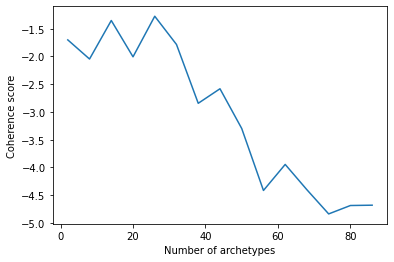

In [22]:
# u_mass coherence score for lda models
import matplotlib.pyplot as plt
limit=90; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_lda)
plt.xlabel("Number of archetypes")
plt.ylabel("Coherence score")
plt.show()

To better understand what is going, we can start by printing the archetypes with the function<code><i>print_topic</i></code>. We follow [hlynurd's approach](https://github.com/hlynurd/lda-for-magic) and print the top 16 card names in each archetype:

In [23]:
number_of_top_cards = 16
archetypes_to_inspect = 74
for i in range(archetypes_to_inspect):
    print(("Archetype %i \n %s \n") % (i, model_list_lda[-3].print_topic(i, topn=number_of_top_cards)))

Archetype 0 
 0.041*"Dread Return" + 0.041*"Lotus Petal" + 0.040*"Cabal Therapy" + 0.039*"Narcomoeba" + 0.039*"Bridge from Below" + 0.038*"Golgari Grave-Troll" + 0.038*"Ichorid" + 0.038*"Golgari Thug" + 0.038*"Stinkweed Imp" + 0.038*"Lion\\'s Eye Diamond" + 0.037*"Ashen Rider" + 0.037*"Gemstone Mine" + 0.036*"Cephalid Coliseum" + 0.035*"City of Brass" + 0.035*"Faithless Looting" + 0.034*"Hogaak, Arisen Necropolis" 

Archetype 1 
 0.126*"Krosan Grip" + 0.088*"Expedition Map" + 0.085*"Ugin, the Spirit Dragon" + 0.071*"Warping Wail" + 0.064*"Ancient Stirrings" + 0.054*"Faerie Macabre" + 0.044*"Veil of Summer" + 0.037*"Maze of Ith" + 0.036*"Boompile" + 0.031*"Eye of Ugin" + 0.030*"Pithing Needle" + 0.029*"Emrakul, the Aeons Torn" + 0.029*"Ulamog, the Ceaseless Hunger" + 0.027*"Vesuva" + 0.027*"Cloudpost" + 0.027*"Glimmerpost" 

Archetype 2 
 0.072*"Mountain" + 0.061*"Pyroblast" + 0.050*"Monastery Swiftspear" + 0.050*"Lightning Bolt" + 0.049*"Red Elemental Blast" + 0.046*"Price of Progress"

For convenience, you can explore the different archetypes with the files <code><i>archetypes_list_lda_74_topics.txt</i></code> and <code><i>archetypes_list_lda_74_topics_cleaned.txt</i></code>.

# Visualising the results with pyLDAvis

Now, it can be troublesome to try to make sense of the different archetypes when reading the outputs above. But lucky for us, there is a Python library called [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html) that offers interactive visualisation! 

First, let's save the plot:

In [24]:
pyLDAvis.enable_notebook()
gensim.corpora.MmCorpus.serialize('SerializedCorpus_legacy_2020_74_archetypes.mm'.format(i), corpus_memory_friendly)
SerializedCorpus = gensim.corpora.MmCorpus('SerializedCorpus_legacy_2020_74_archetypes.mm'.format(i))
vis_data = pyLDAvis.gensim.prepare(model_list_lda[-3], SerializedCorpus, dictionary,sort_topics=False)
pyLDAvis.save_html(vis_data, 'LDA_Visualization_legacy_2020_74_archetypes.html'.format(i))

INFO:gensim.corpora.mmcorpus:storing corpus in Matrix Market format to SerializedCorpus_legacy_2020_74_archetypes.mm
DEBUG:smart_open.smart_open_lib:{'uri': 'SerializedCorpus_legacy_2020_74_archetypes.mm', 'mode': 'wb+', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
INFO:gensim.matutils:saving sparse matrix to SerializedCorpus_legacy_2020_74_archetypes.mm
INFO:gensim.matutils:PROGRESS: saving document #0
INFO:gensim.matutils:PROGRESS: saving document #1000
INFO:gensim.matutils:PROGRESS: saving document #2000
INFO:gensim.matutils:PROGRESS: saving document #3000
INFO:gensim.matutils:saved 3718x1206 matrix, density=2.627% (117813/4483908)
DEBUG:gensim.matutils:closing SerializedCorpus_legacy_2020_74_archetypes.mm
DEBUG:gensim.matutils:closing SerializedCorpus_legacy_2020_74_archetypes.mm
INFO:gensim.corpora.indexedcorpus:saving MmCorpus index to SerializedCorpus_legacy_2020_74_archetypes.

Now, if we want to display it:

In [25]:
pyLDAvis.display(vis_data)

Now, for a discussion of the results, please check the blog (￣ω￣)